### This notebook trains proteinVI unshared, totalvi shared, and rna unshared on protein_unshared, protein shared, rna shared and rna_unshared

This notebook also train the models in a criss cross manner too.

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)
import anndata as ad
import scanpy as sc
import torch
import random

In [2]:
def set_random_seed():
    # Example usage:
    seed = 42
    # Set seed for random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_random_seed()

In [3]:
# read in protein data
protein = pd.read_csv("data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

# read in celltyle labels
metadata = pd.read_csv('data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2

print("Final stats of protein adata: \n",protein_adata)

Final stats of protein adata: 
 AnnData object with n_obs × n_vars = 10000 × 224
    obs: 'celltype.l1', 'celltype.l2'


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [4]:
# read in RNA data
rna = mmread("./data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('./data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

# read in celltyle labels
metadata = pd.read_csv('./data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [5]:
rna_protein_correspondence = []
correspondence = pd.read_csv('data/protein_gene_conversion.csv')
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)
print("Number of correspondence matches: ", rna_protein_correspondence.shape)
shared_gene_names_repeated = rna_protein_correspondence.T[0]
shared_protein_names_repeated = rna_protein_correspondence.T[1]
print("Unique shared gene names: {}, Unique shared protein names: {}".format(len(np.unique(shared_gene_names_repeated)), len(np.unique(shared_protein_names_repeated))))

Number of correspondence matches:  (180, 2)
Unique shared gene names: 170, Unique shared protein names: 170


In [6]:
shared_gene_features = list(set(shared_gene_names_repeated))
print("Final shared RNA: ",len(shared_gene_features))
shared_protein_features = list(set(shared_protein_names_repeated))
print("Final share protein: ", len(shared_protein_features))

rna_adata_copy = rna_adata.copy()
sc.pp.normalize_total(rna_adata_copy)
sc.pp.log1p(rna_adata_copy)
sc.pp.highly_variable_genes(rna_adata_copy, n_top_genes=2000)

highly_var_genes = list(set(rna_adata.var_names[rna_adata_copy.var.highly_variable==True]))
highly_var_genes_filtered = [gene for gene in highly_var_genes if gene not in shared_gene_features]

unshared_protein_features = [protein for protein in protein_adata.var_names if protein not in shared_protein_features]
print("Unshared protein features: ", len(unshared_protein_features))
print("variable genes that are not shared: ", len(highly_var_genes_filtered))

Final shared RNA:  170
Final share protein:  170
Unshared protein features:  54
variable genes that are not shared:  1911


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [7]:
def get_indices(feature_names, all_feature_names):
    """Returns the indices of features in 'feature_names' within the 'all_feature_names' list.

    Args:
        feature_names: A list of feature names to find indices for.
        all_feature_names: The complete list of all feature names.

    Returns:
        A list of indices corresponding to the positions of the 'feature_names' 
        within the 'all_feature_names' list. If a feature is not found, its index
        will be -1.
    """
    indices = []
    for feature in feature_names:
        try:
            index = all_feature_names.index(feature)
        except ValueError:
            index = -1  # Feature not found
        indices.append(index)
    return indices

In [8]:
unshared_gene_indices = get_indices(highly_var_genes_filtered, rna_adata.var_names.to_list())
shared_gene_indices = get_indices(shared_gene_names_repeated, rna_adata.var_names.to_list())
unshared_protein_indices = get_indices(unshared_protein_features, protein_adata.var_names.to_list())
shared_protein_indices = get_indices(shared_protein_names_repeated, protein_adata.var_names.to_list())

print("Length of unshared_gene_indices:", len(unshared_gene_indices))
print("Length of shared_gene_indices:", len(shared_gene_indices))
print("Length of unshared_protein_indices:", len(unshared_protein_indices))
print("Length of shared_protein_indices:", len(shared_protein_indices))

# Convert index lists to sets for unique element calculation
unshared_gene_unique = set(unshared_gene_indices)
shared_gene_unique = set(shared_gene_indices)
unshared_protein_unique = set(unshared_protein_indices)
shared_protein_unique = set(shared_protein_indices)

# Print lengths of unique elements
print("Unique elements in unshared_gene_indices:", len(unshared_gene_unique))
print("Unique elements in shared_gene_indices:", len(shared_gene_unique))
print("Unique elements in unshared_protein_indices:", len(unshared_protein_unique))
print("Unique elements in shared_protein_indices:", len(shared_protein_unique))

Length of unshared_gene_indices: 1911
Length of shared_gene_indices: 180
Length of unshared_protein_indices: 54
Length of shared_protein_indices: 180
Unique elements in unshared_gene_indices: 1911
Unique elements in shared_gene_indices: 170
Unique elements in unshared_protein_indices: 54
Unique elements in shared_protein_indices: 170


In [9]:
rna_unshared_adata = rna_adata[:,unshared_gene_indices]
rna_shared_adata = rna_adata[:,shared_gene_indices]
protein_unshared_adata = protein_adata[:,unshared_protein_indices]
protein_shared_adata = protein_adata[:,shared_protein_indices]

In [10]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class ProteinDataset(Dataset):
    def __init__(self,unshared_protein_adata, shared_protein_adata):
        self.unshared_data = np.asarray(unshared_protein_adata.X)
        self.shared_data = np.asarray(shared_protein_adata.X)
        self.labels_l1 = protein_adata.obs['celltype.l1']
        self.labels_l2 = protein_adata.obs['celltype.l2']
        self.batch = np.array([1.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"y_unshared":self.unshared_data[idx], "y_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "batch": self.batch[idx]}

protein_dataset = ProteinDataset(protein_unshared_adata, protein_shared_adata)
protein_dataloader = DataLoader(protein_dataset, batch_size=256, shuffle=True)

In [11]:
class RNADataset(Dataset):
    def __init__(self,unshared_rna_adata, shared_rna_adata):
        self.unshared_data = np.asarray(unshared_rna_adata.X.todense())
        self.shared_data = np.asarray(shared_rna_adata.X.todense())
        self.labels_l1 = rna_adata.obs['celltype.l1']
        self.labels_l2 = rna_adata.obs['celltype.l2']
        self.local_mean, self.local_var = self.compute_library_size(np.concatenate([self.unshared_data, self.shared_data],axis=1))
        self.local_mean = np.array([self.local_mean]*self.unshared_data.shape[0])
        self.local_var = np.array([self.local_var]*self.unshared_data.shape[0])
        self.batch = np.array([0.0]*self.unshared_data.shape[0]).reshape((-1,1)).astype(np.float32)
        
    def __len__(self):
        return self.unshared_data.shape[0]

    def __getitem__(self, idx):
        return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
    
    def compute_library_size(self, data):
        # print(data.shape)
        sum_counts = data.sum(axis=1)
        masked_log_sum = np.ma.log(sum_counts)
        if np.ma.is_masked(masked_log_sum):
            print(
                "Warning: This dataset has some empty cells, this might fail scVI inference. Data should be filtered with `my_dataset.filter_cells_by_count()"
            )
        log_counts = masked_log_sum.filled(0)
        local_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)
        local_var = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)

        local_mean = torch.Tensor(local_mean).reshape(-1)
        local_var = torch.Tensor(local_var).reshape(-1)
        return local_mean, local_var

rna_dataset = RNADataset(rna_unshared_adata, rna_shared_adata)
rna_dataloader = DataLoader(rna_dataset, batch_size=256, shuffle=True)

In [12]:
from scvi.models.proteinvi_unshared_cross import PROTENVI_UNSHARED_CROSS
from scvi.models.rna_unshared_cross import RNA_UNSHARED_CROSS
from scvi.models.totalvi_shared_cross import TOTALVI_SHARED_CROSS
import torch.nn.functional as F
import torch.nn as nn
import metrics.match_utils as mu

podel = PROTENVI_UNSHARED_CROSS(54, latent_distribution="normal", log_variational=True)
prodel = TOTALVI_SHARED_CROSS(180, latent_distribution="normal", log_variational=True, reconstruction_loss_gene = "poisson")
rodel = RNA_UNSHARED_CROSS(1911, latent_distribution="normal", log_variational=True, reconstruction_loss='poisson')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device used for training is: ", device)
podel.to(device)
prodel.to(device)
rodel.to(device)
prodel_params = filter(lambda p: p.requires_grad, prodel.parameters())
podel_params = filter(lambda p: p.requires_grad, podel.parameters())
rodel_params = filter(lambda p: p.requires_grad, rodel.parameters())

optimizer_p = torch.optim.Adam(podel_params, lr=0.001, eps=0.01)
optimizer_r = torch.optim.Adam(rodel_params, lr=0.001, eps=0.01)
optimizer_pr = torch.optim.Adam(prodel_params, lr=0.001, eps=0.01)

The device used for training is:  cpu


In [13]:
def l2_normalize_batch_pytorch(batch):
    norm = torch.norm(batch, dim=1, keepdim=True)
    normalized_batch = batch / norm
    return normalized_batch
    
def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

def CLIP_loss(rna_total,rna_unshared):
    
    text_embeddings = l2_normalize_batch_pytorch(rna_total)
    image_embeddings = l2_normalize_batch_pytorch(rna_unshared)
    temperature = 1.0
    logits = (text_embeddings @ image_embeddings.T) 
    images_similarity = image_embeddings @ image_embeddings.T
    texts_similarity = text_embeddings @ text_embeddings.T
    targets = F.softmax(
        (images_similarity + texts_similarity) / 2, dim=-1
    )
    texts_loss = cross_entropy(logits, targets, reduction='none')
    images_loss = cross_entropy(logits.T, targets.T, reduction='none')
    loss =  (images_loss + texts_loss) / 2.0 
    return loss.mean()

In [14]:
Unshared_protein_loss = []
Unshared_rna_loss = []
Shared_loss = []
loss_emb_p = []
loss_emb_r = []

final_unshared_protein_loss = 0.0
final_unshared_rna_loss = 0.0
final_shared_loss = 0.0
final_loss_emb_p = 0.0
final_loss_emb_r = 0.0

In [15]:
def get_paras_for_podel(para_out_prodel, gene_size):
    para = {}
    para["qz_m"] = para_out_prodel["qz_m"][gene_size:]
    para["qz_v"] = para_out_prodel["qz_v"][gene_size:]
    para["z_protein"] = para_out_prodel["z_protein"]
    para["untran_z"] = para_out_prodel["untran_z"][gene_size:]
    return para

def get_paras_for_rodel(para_out_prodel, gene_size):
    para = {}
    para["qz_m"] = para_out_prodel["qz_m"][:gene_size]
    para["qz_v"] = para_out_prodel["qz_v"][:gene_size]
    para["z_gene"] = para_out_prodel["z_gene"]
    para["ql_m"] = para_out_prodel["ql_m"][:gene_size]
    para["ql_v"] = para_out_prodel["ql_v"][:gene_size]
    para["l"] = para_out_prodel["l"][:gene_size]
    return para

def get_paras_for_prodel(para_out_rodel, para_out_podel, gene_size):
    para = {}
    para["qz_m"] = torch.cat([para_out_rodel["qz_m"], para_out_podel["qz_m"]], dim=0)
    para["qz_v"] = torch.cat([para_out_rodel["qz_v"], para_out_podel["qz_v"]], dim=0)    
    para["ql_m"] = torch.cat([para_out_rodel["ql_m"], torch.zeros_like(para_out_rodel["ql_m"])], dim=0)
    para["ql_v"] = torch.cat([para_out_rodel["ql_v"], torch.zeros_like(para_out_rodel["ql_v"])], dim=0)
    para["z_gene"] = para_out_rodel["z_gene"]
    para["z_protein"] = para_out_podel["z_protein"]
    para["l"] = torch.cat([para_out_rodel["l"], torch.zeros_like(para_out_rodel["l"])], dim=0)
    para["untran_z"] = torch.cat([torch.zeros_like(para_out_podel["untran_z"]), para_out_podel["untran_z"]], dim=0)
    para["untran_l"] = torch.cat([para_out_rodel["l"], torch.zeros_like(para_out_rodel["l"])], dim=0)
    return para

Epoch: 0: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 0: 40it [00:09,  4.39it/s]


RNA Recon Loss: 38.6658, RNA KL Div L: 0.6651, RNA KL Div Z: 0.0812, Protein Recon Loss: 1.6905, Protein KL Div Back Pro: 1.5880, Protein KL Div Z: 0.1058, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0220, Shared KL Div Z: 0.1353, Shared Recon Loss Gene: 0.6809, Shared Recon Loss Protein: 5.4927


Epoch: 1: 40it [00:08,  4.56it/s]


RNA Recon Loss: 21.0656, RNA KL Div L: 0.3959, RNA KL Div Z: 0.2359, Protein Recon Loss: 0.6393, Protein KL Div Back Pro: 1.7745, Protein KL Div Z: 0.2095, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0220, Shared KL Div Z: 0.1978, Shared Recon Loss Gene: 0.4565, Shared Recon Loss Protein: 2.2389


Epoch: 2: 40it [00:09,  4.36it/s]


RNA Recon Loss: 13.4092, RNA KL Div L: 0.2134, RNA KL Div Z: 0.3083, Protein Recon Loss: 0.6165, Protein KL Div Back Pro: 1.6158, Protein KL Div Z: 0.2336, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.2078, Shared Recon Loss Gene: 0.4347, Shared Recon Loss Protein: 2.1591


Epoch: 3: 40it [00:09,  4.35it/s]


RNA Recon Loss: 181.5665, RNA KL Div L: 0.0648, RNA KL Div Z: 0.3311, Protein Recon Loss: 0.6073, Protein KL Div Back Pro: 1.5375, Protein KL Div Z: 0.2544, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.2350, Shared Recon Loss Gene: 0.3983, Shared Recon Loss Protein: 2.1241


Epoch: 4: 40it [00:08,  4.58it/s]


RNA Recon Loss: 6.3352, RNA KL Div L: 0.0268, RNA KL Div Z: 0.3408, Protein Recon Loss: 0.5984, Protein KL Div Back Pro: 1.4757, Protein KL Div Z: 0.2741, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.2599, Shared Recon Loss Gene: 0.3807, Shared Recon Loss Protein: 2.1021


Epoch: 5: 40it [00:09,  4.43it/s]


RNA Recon Loss: 4.3983, RNA KL Div L: 0.0159, RNA KL Div Z: 0.3636, Protein Recon Loss: 0.5918, Protein KL Div Back Pro: 1.4267, Protein KL Div Z: 0.2931, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.2860, Shared Recon Loss Gene: 0.3691, Shared Recon Loss Protein: 2.0828


Epoch: 6: 40it [00:08,  4.65it/s]


RNA Recon Loss: 7.0900, RNA KL Div L: 0.0161, RNA KL Div Z: 0.3784, Protein Recon Loss: 0.5870, Protein KL Div Back Pro: 1.3876, Protein KL Div Z: 0.3100, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.3090, Shared Recon Loss Gene: 0.3622, Shared Recon Loss Protein: 2.0706


Epoch: 7: 40it [00:08,  4.75it/s]


RNA Recon Loss: 5.3412, RNA KL Div L: 0.0313, RNA KL Div Z: 0.3825, Protein Recon Loss: 0.5835, Protein KL Div Back Pro: 1.3629, Protein KL Div Z: 0.3261, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.3314, Shared Recon Loss Gene: 0.3565, Shared Recon Loss Protein: 2.0591


Epoch: 8: 40it [00:08,  4.49it/s]


RNA Recon Loss: 4.3957, RNA KL Div L: 0.0221, RNA KL Div Z: 0.3900, Protein Recon Loss: 0.5797, Protein KL Div Back Pro: 1.3371, Protein KL Div Z: 0.3425, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.3496, Shared Recon Loss Gene: 0.3521, Shared Recon Loss Protein: 2.0483


Epoch: 9: 40it [00:08,  4.67it/s]


RNA Recon Loss: 4.5397, RNA KL Div L: 0.0184, RNA KL Div Z: 0.3983, Protein Recon Loss: 0.5764, Protein KL Div Back Pro: 1.3151, Protein KL Div Z: 0.3588, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.3675, Shared Recon Loss Gene: 0.3507, Shared Recon Loss Protein: 2.0395


Epoch: 10: 40it [00:09,  4.06it/s]


RNA Recon Loss: 3.8101, RNA KL Div L: 0.0173, RNA KL Div Z: 0.3999, Protein Recon Loss: 0.5738, Protein KL Div Back Pro: 1.3000, Protein KL Div Z: 0.3742, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.3841, Shared Recon Loss Gene: 0.3473, Shared Recon Loss Protein: 2.0354


Epoch: 11: 40it [00:08,  4.79it/s]


RNA Recon Loss: 3.8349, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4049, Protein Recon Loss: 0.5715, Protein KL Div Back Pro: 1.2796, Protein KL Div Z: 0.3878, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4019, Shared Recon Loss Gene: 0.3434, Shared Recon Loss Protein: 2.0278


Epoch: 12: 40it [00:08,  4.97it/s]


RNA Recon Loss: 3.5772, RNA KL Div L: 0.0140, RNA KL Div Z: 0.4097, Protein Recon Loss: 0.5690, Protein KL Div Back Pro: 1.2624, Protein KL Div Z: 0.3995, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4158, Shared Recon Loss Gene: 0.3408, Shared Recon Loss Protein: 2.0219


Epoch: 13: 40it [00:08,  4.47it/s]


RNA Recon Loss: 3.4038, RNA KL Div L: 0.0132, RNA KL Div Z: 0.4151, Protein Recon Loss: 0.5667, Protein KL Div Back Pro: 1.2483, Protein KL Div Z: 0.4123, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4289, Shared Recon Loss Gene: 0.3391, Shared Recon Loss Protein: 2.0161


Epoch: 14: 40it [00:08,  4.69it/s]


RNA Recon Loss: 3.7913, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4148, Protein Recon Loss: 0.5659, Protein KL Div Back Pro: 1.2352, Protein KL Div Z: 0.4224, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4420, Shared Recon Loss Gene: 0.3376, Shared Recon Loss Protein: 2.0153


Epoch: 15: 40it [00:07,  5.08it/s]


RNA Recon Loss: 3.5965, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4183, Protein Recon Loss: 0.5629, Protein KL Div Back Pro: 1.2266, Protein KL Div Z: 0.4324, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4532, Shared Recon Loss Gene: 0.3359, Shared Recon Loss Protein: 2.0066


Epoch: 16: 40it [00:08,  4.90it/s]


RNA Recon Loss: 3.3342, RNA KL Div L: 0.0144, RNA KL Div Z: 0.4201, Protein Recon Loss: 0.5606, Protein KL Div Back Pro: 1.2103, Protein KL Div Z: 0.4419, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4621, Shared Recon Loss Gene: 0.3330, Shared Recon Loss Protein: 2.0023


Epoch: 17: 40it [00:08,  4.63it/s]


RNA Recon Loss: 3.4141, RNA KL Div L: 0.0144, RNA KL Div Z: 0.4230, Protein Recon Loss: 0.5590, Protein KL Div Back Pro: 1.2024, Protein KL Div Z: 0.4519, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4706, Shared Recon Loss Gene: 0.3317, Shared Recon Loss Protein: 1.9992


Epoch: 18: 40it [00:08,  4.87it/s]


RNA Recon Loss: 3.2917, RNA KL Div L: 0.0135, RNA KL Div Z: 0.4250, Protein Recon Loss: 0.5573, Protein KL Div Back Pro: 1.1926, Protein KL Div Z: 0.4603, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4807, Shared Recon Loss Gene: 0.3305, Shared Recon Loss Protein: 1.9959


Epoch: 19: 40it [00:08,  4.47it/s]


RNA Recon Loss: 3.4329, RNA KL Div L: 0.0141, RNA KL Div Z: 0.4239, Protein Recon Loss: 0.5557, Protein KL Div Back Pro: 1.1819, Protein KL Div Z: 0.4683, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4896, Shared Recon Loss Gene: 0.3294, Shared Recon Loss Protein: 1.9937


Epoch: 20: 40it [00:08,  4.77it/s]


RNA Recon Loss: 3.3634, RNA KL Div L: 0.0141, RNA KL Div Z: 0.4286, Protein Recon Loss: 0.5542, Protein KL Div Back Pro: 1.1780, Protein KL Div Z: 0.4761, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.4982, Shared Recon Loss Gene: 0.3276, Shared Recon Loss Protein: 1.9896


Epoch: 21: 40it [00:08,  4.70it/s]


RNA Recon Loss: 3.1906, RNA KL Div L: 0.0139, RNA KL Div Z: 0.4296, Protein Recon Loss: 0.5523, Protein KL Div Back Pro: 1.1701, Protein KL Div Z: 0.4852, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5049, Shared Recon Loss Gene: 0.3269, Shared Recon Loss Protein: 1.9858


Epoch: 22: 40it [00:08,  4.97it/s]


RNA Recon Loss: 3.2402, RNA KL Div L: 0.0138, RNA KL Div Z: 0.4290, Protein Recon Loss: 0.5503, Protein KL Div Back Pro: 1.1597, Protein KL Div Z: 0.4903, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5107, Shared Recon Loss Gene: 0.3247, Shared Recon Loss Protein: 1.9808


Epoch: 23: 40it [00:08,  4.92it/s]


RNA Recon Loss: 3.1971, RNA KL Div L: 0.0139, RNA KL Div Z: 0.4314, Protein Recon Loss: 0.5496, Protein KL Div Back Pro: 1.1540, Protein KL Div Z: 0.4977, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5170, Shared Recon Loss Gene: 0.3246, Shared Recon Loss Protein: 1.9792


Epoch: 24: 40it [00:08,  4.65it/s]


RNA Recon Loss: 3.2142, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4320, Protein Recon Loss: 0.5479, Protein KL Div Back Pro: 1.1490, Protein KL Div Z: 0.5051, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5224, Shared Recon Loss Gene: 0.3226, Shared Recon Loss Protein: 1.9763


Epoch: 25: 40it [00:09,  4.03it/s]


RNA Recon Loss: 3.0771, RNA KL Div L: 0.0134, RNA KL Div Z: 0.4339, Protein Recon Loss: 0.5460, Protein KL Div Back Pro: 1.1420, Protein KL Div Z: 0.5110, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5303, Shared Recon Loss Gene: 0.3209, Shared Recon Loss Protein: 1.9725


Epoch: 26: 40it [00:11,  3.56it/s]


RNA Recon Loss: 3.1941, RNA KL Div L: 0.0140, RNA KL Div Z: 0.4339, Protein Recon Loss: 0.5456, Protein KL Div Back Pro: 1.1373, Protein KL Div Z: 0.5184, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5346, Shared Recon Loss Gene: 0.3210, Shared Recon Loss Protein: 1.9710


Epoch: 27: 40it [00:10,  3.68it/s]


RNA Recon Loss: 3.3044, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4327, Protein Recon Loss: 0.5439, Protein KL Div Back Pro: 1.1273, Protein KL Div Z: 0.5230, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5404, Shared Recon Loss Gene: 0.3190, Shared Recon Loss Protein: 1.9672


Epoch: 28: 40it [00:10,  3.79it/s]


RNA Recon Loss: 3.2847, RNA KL Div L: 0.0146, RNA KL Div Z: 0.4319, Protein Recon Loss: 0.5434, Protein KL Div Back Pro: 1.1238, Protein KL Div Z: 0.5297, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5470, Shared Recon Loss Gene: 0.3184, Shared Recon Loss Protein: 1.9652


Epoch: 29: 40it [00:11,  3.43it/s]


RNA Recon Loss: 3.1137, RNA KL Div L: 0.0140, RNA KL Div Z: 0.4345, Protein Recon Loss: 0.5424, Protein KL Div Back Pro: 1.1158, Protein KL Div Z: 0.5326, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0218, Shared KL Div Z: 0.5502, Shared Recon Loss Gene: 0.3174, Shared Recon Loss Protein: 1.9646


Epoch: 30: 40it [00:08,  4.89it/s]


RNA Recon Loss: 3.0057, RNA KL Div L: 0.0143, RNA KL Div Z: 0.4346, Protein Recon Loss: 0.5414, Protein KL Div Back Pro: 1.1111, Protein KL Div Z: 0.5383, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5552, Shared Recon Loss Gene: 0.3160, Shared Recon Loss Protein: 1.9612


Epoch: 31: 40it [00:08,  4.83it/s]


RNA Recon Loss: 3.0197, RNA KL Div L: 0.0141, RNA KL Div Z: 0.4362, Protein Recon Loss: 0.5407, Protein KL Div Back Pro: 1.1048, Protein KL Div Z: 0.5428, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5587, Shared Recon Loss Gene: 0.3141, Shared Recon Loss Protein: 1.9599


Epoch: 32: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.9836, RNA KL Div L: 0.0141, RNA KL Div Z: 0.4365, Protein Recon Loss: 0.5389, Protein KL Div Back Pro: 1.1003, Protein KL Div Z: 0.5462, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5641, Shared Recon Loss Gene: 0.3139, Shared Recon Loss Protein: 1.9559


Epoch: 33: 40it [00:08,  4.84it/s]


RNA Recon Loss: 3.4598, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4380, Protein Recon Loss: 0.5380, Protein KL Div Back Pro: 1.0954, Protein KL Div Z: 0.5514, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5697, Shared Recon Loss Gene: 0.3134, Shared Recon Loss Protein: 1.9534


Epoch: 34: 40it [00:08,  4.79it/s]


RNA Recon Loss: 3.1254, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4355, Protein Recon Loss: 0.5372, Protein KL Div Back Pro: 1.0915, Protein KL Div Z: 0.5573, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5737, Shared Recon Loss Gene: 0.3116, Shared Recon Loss Protein: 1.9492


Epoch: 35: 40it [00:08,  4.74it/s]


RNA Recon Loss: 3.0233, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4389, Protein Recon Loss: 0.5367, Protein KL Div Back Pro: 1.0875, Protein KL Div Z: 0.5596, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5769, Shared Recon Loss Gene: 0.3096, Shared Recon Loss Protein: 1.9477


Epoch: 36: 40it [00:08,  4.81it/s]


RNA Recon Loss: 2.9785, RNA KL Div L: 0.0146, RNA KL Div Z: 0.4384, Protein Recon Loss: 0.5357, Protein KL Div Back Pro: 1.0823, Protein KL Div Z: 0.5640, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5786, Shared Recon Loss Gene: 0.3092, Shared Recon Loss Protein: 1.9447


Epoch: 37: 40it [00:08,  4.53it/s]


RNA Recon Loss: 3.1834, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4389, Protein Recon Loss: 0.5349, Protein KL Div Back Pro: 1.0779, Protein KL Div Z: 0.5669, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5832, Shared Recon Loss Gene: 0.3100, Shared Recon Loss Protein: 1.9416


Epoch: 38: 40it [00:10,  3.98it/s]


RNA Recon Loss: 3.0223, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4401, Protein Recon Loss: 0.5341, Protein KL Div Back Pro: 1.0755, Protein KL Div Z: 0.5695, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5870, Shared Recon Loss Gene: 0.3081, Shared Recon Loss Protein: 1.9402


Epoch: 39: 40it [00:08,  4.56it/s]


RNA Recon Loss: 3.0121, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4391, Protein Recon Loss: 0.5342, Protein KL Div Back Pro: 1.0707, Protein KL Div Z: 0.5726, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5922, Shared Recon Loss Gene: 0.3066, Shared Recon Loss Protein: 1.9442


Epoch: 40: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.9932, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4384, Protein Recon Loss: 0.5328, Protein KL Div Back Pro: 1.0686, Protein KL Div Z: 0.5753, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5927, Shared Recon Loss Gene: 0.3056, Shared Recon Loss Protein: 1.9389


Epoch: 41: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.9809, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4372, Protein Recon Loss: 0.5319, Protein KL Div Back Pro: 1.0654, Protein KL Div Z: 0.5770, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5962, Shared Recon Loss Gene: 0.3047, Shared Recon Loss Protein: 1.9349


Epoch: 42: 40it [00:08,  4.63it/s]


RNA Recon Loss: 3.2097, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4377, Protein Recon Loss: 0.5305, Protein KL Div Back Pro: 1.0620, Protein KL Div Z: 0.5820, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5973, Shared Recon Loss Gene: 0.3036, Shared Recon Loss Protein: 1.9317


Epoch: 43: 40it [00:08,  4.46it/s]


RNA Recon Loss: 3.1889, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4397, Protein Recon Loss: 0.5309, Protein KL Div Back Pro: 1.0557, Protein KL Div Z: 0.5817, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6008, Shared Recon Loss Gene: 0.3034, Shared Recon Loss Protein: 1.9328


Epoch: 44: 40it [00:08,  4.58it/s]


RNA Recon Loss: 3.1716, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4390, Protein Recon Loss: 0.5302, Protein KL Div Back Pro: 1.0554, Protein KL Div Z: 0.5880, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6042, Shared Recon Loss Gene: 0.3017, Shared Recon Loss Protein: 1.9323


Epoch: 45: 40it [00:08,  4.95it/s]


RNA Recon Loss: 3.0542, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4386, Protein Recon Loss: 0.5293, Protein KL Div Back Pro: 1.0500, Protein KL Div Z: 0.5868, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6073, Shared Recon Loss Gene: 0.3015, Shared Recon Loss Protein: 1.9296


Epoch: 46: 40it [00:08,  4.70it/s]


RNA Recon Loss: 2.9700, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4397, Protein Recon Loss: 0.5298, Protein KL Div Back Pro: 1.0446, Protein KL Div Z: 0.5897, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6076, Shared Recon Loss Gene: 0.3015, Shared Recon Loss Protein: 1.9258


Epoch: 47: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.9926, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4396, Protein Recon Loss: 0.5286, Protein KL Div Back Pro: 1.0438, Protein KL Div Z: 0.5915, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6096, Shared Recon Loss Gene: 0.3018, Shared Recon Loss Protein: 1.9236


Epoch: 48: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.9947, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4405, Protein Recon Loss: 0.5276, Protein KL Div Back Pro: 1.0441, Protein KL Div Z: 0.5926, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6124, Shared Recon Loss Gene: 0.3000, Shared Recon Loss Protein: 1.9202


Epoch: 49: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.8678, RNA KL Div L: 0.0147, RNA KL Div Z: 0.4400, Protein Recon Loss: 0.5272, Protein KL Div Back Pro: 1.0390, Protein KL Div Z: 0.5923, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6163, Shared Recon Loss Gene: 0.2996, Shared Recon Loss Protein: 1.9193


Epoch: 50: 40it [00:08,  4.94it/s]


RNA Recon Loss: 3.0317, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.5259, Protein KL Div Back Pro: 1.0374, Protein KL Div Z: 0.5958, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6195, Shared Recon Loss Gene: 0.2972, Shared Recon Loss Protein: 1.9165


Epoch: 51: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.9785, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4430, Protein Recon Loss: 0.5265, Protein KL Div Back Pro: 1.0350, Protein KL Div Z: 0.5941, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6197, Shared Recon Loss Gene: 0.2983, Shared Recon Loss Protein: 1.9182


Epoch: 52: 40it [00:08,  4.83it/s]


RNA Recon Loss: 3.0065, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5252, Protein KL Div Back Pro: 1.0342, Protein KL Div Z: 0.5969, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6209, Shared Recon Loss Gene: 0.2977, Shared Recon Loss Protein: 1.9137


Epoch: 53: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.8544, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.5251, Protein KL Div Back Pro: 1.0319, Protein KL Div Z: 0.5995, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6235, Shared Recon Loss Gene: 0.2961, Shared Recon Loss Protein: 1.9130


Epoch: 54: 40it [00:09,  4.27it/s]


RNA Recon Loss: 2.7905, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.5245, Protein KL Div Back Pro: 1.0275, Protein KL Div Z: 0.5974, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6267, Shared Recon Loss Gene: 0.2961, Shared Recon Loss Protein: 1.9107


Epoch: 55: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.7708, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5237, Protein KL Div Back Pro: 1.0271, Protein KL Div Z: 0.6011, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6292, Shared Recon Loss Gene: 0.2940, Shared Recon Loss Protein: 1.9110


Epoch: 56: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.8544, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.5233, Protein KL Div Back Pro: 1.0245, Protein KL Div Z: 0.6010, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6311, Shared Recon Loss Gene: 0.2941, Shared Recon Loss Protein: 1.9088


Epoch: 57: 40it [00:08,  4.55it/s]


RNA Recon Loss: 2.8893, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.5225, Protein KL Div Back Pro: 1.0232, Protein KL Div Z: 0.6037, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6332, Shared Recon Loss Gene: 0.2927, Shared Recon Loss Protein: 1.9055


Epoch: 58: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.8193, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4427, Protein Recon Loss: 0.5215, Protein KL Div Back Pro: 1.0222, Protein KL Div Z: 0.6047, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6353, Shared Recon Loss Gene: 0.2943, Shared Recon Loss Protein: 1.9041


Epoch: 59: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.7872, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5220, Protein KL Div Back Pro: 1.0168, Protein KL Div Z: 0.6044, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6383, Shared Recon Loss Gene: 0.2931, Shared Recon Loss Protein: 1.9048


Epoch: 60: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.8004, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.5217, Protein KL Div Back Pro: 1.0158, Protein KL Div Z: 0.6047, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6386, Shared Recon Loss Gene: 0.2926, Shared Recon Loss Protein: 1.9077


Epoch: 61: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.8439, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5209, Protein KL Div Back Pro: 1.0161, Protein KL Div Z: 0.6060, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6374, Shared Recon Loss Gene: 0.2917, Shared Recon Loss Protein: 1.9005


Epoch: 62: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.8887, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4427, Protein Recon Loss: 0.5219, Protein KL Div Back Pro: 1.0114, Protein KL Div Z: 0.6040, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6395, Shared Recon Loss Gene: 0.2915, Shared Recon Loss Protein: 1.9028


Epoch: 63: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.8396, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.5211, Protein KL Div Back Pro: 1.0133, Protein KL Div Z: 0.6056, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6412, Shared Recon Loss Gene: 0.2915, Shared Recon Loss Protein: 1.9032


Epoch: 64: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.8347, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4431, Protein Recon Loss: 0.5193, Protein KL Div Back Pro: 1.0120, Protein KL Div Z: 0.6075, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6405, Shared Recon Loss Gene: 0.2903, Shared Recon Loss Protein: 1.8945


Epoch: 65: 40it [00:08,  4.74it/s]


RNA Recon Loss: 2.9979, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4427, Protein Recon Loss: 0.5200, Protein KL Div Back Pro: 1.0078, Protein KL Div Z: 0.6072, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6425, Shared Recon Loss Gene: 0.2899, Shared Recon Loss Protein: 1.8970


Epoch: 66: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.9852, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.5202, Protein KL Div Back Pro: 1.0099, Protein KL Div Z: 0.6099, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6448, Shared Recon Loss Gene: 0.2905, Shared Recon Loss Protein: 1.8973


Epoch: 67: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.9460, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4427, Protein Recon Loss: 0.5180, Protein KL Div Back Pro: 1.0096, Protein KL Div Z: 0.6113, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6460, Shared Recon Loss Gene: 0.2901, Shared Recon Loss Protein: 1.8949


Epoch: 68: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.9384, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4433, Protein Recon Loss: 0.5207, Protein KL Div Back Pro: 1.0059, Protein KL Div Z: 0.6115, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6483, Shared Recon Loss Gene: 0.2881, Shared Recon Loss Protein: 1.8988


Epoch: 69: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.8213, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4429, Protein Recon Loss: 0.5205, Protein KL Div Back Pro: 1.0047, Protein KL Div Z: 0.6131, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6472, Shared Recon Loss Gene: 0.2906, Shared Recon Loss Protein: 1.8967


Epoch: 70: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.7804, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.5173, Protein KL Div Back Pro: 1.0025, Protein KL Div Z: 0.6088, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6487, Shared Recon Loss Gene: 0.2891, Shared Recon Loss Protein: 1.8907


Epoch: 71: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.7565, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5164, Protein KL Div Back Pro: 1.0041, Protein KL Div Z: 0.6111, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6499, Shared Recon Loss Gene: 0.2878, Shared Recon Loss Protein: 1.8872


Epoch: 72: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.7380, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5174, Protein KL Div Back Pro: 1.0047, Protein KL Div Z: 0.6143, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6538, Shared Recon Loss Gene: 0.2867, Shared Recon Loss Protein: 1.8888


Epoch: 73: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.8181, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4435, Protein Recon Loss: 0.5169, Protein KL Div Back Pro: 1.0025, Protein KL Div Z: 0.6131, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6548, Shared Recon Loss Gene: 0.2866, Shared Recon Loss Protein: 1.8862


Epoch: 74: 40it [00:08,  4.76it/s]


RNA Recon Loss: 2.8085, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.5177, Protein KL Div Back Pro: 1.0012, Protein KL Div Z: 0.6155, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6564, Shared Recon Loss Gene: 0.2869, Shared Recon Loss Protein: 1.8882


Epoch: 75: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.7004, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4447, Protein Recon Loss: 0.5155, Protein KL Div Back Pro: 0.9991, Protein KL Div Z: 0.6133, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6545, Shared Recon Loss Gene: 0.2868, Shared Recon Loss Protein: 1.8835


Epoch: 76: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.8768, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5142, Protein KL Div Back Pro: 0.9957, Protein KL Div Z: 0.6137, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6562, Shared Recon Loss Gene: 0.2854, Shared Recon Loss Protein: 1.8826


Epoch: 77: 40it [00:08,  4.78it/s]


RNA Recon Loss: 2.8215, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.5142, Protein KL Div Back Pro: 0.9983, Protein KL Div Z: 0.6157, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6574, Shared Recon Loss Gene: 0.2855, Shared Recon Loss Protein: 1.8800


Epoch: 78: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.7474, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4445, Protein Recon Loss: 0.5137, Protein KL Div Back Pro: 0.9969, Protein KL Div Z: 0.6186, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6591, Shared Recon Loss Gene: 0.2861, Shared Recon Loss Protein: 1.8791


Epoch: 79: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.9537, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5133, Protein KL Div Back Pro: 0.9947, Protein KL Div Z: 0.6203, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6593, Shared Recon Loss Gene: 0.2871, Shared Recon Loss Protein: 1.8812


Epoch: 80: 40it [00:08,  4.74it/s]


RNA Recon Loss: 2.8052, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.5132, Protein KL Div Back Pro: 0.9911, Protein KL Div Z: 0.6192, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6593, Shared Recon Loss Gene: 0.2849, Shared Recon Loss Protein: 1.8830


Epoch: 81: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.8689, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4449, Protein Recon Loss: 0.5131, Protein KL Div Back Pro: 0.9925, Protein KL Div Z: 0.6209, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6583, Shared Recon Loss Gene: 0.2842, Shared Recon Loss Protein: 1.8791


Epoch: 82: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.6537, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4440, Protein Recon Loss: 0.5132, Protein KL Div Back Pro: 0.9921, Protein KL Div Z: 0.6214, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6597, Shared Recon Loss Gene: 0.2835, Shared Recon Loss Protein: 1.8770


Epoch: 83: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.6792, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4428, Protein Recon Loss: 0.5125, Protein KL Div Back Pro: 0.9917, Protein KL Div Z: 0.6209, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6613, Shared Recon Loss Gene: 0.2835, Shared Recon Loss Protein: 1.8742


Epoch: 84: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.7191, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.5127, Protein KL Div Back Pro: 0.9926, Protein KL Div Z: 0.6208, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6600, Shared Recon Loss Gene: 0.2837, Shared Recon Loss Protein: 1.8789


Epoch: 85: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.7837, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4449, Protein Recon Loss: 0.5115, Protein KL Div Back Pro: 0.9922, Protein KL Div Z: 0.6242, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6625, Shared Recon Loss Gene: 0.2840, Shared Recon Loss Protein: 1.8758


Epoch: 86: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.7112, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5119, Protein KL Div Back Pro: 0.9892, Protein KL Div Z: 0.6240, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6617, Shared Recon Loss Gene: 0.2826, Shared Recon Loss Protein: 1.8705


Epoch: 87: 40it [00:08,  4.99it/s]


RNA Recon Loss: 2.9037, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4438, Protein Recon Loss: 0.5132, Protein KL Div Back Pro: 0.9885, Protein KL Div Z: 0.6243, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6629, Shared Recon Loss Gene: 0.2820, Shared Recon Loss Protein: 1.8755


Epoch: 88: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.8069, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4444, Protein Recon Loss: 0.5130, Protein KL Div Back Pro: 0.9844, Protein KL Div Z: 0.6236, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6681, Shared Recon Loss Gene: 0.2824, Shared Recon Loss Protein: 1.8734


Epoch: 89: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.7200, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5109, Protein KL Div Back Pro: 0.9841, Protein KL Div Z: 0.6224, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6645, Shared Recon Loss Gene: 0.2816, Shared Recon Loss Protein: 1.8667


Epoch: 90: 40it [00:09,  4.35it/s]


RNA Recon Loss: 2.7928, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4447, Protein Recon Loss: 0.5123, Protein KL Div Back Pro: 0.9822, Protein KL Div Z: 0.6223, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6618, Shared Recon Loss Gene: 0.2823, Shared Recon Loss Protein: 1.8761


Epoch: 91: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.8070, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5107, Protein KL Div Back Pro: 0.9833, Protein KL Div Z: 0.6226, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6652, Shared Recon Loss Gene: 0.2831, Shared Recon Loss Protein: 1.8695


Epoch: 92: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.7092, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.5092, Protein KL Div Back Pro: 0.9836, Protein KL Div Z: 0.6238, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6666, Shared Recon Loss Gene: 0.2820, Shared Recon Loss Protein: 1.8669


Epoch: 93: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.6515, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5104, Protein KL Div Back Pro: 0.9824, Protein KL Div Z: 0.6245, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6647, Shared Recon Loss Gene: 0.2819, Shared Recon Loss Protein: 1.8708


Epoch: 94: 40it [00:09,  4.26it/s]


RNA Recon Loss: 2.6700, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.5097, Protein KL Div Back Pro: 0.9828, Protein KL Div Z: 0.6237, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6645, Shared Recon Loss Gene: 0.2820, Shared Recon Loss Protein: 1.8662


Epoch: 95: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.6807, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4428, Protein Recon Loss: 0.5091, Protein KL Div Back Pro: 0.9825, Protein KL Div Z: 0.6267, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6655, Shared Recon Loss Gene: 0.2817, Shared Recon Loss Protein: 1.8669


Epoch: 96: 40it [00:10,  3.98it/s]


RNA Recon Loss: 2.6730, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.5092, Protein KL Div Back Pro: 0.9775, Protein KL Div Z: 0.6269, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6664, Shared Recon Loss Gene: 0.2821, Shared Recon Loss Protein: 1.8659


Epoch: 97: 40it [00:09,  4.25it/s]


RNA Recon Loss: 2.8129, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4425, Protein Recon Loss: 0.5105, Protein KL Div Back Pro: 0.9805, Protein KL Div Z: 0.6275, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6656, Shared Recon Loss Gene: 0.2814, Shared Recon Loss Protein: 1.8673


Epoch: 98: 40it [00:09,  4.23it/s]


RNA Recon Loss: 2.7818, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.5104, Protein KL Div Back Pro: 0.9799, Protein KL Div Z: 0.6283, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6688, Shared Recon Loss Gene: 0.2803, Shared Recon Loss Protein: 1.8673


Epoch: 99: 40it [00:08,  4.85it/s]


RNA Recon Loss: 2.9338, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.5093, Protein KL Div Back Pro: 0.9804, Protein KL Div Z: 0.6273, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6645, Shared Recon Loss Gene: 0.2805, Shared Recon Loss Protein: 1.8605


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


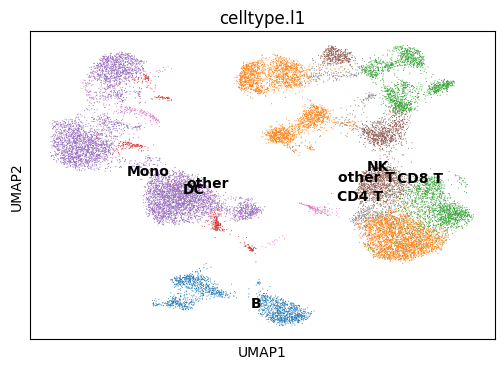

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


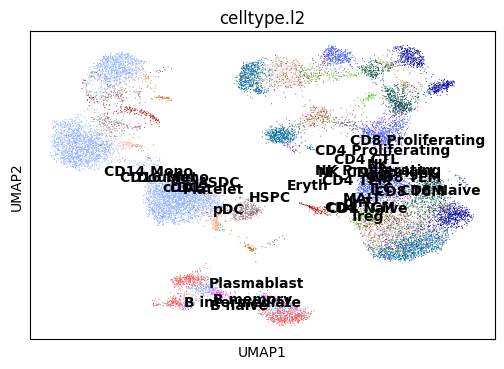

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


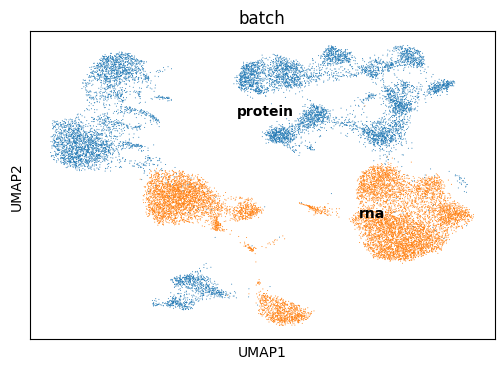

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.545,
lv2 matching acc: 0.364.
For All matchings: FOSCTTM score: 0.31064209, 
Knn Alignment score: [0.0004 0.0011 0.002  0.0025 0.0033 0.0044 0.0053 0.0062 0.007  0.0078
 0.0082 0.0087 0.0091 0.0094 0.0103 0.0111 0.0115 0.012  0.0125 0.0129
 0.0135 0.014  0.0144 0.0149 0.0152]
For All matchings: Silhouette F1 score for lv1: 0.4601377313335421, 
Silhouette F1 score for lv2: 0.4485185162126948


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])





Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  6.006957769393921
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.592,
lv2 matching acc: 0.432.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])





Matches are being propagated....


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.645,
lv2 matching acc: 0.464.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


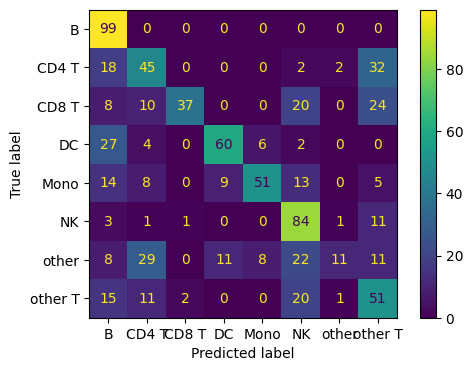

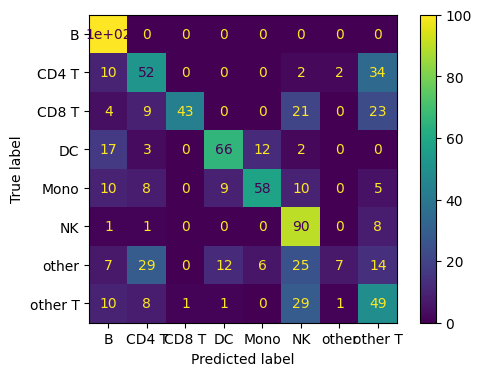

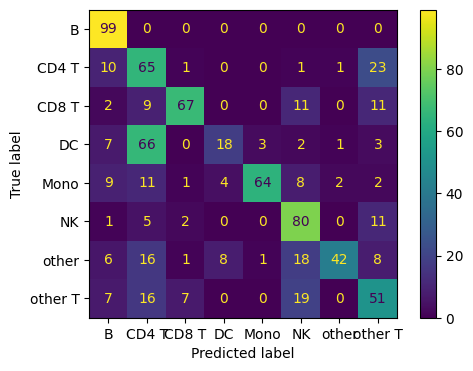

Epoch: 100: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 100: 40it [00:11,  3.58it/s]


RNA Recon Loss: 2.8481, RNA KL Div L: 0.0185, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.5072, Protein KL Div Back Pro: 0.9776, Protein KL Div Z: 0.6277, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6652, Shared Recon Loss Gene: 0.2803, Shared Recon Loss Protein: 1.8590


Epoch: 101: 40it [00:10,  3.97it/s]


RNA Recon Loss: 2.7045, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5081, Protein KL Div Back Pro: 0.9724, Protein KL Div Z: 0.6254, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6672, Shared Recon Loss Gene: 0.2798, Shared Recon Loss Protein: 1.8577


Epoch: 102: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.6606, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.5077, Protein KL Div Back Pro: 0.9738, Protein KL Div Z: 0.6266, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6669, Shared Recon Loss Gene: 0.2790, Shared Recon Loss Protein: 1.8599


Epoch: 103: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.6208, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.5069, Protein KL Div Back Pro: 0.9744, Protein KL Div Z: 0.6270, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6658, Shared Recon Loss Gene: 0.2782, Shared Recon Loss Protein: 1.8578


Epoch: 104: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.6659, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.5064, Protein KL Div Back Pro: 0.9767, Protein KL Div Z: 0.6285, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6680, Shared Recon Loss Gene: 0.2784, Shared Recon Loss Protein: 1.8590


Epoch: 105: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.6731, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5066, Protein KL Div Back Pro: 0.9738, Protein KL Div Z: 0.6286, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6697, Shared Recon Loss Gene: 0.2778, Shared Recon Loss Protein: 1.8595


Epoch: 106: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.6528, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.5075, Protein KL Div Back Pro: 0.9734, Protein KL Div Z: 0.6296, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6686, Shared Recon Loss Gene: 0.2777, Shared Recon Loss Protein: 1.8597


Epoch: 107: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.6337, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5059, Protein KL Div Back Pro: 0.9715, Protein KL Div Z: 0.6297, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6669, Shared Recon Loss Gene: 0.2780, Shared Recon Loss Protein: 1.8567


Epoch: 108: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.6849, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5067, Protein KL Div Back Pro: 0.9697, Protein KL Div Z: 0.6281, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6671, Shared Recon Loss Gene: 0.2774, Shared Recon Loss Protein: 1.8552


Epoch: 109: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.7579, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.5056, Protein KL Div Back Pro: 0.9701, Protein KL Div Z: 0.6284, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6670, Shared Recon Loss Gene: 0.2776, Shared Recon Loss Protein: 1.8540


Epoch: 110: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.7970, RNA KL Div L: 0.0175, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.5051, Protein KL Div Back Pro: 0.9724, Protein KL Div Z: 0.6313, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6683, Shared Recon Loss Gene: 0.2779, Shared Recon Loss Protein: 1.8524


Epoch: 111: 40it [00:08,  4.78it/s]


RNA Recon Loss: 2.6677, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4406, Protein Recon Loss: 0.5052, Protein KL Div Back Pro: 0.9675, Protein KL Div Z: 0.6304, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6688, Shared Recon Loss Gene: 0.2769, Shared Recon Loss Protein: 1.8535


Epoch: 112: 40it [00:09,  4.28it/s]


RNA Recon Loss: 2.6023, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.5065, Protein KL Div Back Pro: 0.9677, Protein KL Div Z: 0.6313, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6672, Shared Recon Loss Gene: 0.2766, Shared Recon Loss Protein: 1.8524


Epoch: 113: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.6154, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.5067, Protein KL Div Back Pro: 0.9679, Protein KL Div Z: 0.6324, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6680, Shared Recon Loss Gene: 0.2773, Shared Recon Loss Protein: 1.8538


Epoch: 114: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.6844, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.5051, Protein KL Div Back Pro: 0.9649, Protein KL Div Z: 0.6327, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6664, Shared Recon Loss Gene: 0.2772, Shared Recon Loss Protein: 1.8504


Epoch: 115: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.6179, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.5051, Protein KL Div Back Pro: 0.9670, Protein KL Div Z: 0.6326, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6678, Shared Recon Loss Gene: 0.2769, Shared Recon Loss Protein: 1.8500


Epoch: 116: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.6044, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.5058, Protein KL Div Back Pro: 0.9670, Protein KL Div Z: 0.6331, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6676, Shared Recon Loss Gene: 0.2769, Shared Recon Loss Protein: 1.8495


Epoch: 117: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.5827, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.5041, Protein KL Div Back Pro: 0.9679, Protein KL Div Z: 0.6337, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6665, Shared Recon Loss Gene: 0.2763, Shared Recon Loss Protein: 1.8481


Epoch: 118: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.7307, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.5044, Protein KL Div Back Pro: 0.9659, Protein KL Div Z: 0.6343, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6684, Shared Recon Loss Gene: 0.2771, Shared Recon Loss Protein: 1.8481


Epoch: 119: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.8072, RNA KL Div L: 0.0177, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.5039, Protein KL Div Back Pro: 0.9641, Protein KL Div Z: 0.6344, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6674, Shared Recon Loss Gene: 0.2764, Shared Recon Loss Protein: 1.8468


Epoch: 120: 40it [00:07,  5.03it/s]


RNA Recon Loss: 2.5951, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4380, Protein Recon Loss: 0.5029, Protein KL Div Back Pro: 0.9670, Protein KL Div Z: 0.6345, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6666, Shared Recon Loss Gene: 0.2755, Shared Recon Loss Protein: 1.8473


Epoch: 121: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.5939, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.5050, Protein KL Div Back Pro: 0.9677, Protein KL Div Z: 0.6347, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6652, Shared Recon Loss Gene: 0.2758, Shared Recon Loss Protein: 1.8480


Epoch: 122: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.5965, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.5050, Protein KL Div Back Pro: 0.9692, Protein KL Div Z: 0.6341, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6659, Shared Recon Loss Gene: 0.2762, Shared Recon Loss Protein: 1.8507


Epoch: 123: 40it [00:08,  4.83it/s]


RNA Recon Loss: 2.5780, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.5048, Protein KL Div Back Pro: 0.9726, Protein KL Div Z: 0.6346, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6652, Shared Recon Loss Gene: 0.2761, Shared Recon Loss Protein: 1.8511


Epoch: 124: 40it [00:08,  4.99it/s]


RNA Recon Loss: 2.6197, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.5031, Protein KL Div Back Pro: 0.9709, Protein KL Div Z: 0.6333, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6657, Shared Recon Loss Gene: 0.2756, Shared Recon Loss Protein: 1.8501


Epoch: 125: 40it [00:08,  4.83it/s]


RNA Recon Loss: 2.6465, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.5029, Protein KL Div Back Pro: 0.9704, Protein KL Div Z: 0.6351, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6633, Shared Recon Loss Gene: 0.2753, Shared Recon Loss Protein: 1.8438


Epoch: 126: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.6638, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4423, Protein Recon Loss: 0.5021, Protein KL Div Back Pro: 0.9660, Protein KL Div Z: 0.6345, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6631, Shared Recon Loss Gene: 0.2750, Shared Recon Loss Protein: 1.8460


Epoch: 127: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.6142, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.5029, Protein KL Div Back Pro: 0.9657, Protein KL Div Z: 0.6347, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6608, Shared Recon Loss Gene: 0.2741, Shared Recon Loss Protein: 1.8446


Epoch: 128: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.6397, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5030, Protein KL Div Back Pro: 0.9666, Protein KL Div Z: 0.6349, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6612, Shared Recon Loss Gene: 0.2746, Shared Recon Loss Protein: 1.8464


Epoch: 129: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.5989, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5040, Protein KL Div Back Pro: 0.9663, Protein KL Div Z: 0.6350, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6593, Shared Recon Loss Gene: 0.2749, Shared Recon Loss Protein: 1.8459


Epoch: 130: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.8207, RNA KL Div L: 0.0173, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.5013, Protein KL Div Back Pro: 0.9647, Protein KL Div Z: 0.6353, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6593, Shared Recon Loss Gene: 0.2741, Shared Recon Loss Protein: 1.8416


Epoch: 131: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.7901, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4423, Protein Recon Loss: 0.5018, Protein KL Div Back Pro: 0.9673, Protein KL Div Z: 0.6373, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6606, Shared Recon Loss Gene: 0.2748, Shared Recon Loss Protein: 1.8442


Epoch: 132: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.5821, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.5013, Protein KL Div Back Pro: 0.9707, Protein KL Div Z: 0.6386, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6616, Shared Recon Loss Gene: 0.2750, Shared Recon Loss Protein: 1.8435


Epoch: 133: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.6067, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.5017, Protein KL Div Back Pro: 0.9666, Protein KL Div Z: 0.6370, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6630, Shared Recon Loss Gene: 0.2744, Shared Recon Loss Protein: 1.8416


Epoch: 134: 40it [00:08,  4.88it/s]


RNA Recon Loss: 2.5629, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.5012, Protein KL Div Back Pro: 0.9648, Protein KL Div Z: 0.6373, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6614, Shared Recon Loss Gene: 0.2735, Shared Recon Loss Protein: 1.8406


Epoch: 135: 40it [00:08,  4.78it/s]


RNA Recon Loss: 2.5678, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5013, Protein KL Div Back Pro: 0.9577, Protein KL Div Z: 0.6335, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6586, Shared Recon Loss Gene: 0.2740, Shared Recon Loss Protein: 1.8423


Epoch: 136: 40it [00:08,  4.85it/s]


RNA Recon Loss: 2.8156, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.5006, Protein KL Div Back Pro: 0.9585, Protein KL Div Z: 0.6353, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6583, Shared Recon Loss Gene: 0.2742, Shared Recon Loss Protein: 1.8375


Epoch: 137: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.8865, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.5032, Protein KL Div Back Pro: 0.9613, Protein KL Div Z: 0.6356, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6587, Shared Recon Loss Gene: 0.2755, Shared Recon Loss Protein: 1.8417


Epoch: 138: 40it [00:08,  4.94it/s]


RNA Recon Loss: 2.6477, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4426, Protein Recon Loss: 0.5021, Protein KL Div Back Pro: 0.9561, Protein KL Div Z: 0.6340, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6571, Shared Recon Loss Gene: 0.2743, Shared Recon Loss Protein: 1.8410


Epoch: 139: 40it [00:08,  4.84it/s]


RNA Recon Loss: 2.6466, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4426, Protein Recon Loss: 0.5015, Protein KL Div Back Pro: 0.9603, Protein KL Div Z: 0.6369, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6572, Shared Recon Loss Gene: 0.2742, Shared Recon Loss Protein: 1.8464


Epoch: 140: 40it [00:08,  4.83it/s]


RNA Recon Loss: 2.7055, RNA KL Div L: 0.0172, RNA KL Div Z: 0.4423, Protein Recon Loss: 0.5019, Protein KL Div Back Pro: 0.9612, Protein KL Div Z: 0.6371, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6554, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8373


Epoch: 141: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.5697, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.5013, Protein KL Div Back Pro: 0.9595, Protein KL Div Z: 0.6359, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6562, Shared Recon Loss Gene: 0.2742, Shared Recon Loss Protein: 1.8379


Epoch: 142: 40it [00:13,  3.02it/s]


RNA Recon Loss: 2.5427, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.5009, Protein KL Div Back Pro: 0.9587, Protein KL Div Z: 0.6359, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6574, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8358


Epoch: 143: 40it [00:11,  3.35it/s]


RNA Recon Loss: 2.5699, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.5014, Protein KL Div Back Pro: 0.9586, Protein KL Div Z: 0.6359, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6575, Shared Recon Loss Gene: 0.2734, Shared Recon Loss Protein: 1.8349


Epoch: 144: 40it [00:11,  3.48it/s]


RNA Recon Loss: 2.5799, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4412, Protein Recon Loss: 0.4996, Protein KL Div Back Pro: 0.9574, Protein KL Div Z: 0.6373, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6570, Shared Recon Loss Gene: 0.2729, Shared Recon Loss Protein: 1.8363


Epoch: 145: 40it [00:10,  3.64it/s]


RNA Recon Loss: 2.5627, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4426, Protein Recon Loss: 0.4998, Protein KL Div Back Pro: 0.9553, Protein KL Div Z: 0.6362, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6573, Shared Recon Loss Gene: 0.2723, Shared Recon Loss Protein: 1.8374


Epoch: 146: 40it [00:11,  3.61it/s]


RNA Recon Loss: 2.5947, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4412, Protein Recon Loss: 0.4995, Protein KL Div Back Pro: 0.9568, Protein KL Div Z: 0.6360, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6559, Shared Recon Loss Gene: 0.2730, Shared Recon Loss Protein: 1.8366


Epoch: 147: 40it [00:11,  3.59it/s]


RNA Recon Loss: 2.7113, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4997, Protein KL Div Back Pro: 0.9588, Protein KL Div Z: 0.6363, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6535, Shared Recon Loss Gene: 0.2741, Shared Recon Loss Protein: 1.8397


Epoch: 148: 40it [00:11,  3.50it/s]


RNA Recon Loss: 2.5956, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.5018, Protein KL Div Back Pro: 0.9548, Protein KL Div Z: 0.6364, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6546, Shared Recon Loss Gene: 0.2736, Shared Recon Loss Protein: 1.8412


Epoch: 149: 40it [00:10,  3.64it/s]


RNA Recon Loss: 2.5437, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.4999, Protein KL Div Back Pro: 0.9538, Protein KL Div Z: 0.6331, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6571, Shared Recon Loss Gene: 0.2733, Shared Recon Loss Protein: 1.8370


Epoch: 150: 40it [00:11,  3.45it/s]


RNA Recon Loss: 2.5497, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.4999, Protein KL Div Back Pro: 0.9598, Protein KL Div Z: 0.6352, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6552, Shared Recon Loss Gene: 0.2727, Shared Recon Loss Protein: 1.8369


Epoch: 151: 40it [00:13,  2.93it/s]


RNA Recon Loss: 2.5690, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4994, Protein KL Div Back Pro: 0.9595, Protein KL Div Z: 0.6351, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6533, Shared Recon Loss Gene: 0.2742, Shared Recon Loss Protein: 1.8366


Epoch: 152: 40it [00:14,  2.80it/s]


RNA Recon Loss: 2.5897, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.4996, Protein KL Div Back Pro: 0.9554, Protein KL Div Z: 0.6345, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6516, Shared Recon Loss Gene: 0.2725, Shared Recon Loss Protein: 1.8376


Epoch: 153: 40it [00:13,  2.96it/s]


RNA Recon Loss: 2.6406, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4412, Protein Recon Loss: 0.4984, Protein KL Div Back Pro: 0.9563, Protein KL Div Z: 0.6343, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6510, Shared Recon Loss Gene: 0.2721, Shared Recon Loss Protein: 1.8344


Epoch: 154: 40it [00:12,  3.30it/s]


RNA Recon Loss: 2.6219, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4990, Protein KL Div Back Pro: 0.9592, Protein KL Div Z: 0.6364, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6546, Shared Recon Loss Gene: 0.2724, Shared Recon Loss Protein: 1.8327


Epoch: 155: 40it [00:11,  3.39it/s]


RNA Recon Loss: 2.6089, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.5008, Protein KL Div Back Pro: 0.9525, Protein KL Div Z: 0.6334, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6511, Shared Recon Loss Gene: 0.2724, Shared Recon Loss Protein: 1.8427


Epoch: 156: 40it [00:12,  3.30it/s]


RNA Recon Loss: 2.5673, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.9552, Protein KL Div Z: 0.6344, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6532, Shared Recon Loss Gene: 0.2731, Shared Recon Loss Protein: 1.8399


Epoch: 157: 40it [00:11,  3.43it/s]


RNA Recon Loss: 2.5430, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4995, Protein KL Div Back Pro: 0.9564, Protein KL Div Z: 0.6337, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6517, Shared Recon Loss Gene: 0.2717, Shared Recon Loss Protein: 1.8316


Epoch: 158: 40it [00:12,  3.30it/s]


RNA Recon Loss: 2.5507, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9576, Protein KL Div Z: 0.6352, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6522, Shared Recon Loss Gene: 0.2717, Shared Recon Loss Protein: 1.8309


Epoch: 159: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.5388, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4402, Protein Recon Loss: 0.4978, Protein KL Div Back Pro: 0.9567, Protein KL Div Z: 0.6358, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6542, Shared Recon Loss Gene: 0.2726, Shared Recon Loss Protein: 1.8334


Epoch: 160: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.5741, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4407, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.9580, Protein KL Div Z: 0.6356, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6535, Shared Recon Loss Gene: 0.2716, Shared Recon Loss Protein: 1.8317


Epoch: 161: 40it [00:06,  6.01it/s]


RNA Recon Loss: 2.6818, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4405, Protein Recon Loss: 0.5004, Protein KL Div Back Pro: 0.9587, Protein KL Div Z: 0.6369, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6538, Shared Recon Loss Gene: 0.2717, Shared Recon Loss Protein: 1.8342


Epoch: 162: 40it [00:06,  6.02it/s]


RNA Recon Loss: 2.6192, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4407, Protein Recon Loss: 0.4981, Protein KL Div Back Pro: 0.9562, Protein KL Div Z: 0.6367, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6558, Shared Recon Loss Gene: 0.2706, Shared Recon Loss Protein: 1.8309


Epoch: 163: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.5383, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4988, Protein KL Div Back Pro: 0.9502, Protein KL Div Z: 0.6354, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6539, Shared Recon Loss Gene: 0.2714, Shared Recon Loss Protein: 1.8329


Epoch: 164: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.5460, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4979, Protein KL Div Back Pro: 0.9514, Protein KL Div Z: 0.6350, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6524, Shared Recon Loss Gene: 0.2718, Shared Recon Loss Protein: 1.8283


Epoch: 165: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.5668, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4406, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9520, Protein KL Div Z: 0.6337, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6507, Shared Recon Loss Gene: 0.2720, Shared Recon Loss Protein: 1.8387


Epoch: 166: 40it [00:07,  5.64it/s]


RNA Recon Loss: 2.5111, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.4993, Protein KL Div Back Pro: 0.9501, Protein KL Div Z: 0.6345, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6508, Shared Recon Loss Gene: 0.2718, Shared Recon Loss Protein: 1.8375


Epoch: 167: 40it [00:06,  5.77it/s]


RNA Recon Loss: 2.5555, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.4981, Protein KL Div Back Pro: 0.9449, Protein KL Div Z: 0.6319, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6494, Shared Recon Loss Gene: 0.2713, Shared Recon Loss Protein: 1.8329


Epoch: 168: 40it [00:06,  5.82it/s]


RNA Recon Loss: 2.5062, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4989, Protein KL Div Back Pro: 0.9489, Protein KL Div Z: 0.6329, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6491, Shared Recon Loss Gene: 0.2713, Shared Recon Loss Protein: 1.8342


Epoch: 169: 40it [00:06,  5.87it/s]


RNA Recon Loss: 2.4992, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.4970, Protein KL Div Back Pro: 0.9498, Protein KL Div Z: 0.6322, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6491, Shared Recon Loss Gene: 0.2709, Shared Recon Loss Protein: 1.8318


Epoch: 170: 40it [00:06,  5.81it/s]


RNA Recon Loss: 2.4957, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4960, Protein KL Div Back Pro: 0.9492, Protein KL Div Z: 0.6325, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6498, Shared Recon Loss Gene: 0.2712, Shared Recon Loss Protein: 1.8245


Epoch: 171: 40it [00:07,  5.67it/s]


RNA Recon Loss: 2.5506, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4979, Protein KL Div Back Pro: 0.9448, Protein KL Div Z: 0.6322, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6480, Shared Recon Loss Gene: 0.2716, Shared Recon Loss Protein: 1.8289


Epoch: 172: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.5804, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4405, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.9452, Protein KL Div Z: 0.6308, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6481, Shared Recon Loss Gene: 0.2706, Shared Recon Loss Protein: 1.8278


Epoch: 173: 40it [00:09,  4.32it/s]


RNA Recon Loss: 2.6515, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4970, Protein KL Div Back Pro: 0.9474, Protein KL Div Z: 0.6325, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6484, Shared Recon Loss Gene: 0.2713, Shared Recon Loss Protein: 1.8303


Epoch: 174: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.5047, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.4967, Protein KL Div Back Pro: 0.9487, Protein KL Div Z: 0.6337, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6491, Shared Recon Loss Gene: 0.2708, Shared Recon Loss Protein: 1.8267


Epoch: 175: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.5543, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4972, Protein KL Div Back Pro: 0.9458, Protein KL Div Z: 0.6321, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6473, Shared Recon Loss Gene: 0.2711, Shared Recon Loss Protein: 1.8274


Epoch: 176: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.5928, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4966, Protein KL Div Back Pro: 0.9459, Protein KL Div Z: 0.6322, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6486, Shared Recon Loss Gene: 0.2706, Shared Recon Loss Protein: 1.8256


Epoch: 177: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.5688, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.4963, Protein KL Div Back Pro: 0.9430, Protein KL Div Z: 0.6318, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6472, Shared Recon Loss Gene: 0.2705, Shared Recon Loss Protein: 1.8275


Epoch: 178: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.5364, RNA KL Div L: 0.0170, RNA KL Div Z: 0.4406, Protein Recon Loss: 0.4958, Protein KL Div Back Pro: 0.9487, Protein KL Div Z: 0.6319, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6470, Shared Recon Loss Gene: 0.2704, Shared Recon Loss Protein: 1.8264


Epoch: 179: 40it [00:08,  4.88it/s]


RNA Recon Loss: 2.4981, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4975, Protein KL Div Back Pro: 0.9476, Protein KL Div Z: 0.6313, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6475, Shared Recon Loss Gene: 0.2705, Shared Recon Loss Protein: 1.8269


Epoch: 180: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.4574, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4959, Protein KL Div Back Pro: 0.9486, Protein KL Div Z: 0.6332, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6482, Shared Recon Loss Gene: 0.2713, Shared Recon Loss Protein: 1.8254


Epoch: 181: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.4625, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4407, Protein Recon Loss: 0.4965, Protein KL Div Back Pro: 0.9460, Protein KL Div Z: 0.6316, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6469, Shared Recon Loss Gene: 0.2707, Shared Recon Loss Protein: 1.8281


Epoch: 182: 40it [00:07,  5.15it/s]


RNA Recon Loss: 2.5821, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4401, Protein Recon Loss: 0.4952, Protein KL Div Back Pro: 0.9481, Protein KL Div Z: 0.6319, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6460, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8264


Epoch: 183: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.6044, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4405, Protein Recon Loss: 0.4957, Protein KL Div Back Pro: 0.9501, Protein KL Div Z: 0.6315, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6457, Shared Recon Loss Gene: 0.2697, Shared Recon Loss Protein: 1.8255


Epoch: 184: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.5161, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.9494, Protein KL Div Z: 0.6324, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6448, Shared Recon Loss Gene: 0.2710, Shared Recon Loss Protein: 1.8298


Epoch: 185: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.5570, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4412, Protein Recon Loss: 0.4957, Protein KL Div Back Pro: 0.9451, Protein KL Div Z: 0.6324, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6458, Shared Recon Loss Gene: 0.2700, Shared Recon Loss Protein: 1.8250


Epoch: 186: 40it [00:07,  5.15it/s]


RNA Recon Loss: 2.5191, RNA KL Div L: 0.0171, RNA KL Div Z: 0.4395, Protein Recon Loss: 0.4974, Protein KL Div Back Pro: 0.9407, Protein KL Div Z: 0.6306, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6435, Shared Recon Loss Gene: 0.2701, Shared Recon Loss Protein: 1.8284


Epoch: 187: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.4721, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4973, Protein KL Div Back Pro: 0.9411, Protein KL Div Z: 0.6316, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6436, Shared Recon Loss Gene: 0.2697, Shared Recon Loss Protein: 1.8260


Epoch: 188: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.4548, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4967, Protein KL Div Back Pro: 0.9417, Protein KL Div Z: 0.6316, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6432, Shared Recon Loss Gene: 0.2705, Shared Recon Loss Protein: 1.8217


Epoch: 189: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.4932, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4987, Protein KL Div Back Pro: 0.9411, Protein KL Div Z: 0.6304, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6425, Shared Recon Loss Gene: 0.2706, Shared Recon Loss Protein: 1.8282


Epoch: 190: 40it [00:07,  5.61it/s]


RNA Recon Loss: 2.4980, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.9402, Protein KL Div Z: 0.6317, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6427, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8247


Epoch: 191: 40it [00:07,  5.62it/s]


RNA Recon Loss: 2.4482, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4962, Protein KL Div Back Pro: 0.9436, Protein KL Div Z: 0.6323, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6437, Shared Recon Loss Gene: 0.2704, Shared Recon Loss Protein: 1.8226


Epoch: 192: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.4889, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.4952, Protein KL Div Back Pro: 0.9435, Protein KL Div Z: 0.6320, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6431, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8251


Epoch: 193: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.4448, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.9446, Protein KL Div Z: 0.6305, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6422, Shared Recon Loss Gene: 0.2697, Shared Recon Loss Protein: 1.8208


Epoch: 194: 40it [00:07,  5.00it/s]


RNA Recon Loss: 2.4764, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9421, Protein KL Div Z: 0.6313, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6427, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8235


Epoch: 195: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.5426, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.4957, Protein KL Div Back Pro: 0.9433, Protein KL Div Z: 0.6314, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6432, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8213


Epoch: 196: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.4650, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.4959, Protein KL Div Back Pro: 0.9392, Protein KL Div Z: 0.6290, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6424, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8234


Epoch: 197: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.4494, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.9401, Protein KL Div Z: 0.6284, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6422, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8210


Epoch: 198: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.6194, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9414, Protein KL Div Z: 0.6285, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6407, Shared Recon Loss Gene: 0.2703, Shared Recon Loss Protein: 1.8251


Epoch: 199: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.5743, RNA KL Div L: 0.0176, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9428, Protein KL Div Z: 0.6277, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6411, Shared Recon Loss Gene: 0.2693, Shared Recon Loss Protein: 1.8211


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


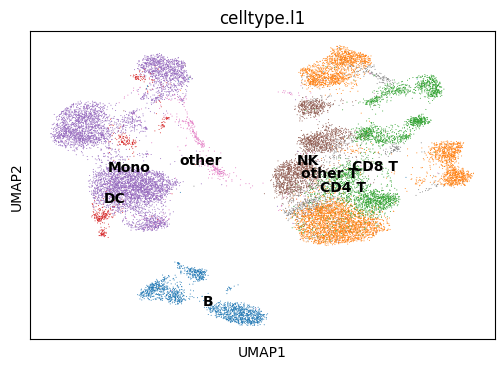

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


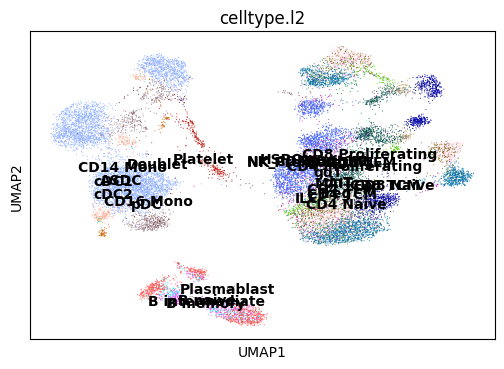

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


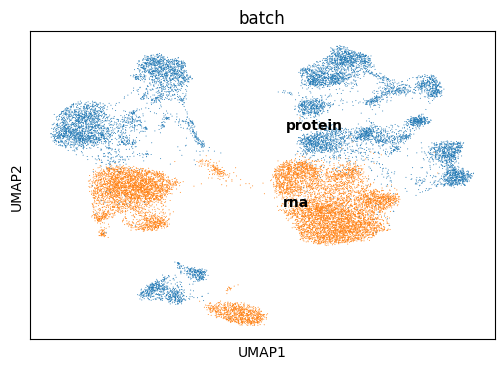

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.645,
lv2 matching acc: 0.461.
For All matchings: FOSCTTM score: 0.26445971, 
Knn Alignment score: [0.0009 0.0022 0.0033 0.0042 0.0049 0.006  0.0065 0.0076 0.0087 0.0098
 0.0109 0.0117 0.0125 0.013  0.0133 0.014  0.0147 0.0152 0.0159 0.0165
 0.0171 0.0182 0.0185 0.0193 0.0196]
For All matchings: Silhouette F1 score for lv1: 0.4847260712591144, 
Silhouette F1 score for lv2: 0.47337889620304147



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  5.584259271621704
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.698,
lv2 matching acc: 0.539.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.728,
lv2 matching acc: 0.504.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


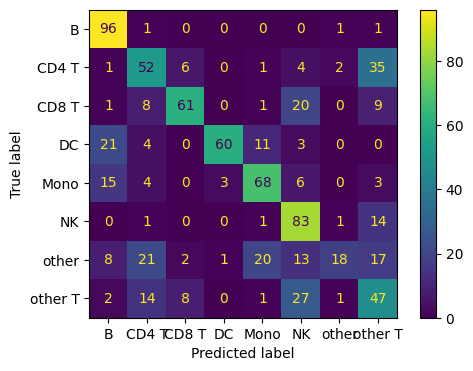

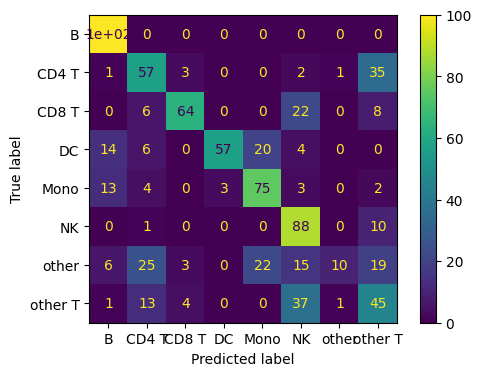

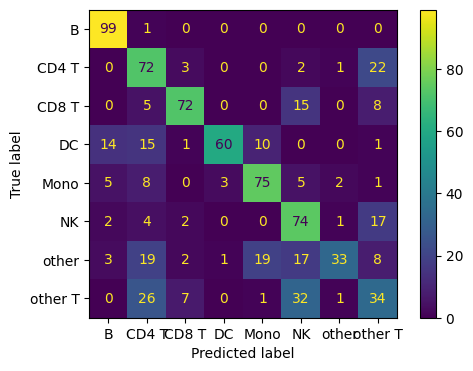

Epoch: 200: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 200: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.4558, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9444, Protein KL Div Z: 0.6291, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6414, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8207


Epoch: 201: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.4771, RNA KL Div L: 0.0168, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.4956, Protein KL Div Back Pro: 0.9435, Protein KL Div Z: 0.6280, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6391, Shared Recon Loss Gene: 0.2689, Shared Recon Loss Protein: 1.8232


Epoch: 202: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.4838, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4427, Protein Recon Loss: 0.4961, Protein KL Div Back Pro: 0.9425, Protein KL Div Z: 0.6287, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6401, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8242


Epoch: 203: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.4604, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4429, Protein Recon Loss: 0.4953, Protein KL Div Back Pro: 0.9389, Protein KL Div Z: 0.6263, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6389, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8207


Epoch: 204: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.4548, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4425, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.9408, Protein KL Div Z: 0.6275, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6384, Shared Recon Loss Gene: 0.2686, Shared Recon Loss Protein: 1.8219


Epoch: 205: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.4658, RNA KL Div L: 0.0169, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.9431, Protein KL Div Z: 0.6292, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6388, Shared Recon Loss Gene: 0.2677, Shared Recon Loss Protein: 1.8225


Epoch: 206: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.4352, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.9382, Protein KL Div Z: 0.6268, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6380, Shared Recon Loss Gene: 0.2694, Shared Recon Loss Protein: 1.8220


Epoch: 207: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.4287, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.9371, Protein KL Div Z: 0.6284, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6375, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8243


Epoch: 208: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.4571, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.9363, Protein KL Div Z: 0.6285, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6390, Shared Recon Loss Gene: 0.2690, Shared Recon Loss Protein: 1.8248


Epoch: 209: 40it [00:08,  4.91it/s]


RNA Recon Loss: 2.4353, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4948, Protein KL Div Back Pro: 0.9398, Protein KL Div Z: 0.6283, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6377, Shared Recon Loss Gene: 0.2688, Shared Recon Loss Protein: 1.8242


Epoch: 210: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.4439, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4937, Protein KL Div Back Pro: 0.9409, Protein KL Div Z: 0.6263, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6377, Shared Recon Loss Gene: 0.2684, Shared Recon Loss Protein: 1.8229


Epoch: 211: 40it [00:08,  4.48it/s]


RNA Recon Loss: 2.4492, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4938, Protein KL Div Back Pro: 0.9410, Protein KL Div Z: 0.6259, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6374, Shared Recon Loss Gene: 0.2698, Shared Recon Loss Protein: 1.8198


Epoch: 212: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.4612, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.9410, Protein KL Div Z: 0.6265, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6367, Shared Recon Loss Gene: 0.2692, Shared Recon Loss Protein: 1.8202


Epoch: 213: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.4359, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4966, Protein KL Div Back Pro: 0.9400, Protein KL Div Z: 0.6261, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6372, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8232


Epoch: 214: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.4372, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9385, Protein KL Div Z: 0.6248, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6357, Shared Recon Loss Gene: 0.2678, Shared Recon Loss Protein: 1.8176


Epoch: 215: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.4575, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4932, Protein KL Div Back Pro: 0.9412, Protein KL Div Z: 0.6260, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6350, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8213


Epoch: 216: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.4388, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.9385, Protein KL Div Z: 0.6248, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6365, Shared Recon Loss Gene: 0.2682, Shared Recon Loss Protein: 1.8235


Epoch: 217: 40it [00:08,  4.86it/s]


RNA Recon Loss: 2.4593, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.9394, Protein KL Div Z: 0.6251, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6345, Shared Recon Loss Gene: 0.2684, Shared Recon Loss Protein: 1.8211


Epoch: 218: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.5083, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.9430, Protein KL Div Z: 0.6268, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6349, Shared Recon Loss Gene: 0.2692, Shared Recon Loss Protein: 1.8182


Epoch: 219: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.4315, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4407, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.9395, Protein KL Div Z: 0.6239, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6349, Shared Recon Loss Gene: 0.2692, Shared Recon Loss Protein: 1.8191


Epoch: 220: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.4456, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4935, Protein KL Div Back Pro: 0.9396, Protein KL Div Z: 0.6240, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6340, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8167


Epoch: 221: 40it [00:09,  4.42it/s]


RNA Recon Loss: 2.4415, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4406, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.9357, Protein KL Div Z: 0.6215, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6328, Shared Recon Loss Gene: 0.2687, Shared Recon Loss Protein: 1.8166


Epoch: 222: 40it [00:09,  4.16it/s]


RNA Recon Loss: 2.4414, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4412, Protein Recon Loss: 0.4943, Protein KL Div Back Pro: 0.9338, Protein KL Div Z: 0.6225, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6330, Shared Recon Loss Gene: 0.2696, Shared Recon Loss Protein: 1.8208


Epoch: 223: 40it [00:09,  4.10it/s]


RNA Recon Loss: 2.4128, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.4954, Protein KL Div Back Pro: 0.9355, Protein KL Div Z: 0.6235, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6328, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8212


Epoch: 224: 40it [00:09,  4.03it/s]


RNA Recon Loss: 2.4733, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4413, Protein Recon Loss: 0.4934, Protein KL Div Back Pro: 0.9331, Protein KL Div Z: 0.6223, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6346, Shared Recon Loss Gene: 0.2680, Shared Recon Loss Protein: 1.8193


Epoch: 225: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.5096, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4938, Protein KL Div Back Pro: 0.9348, Protein KL Div Z: 0.6215, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6321, Shared Recon Loss Gene: 0.2695, Shared Recon Loss Protein: 1.8229


Epoch: 226: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.4874, RNA KL Div L: 0.0167, RNA KL Div Z: 0.4408, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.9347, Protein KL Div Z: 0.6226, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6320, Shared Recon Loss Gene: 0.2684, Shared Recon Loss Protein: 1.8191


Epoch: 227: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.4364, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4950, Protein KL Div Back Pro: 0.9357, Protein KL Div Z: 0.6222, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6307, Shared Recon Loss Gene: 0.2684, Shared Recon Loss Protein: 1.8283


Epoch: 228: 40it [00:08,  4.81it/s]


RNA Recon Loss: 2.4388, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4425, Protein Recon Loss: 0.4944, Protein KL Div Back Pro: 0.9338, Protein KL Div Z: 0.6226, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6317, Shared Recon Loss Gene: 0.2690, Shared Recon Loss Protein: 1.8218


Epoch: 229: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.4025, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.9342, Protein KL Div Z: 0.6228, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6304, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8208


Epoch: 230: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.4583, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4403, Protein Recon Loss: 0.4939, Protein KL Div Back Pro: 0.9293, Protein KL Div Z: 0.6213, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6296, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8184


Epoch: 231: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.4571, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.9360, Protein KL Div Z: 0.6233, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6302, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8186


Epoch: 232: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.4391, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.4940, Protein KL Div Back Pro: 0.9387, Protein KL Div Z: 0.6229, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6279, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8189


Epoch: 233: 40it [00:09,  4.30it/s]


RNA Recon Loss: 2.4237, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.9348, Protein KL Div Z: 0.6218, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6306, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8162


Epoch: 234: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.5064, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4411, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9353, Protein KL Div Z: 0.6210, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6291, Shared Recon Loss Gene: 0.2689, Shared Recon Loss Protein: 1.8152


Epoch: 235: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.4093, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.9359, Protein KL Div Z: 0.6200, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6266, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8204


Epoch: 236: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.4482, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4948, Protein KL Div Back Pro: 0.9392, Protein KL Div Z: 0.6230, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6293, Shared Recon Loss Gene: 0.2677, Shared Recon Loss Protein: 1.8188


Epoch: 237: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.4244, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4942, Protein KL Div Back Pro: 0.9359, Protein KL Div Z: 0.6199, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6288, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8185


Epoch: 238: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.4073, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4419, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9359, Protein KL Div Z: 0.6217, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6278, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8176


Epoch: 239: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.4249, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.9312, Protein KL Div Z: 0.6219, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6286, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8209


Epoch: 240: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.4325, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.9292, Protein KL Div Z: 0.6210, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6265, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8196


Epoch: 241: 40it [00:07,  5.00it/s]


RNA Recon Loss: 2.4099, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4418, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.9345, Protein KL Div Z: 0.6219, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6272, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8171


Epoch: 242: 40it [00:08,  4.81it/s]


RNA Recon Loss: 2.4329, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4945, Protein KL Div Back Pro: 0.9345, Protein KL Div Z: 0.6212, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6255, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8245


Epoch: 243: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.4050, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4420, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9351, Protein KL Div Z: 0.6219, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6264, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8152


Epoch: 244: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.4037, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.9298, Protein KL Div Z: 0.6213, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6249, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8200


Epoch: 245: 40it [00:08,  4.45it/s]


RNA Recon Loss: 2.3934, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4423, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.9276, Protein KL Div Z: 0.6214, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6269, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8178


Epoch: 246: 40it [00:09,  4.25it/s]


RNA Recon Loss: 2.4558, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4417, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.9280, Protein KL Div Z: 0.6209, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6260, Shared Recon Loss Gene: 0.2683, Shared Recon Loss Protein: 1.8202


Epoch: 247: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.4259, RNA KL Div L: 0.0165, RNA KL Div Z: 0.4414, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.9269, Protein KL Div Z: 0.6224, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6213, Shared Recon Loss Gene: 0.2675, Shared Recon Loss Protein: 1.8229


Epoch: 248: 40it [00:08,  4.72it/s]


RNA Recon Loss: 2.3832, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4422, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9277, Protein KL Div Z: 0.6200, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6230, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8181


Epoch: 249: 40it [00:08,  4.91it/s]


RNA Recon Loss: 2.4117, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4410, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.9256, Protein KL Div Z: 0.6187, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6219, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8194


Epoch: 250: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.4078, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4409, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9279, Protein KL Div Z: 0.6188, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6230, Shared Recon Loss Gene: 0.2673, Shared Recon Loss Protein: 1.8137


Epoch: 251: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.4342, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4429, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.9265, Protein KL Div Z: 0.6186, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6234, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8148


Epoch: 252: 40it [00:09,  4.05it/s]


RNA Recon Loss: 2.3897, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.9258, Protein KL Div Z: 0.6181, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6238, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8140


Epoch: 253: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.4127, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4415, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.9261, Protein KL Div Z: 0.6182, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6230, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8133


Epoch: 254: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.4144, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4421, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9299, Protein KL Div Z: 0.6186, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6238, Shared Recon Loss Gene: 0.2683, Shared Recon Loss Protein: 1.8146


Epoch: 255: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.4325, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4429, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.9347, Protein KL Div Z: 0.6179, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6232, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8189


Epoch: 256: 40it [00:08,  4.86it/s]


RNA Recon Loss: 2.4381, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4433, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9310, Protein KL Div Z: 0.6175, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6210, Shared Recon Loss Gene: 0.2679, Shared Recon Loss Protein: 1.8204


Epoch: 257: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.4125, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4424, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.9283, Protein KL Div Z: 0.6165, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6232, Shared Recon Loss Gene: 0.2671, Shared Recon Loss Protein: 1.8173


Epoch: 258: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.4776, RNA KL Div L: 0.0166, RNA KL Div Z: 0.4428, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9303, Protein KL Div Z: 0.6165, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6224, Shared Recon Loss Gene: 0.2662, Shared Recon Loss Protein: 1.8161


Epoch: 259: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.5046, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4416, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9311, Protein KL Div Z: 0.6173, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6213, Shared Recon Loss Gene: 0.2661, Shared Recon Loss Protein: 1.8184


Epoch: 260: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.4774, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9317, Protein KL Div Z: 0.6179, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6223, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8162


Epoch: 261: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.4002, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4430, Protein Recon Loss: 0.4947, Protein KL Div Back Pro: 0.9288, Protein KL Div Z: 0.6157, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6198, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8188


Epoch: 262: 40it [00:10,  3.99it/s]


RNA Recon Loss: 2.3858, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.4928, Protein KL Div Back Pro: 0.9281, Protein KL Div Z: 0.6144, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6177, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8224


Epoch: 263: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.4531, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4454, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.9313, Protein KL Div Z: 0.6177, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6153, Shared Recon Loss Gene: 0.2691, Shared Recon Loss Protein: 1.8287


Epoch: 264: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.4305, RNA KL Div L: 0.0164, RNA KL Div Z: 0.4452, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.9281, Protein KL Div Z: 0.6176, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6184, Shared Recon Loss Gene: 0.2663, Shared Recon Loss Protein: 1.8154


Epoch: 265: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.3902, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4441, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.9277, Protein KL Div Z: 0.6168, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6180, Shared Recon Loss Gene: 0.2669, Shared Recon Loss Protein: 1.8143


Epoch: 266: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.4153, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4444, Protein Recon Loss: 0.4940, Protein KL Div Back Pro: 0.9264, Protein KL Div Z: 0.6156, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6172, Shared Recon Loss Gene: 0.2668, Shared Recon Loss Protein: 1.8133


Epoch: 267: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.3981, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4444, Protein Recon Loss: 0.4930, Protein KL Div Back Pro: 0.9280, Protein KL Div Z: 0.6170, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6177, Shared Recon Loss Gene: 0.2670, Shared Recon Loss Protein: 1.8170


Epoch: 268: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.3784, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4436, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.9280, Protein KL Div Z: 0.6161, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6173, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8156


Epoch: 269: 40it [00:07,  5.30it/s]


RNA Recon Loss: 2.3828, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4435, Protein Recon Loss: 0.4951, Protein KL Div Back Pro: 0.9275, Protein KL Div Z: 0.6153, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6157, Shared Recon Loss Gene: 0.2674, Shared Recon Loss Protein: 1.8196


Epoch: 270: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.3916, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4430, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9279, Protein KL Div Z: 0.6166, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6164, Shared Recon Loss Gene: 0.2667, Shared Recon Loss Protein: 1.8145


Epoch: 271: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.3980, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4435, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9280, Protein KL Div Z: 0.6158, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6170, Shared Recon Loss Gene: 0.2669, Shared Recon Loss Protein: 1.8171


Epoch: 272: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.3745, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4439, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9290, Protein KL Div Z: 0.6162, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6183, Shared Recon Loss Gene: 0.2661, Shared Recon Loss Protein: 1.8159


Epoch: 273: 40it [00:07,  5.28it/s]


RNA Recon Loss: 2.4013, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4434, Protein Recon Loss: 0.4929, Protein KL Div Back Pro: 0.9254, Protein KL Div Z: 0.6154, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6165, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8196


Epoch: 274: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.4045, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4445, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.9265, Protein KL Div Z: 0.6160, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6138, Shared Recon Loss Gene: 0.2676, Shared Recon Loss Protein: 1.8144


Epoch: 275: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.3620, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4447, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.9269, Protein KL Div Z: 0.6158, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6154, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8161


Epoch: 276: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.3673, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4450, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.9197, Protein KL Div Z: 0.6127, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6152, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8161


Epoch: 277: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.3632, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4443, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.9194, Protein KL Div Z: 0.6132, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6143, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8161


Epoch: 278: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.4276, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4440, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9200, Protein KL Div Z: 0.6135, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6135, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8140


Epoch: 279: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.4739, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4448, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.9235, Protein KL Div Z: 0.6136, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6146, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8123


Epoch: 280: 40it [00:07,  5.30it/s]


RNA Recon Loss: 2.3871, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4446, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9248, Protein KL Div Z: 0.6128, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6129, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8140


Epoch: 281: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.4067, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4448, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9250, Protein KL Div Z: 0.6121, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6132, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8168


Epoch: 282: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.4066, RNA KL Div L: 0.0163, RNA KL Div Z: 0.4448, Protein Recon Loss: 0.4923, Protein KL Div Back Pro: 0.9244, Protein KL Div Z: 0.6122, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6142, Shared Recon Loss Gene: 0.2657, Shared Recon Loss Protein: 1.8149


Epoch: 283: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.4378, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4442, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.9190, Protein KL Div Z: 0.6104, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6140, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8138


Epoch: 284: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.3682, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4449, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.9226, Protein KL Div Z: 0.6124, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6135, Shared Recon Loss Gene: 0.2657, Shared Recon Loss Protein: 1.8154


Epoch: 285: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.3872, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4450, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.9236, Protein KL Div Z: 0.6104, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6134, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8146


Epoch: 286: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.4015, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4445, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.9252, Protein KL Div Z: 0.6105, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6122, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8145


Epoch: 287: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.4327, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4455, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9212, Protein KL Div Z: 0.6095, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6110, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8134


Epoch: 288: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.3735, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4459, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9223, Protein KL Div Z: 0.6105, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6113, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8153


Epoch: 289: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.3688, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4455, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9198, Protein KL Div Z: 0.6105, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6120, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8132


Epoch: 290: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.3687, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4457, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.9209, Protein KL Div Z: 0.6105, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6091, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8142


Epoch: 291: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.3553, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4457, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9200, Protein KL Div Z: 0.6101, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6089, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8146


Epoch: 292: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.3972, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4458, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.9186, Protein KL Div Z: 0.6104, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6108, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8150


Epoch: 293: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.3809, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4460, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9193, Protein KL Div Z: 0.6095, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6090, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8156


Epoch: 294: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.3604, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4458, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9157, Protein KL Div Z: 0.6078, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6094, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8124


Epoch: 295: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.3785, RNA KL Div L: 0.0162, RNA KL Div Z: 0.4468, Protein Recon Loss: 0.4917, Protein KL Div Back Pro: 0.9147, Protein KL Div Z: 0.6084, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6088, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8123


Epoch: 296: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.4203, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4466, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.9185, Protein KL Div Z: 0.6078, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6080, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8124


Epoch: 297: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.3642, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4467, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9181, Protein KL Div Z: 0.6065, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6069, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8112


Epoch: 298: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.3605, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4465, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9192, Protein KL Div Z: 0.6085, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6079, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8140


Epoch: 299: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.3553, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4464, Protein Recon Loss: 0.4924, Protein KL Div Back Pro: 0.9201, Protein KL Div Z: 0.6078, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6083, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8136


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


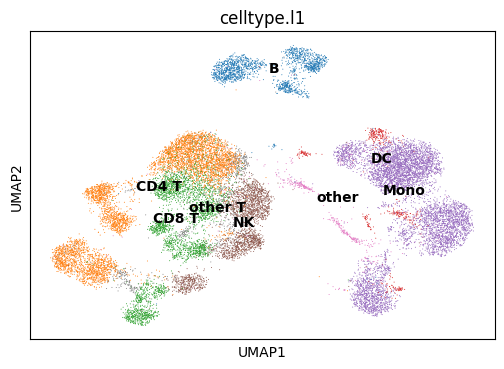

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


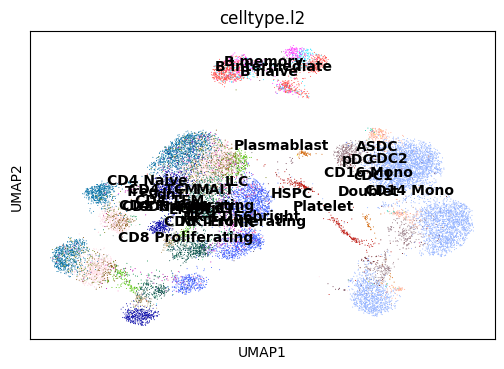

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


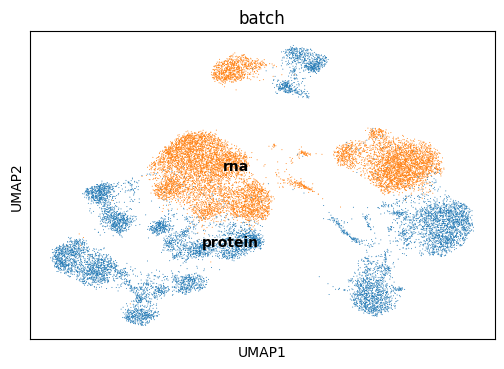

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.756,
lv2 matching acc: 0.498.
For All matchings: FOSCTTM score: 0.26745607, 
Knn Alignment score: [0.0013 0.0025 0.0038 0.005  0.0062 0.0071 0.0079 0.0091 0.0099 0.0106
 0.0116 0.0124 0.0132 0.0139 0.0148 0.0162 0.0168 0.017  0.0182 0.0186
 0.0198 0.0205 0.0211 0.0222 0.023 ]
For All matchings: Silhouette F1 score for lv1: 0.49024352044300123, 
Silhouette F1 score for lv2: 0.47841614687455064



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  5.207346200942993
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.823,
lv2 matching acc: 0.570.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.787,
lv2 matching acc: 0.529.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


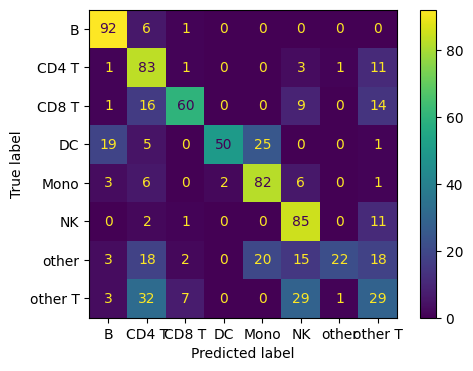

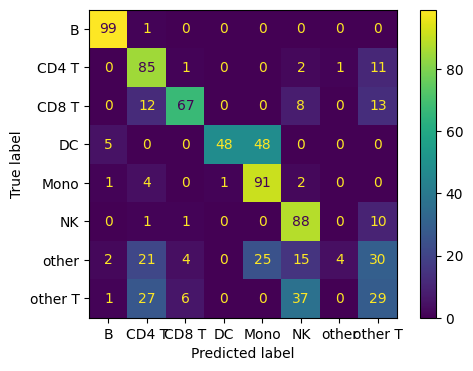

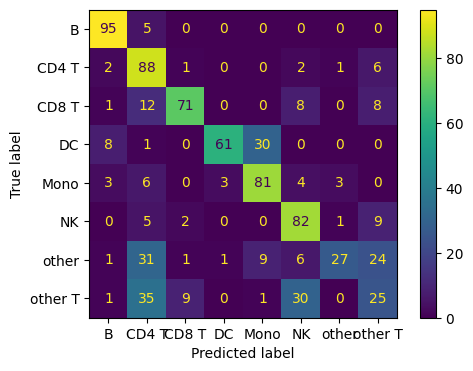

Epoch: 300: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 300: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.3976, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4464, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9192, Protein KL Div Z: 0.6086, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6076, Shared Recon Loss Gene: 0.2664, Shared Recon Loss Protein: 1.8102


Epoch: 301: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.3771, RNA KL Div L: 0.0161, RNA KL Div Z: 0.4461, Protein Recon Loss: 0.4908, Protein KL Div Back Pro: 0.9175, Protein KL Div Z: 0.6077, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6072, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8119


Epoch: 302: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.3733, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4463, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9167, Protein KL Div Z: 0.6078, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6086, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8127


Epoch: 303: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.3444, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4471, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9146, Protein KL Div Z: 0.6072, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6060, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8122


Epoch: 304: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.3360, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4466, Protein Recon Loss: 0.4941, Protein KL Div Back Pro: 0.9150, Protein KL Div Z: 0.6080, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6075, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8117


Epoch: 305: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.3388, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4466, Protein Recon Loss: 0.4925, Protein KL Div Back Pro: 0.9175, Protein KL Div Z: 0.6071, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6067, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8097


Epoch: 306: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.3442, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4463, Protein Recon Loss: 0.4909, Protein KL Div Back Pro: 0.9184, Protein KL Div Z: 0.6072, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6073, Shared Recon Loss Gene: 0.2665, Shared Recon Loss Protein: 1.8113


Epoch: 307: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.3618, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4467, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.9198, Protein KL Div Z: 0.6069, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6063, Shared Recon Loss Gene: 0.2652, Shared Recon Loss Protein: 1.8124


Epoch: 308: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.3636, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4464, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9213, Protein KL Div Z: 0.6059, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6042, Shared Recon Loss Gene: 0.2655, Shared Recon Loss Protein: 1.8180


Epoch: 309: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.3411, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4904, Protein KL Div Back Pro: 0.9220, Protein KL Div Z: 0.6057, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6047, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8084


Epoch: 310: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.3463, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4485, Protein Recon Loss: 0.4903, Protein KL Div Back Pro: 0.9216, Protein KL Div Z: 0.6051, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6032, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8113


Epoch: 311: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.3496, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4489, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9176, Protein KL Div Z: 0.6038, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8119


Epoch: 312: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.3400, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4487, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9186, Protein KL Div Z: 0.6047, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6026, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8149


Epoch: 313: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.3340, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4491, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9168, Protein KL Div Z: 0.6038, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8108


Epoch: 314: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.3363, RNA KL Div L: 0.0160, RNA KL Div Z: 0.4486, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9193, Protein KL Div Z: 0.6040, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6028, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8119


Epoch: 315: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.3441, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4479, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9186, Protein KL Div Z: 0.6044, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6006, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8181


Epoch: 316: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.3373, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9184, Protein KL Div Z: 0.6039, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6059, Shared Recon Loss Gene: 0.2653, Shared Recon Loss Protein: 1.8134


Epoch: 317: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.3470, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.4926, Protein KL Div Back Pro: 0.9161, Protein KL Div Z: 0.6036, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6014, Shared Recon Loss Gene: 0.2659, Shared Recon Loss Protein: 1.8139


Epoch: 318: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.3460, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4495, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9180, Protein KL Div Z: 0.6030, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5987, Shared Recon Loss Gene: 0.2651, Shared Recon Loss Protein: 1.8146


Epoch: 319: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.3441, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.9140, Protein KL Div Z: 0.6010, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6012, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8116


Epoch: 320: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.3267, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9170, Protein KL Div Z: 0.6039, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5995, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8145


Epoch: 321: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.3452, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4504, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9165, Protein KL Div Z: 0.6033, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5999, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8106


Epoch: 322: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.3479, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4496, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9154, Protein KL Div Z: 0.6026, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.6004, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8097


Epoch: 323: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.3340, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4493, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.9178, Protein KL Div Z: 0.6029, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5978, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8099


Epoch: 324: 40it [00:07,  5.28it/s]


RNA Recon Loss: 2.3351, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.9187, Protein KL Div Z: 0.6026, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5981, Shared Recon Loss Gene: 0.2660, Shared Recon Loss Protein: 1.8111


Epoch: 325: 40it [00:08,  4.76it/s]


RNA Recon Loss: 2.3435, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4494, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.9174, Protein KL Div Z: 0.6025, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5977, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8144


Epoch: 326: 40it [00:10,  3.96it/s]


RNA Recon Loss: 2.3312, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4491, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.9145, Protein KL Div Z: 0.6010, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5974, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8100


Epoch: 327: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.3203, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4495, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.9125, Protein KL Div Z: 0.6012, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5978, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8110


Epoch: 328: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.3336, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4505, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9101, Protein KL Div Z: 0.6012, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5981, Shared Recon Loss Gene: 0.2648, Shared Recon Loss Protein: 1.8095


Epoch: 329: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.3382, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4496, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.9096, Protein KL Div Z: 0.6009, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5972, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8103


Epoch: 330: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.3276, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4483, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9082, Protein KL Div Z: 0.6000, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5975, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8108


Epoch: 331: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.3033, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4498, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.9082, Protein KL Div Z: 0.5990, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5982, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8105


Epoch: 332: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.3115, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4492, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.9087, Protein KL Div Z: 0.5975, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5973, Shared Recon Loss Gene: 0.2644, Shared Recon Loss Protein: 1.8092


Epoch: 333: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.3230, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4491, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.9093, Protein KL Div Z: 0.5995, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5961, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8124


Epoch: 334: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.3719, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9099, Protein KL Div Z: 0.5987, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5974, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8130


Epoch: 335: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.3102, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.9127, Protein KL Div Z: 0.5980, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5971, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8099


Epoch: 336: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.2991, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.9113, Protein KL Div Z: 0.5982, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5965, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8110


Epoch: 337: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.3097, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9117, Protein KL Div Z: 0.5975, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5961, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8082


Epoch: 338: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.3400, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9115, Protein KL Div Z: 0.5965, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5942, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8134


Epoch: 339: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.3228, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.9106, Protein KL Div Z: 0.5960, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5957, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8106


Epoch: 340: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.3212, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.9111, Protein KL Div Z: 0.5974, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5948, Shared Recon Loss Gene: 0.2650, Shared Recon Loss Protein: 1.8092


Epoch: 341: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.3020, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.4910, Protein KL Div Back Pro: 0.9090, Protein KL Div Z: 0.5955, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5929, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8122


Epoch: 342: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.3022, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4486, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9104, Protein KL Div Z: 0.5959, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5943, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8084


Epoch: 343: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.3013, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4488, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.9119, Protein KL Div Z: 0.5960, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5936, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8089


Epoch: 344: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.3235, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.9145, Protein KL Div Z: 0.5961, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5918, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8094


Epoch: 345: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.3138, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9104, Protein KL Div Z: 0.5937, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5921, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8119


Epoch: 346: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.3050, RNA KL Div L: 0.0159, RNA KL Div Z: 0.4496, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9080, Protein KL Div Z: 0.5938, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5913, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8081


Epoch: 347: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.3178, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.9074, Protein KL Div Z: 0.5935, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5909, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8090


Epoch: 348: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.2989, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.9080, Protein KL Div Z: 0.5932, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5932, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8084


Epoch: 349: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.3140, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4507, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9099, Protein KL Div Z: 0.5952, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5920, Shared Recon Loss Gene: 0.2654, Shared Recon Loss Protein: 1.8139


Epoch: 350: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.3052, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4503, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.9077, Protein KL Div Z: 0.5942, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5907, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8116


Epoch: 351: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.3009, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.9059, Protein KL Div Z: 0.5941, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5892, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8130


Epoch: 352: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.3074, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4919, Protein KL Div Back Pro: 0.9066, Protein KL Div Z: 0.5938, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5896, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8137


Epoch: 353: 40it [00:07,  5.00it/s]


RNA Recon Loss: 2.2966, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.9083, Protein KL Div Z: 0.5943, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5908, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8148


Epoch: 354: 40it [00:08,  5.00it/s]


RNA Recon Loss: 2.2892, RNA KL Div L: 0.0158, RNA KL Div Z: 0.4500, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.9080, Protein KL Div Z: 0.5948, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5884, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8137


Epoch: 355: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.2964, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4502, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.9093, Protein KL Div Z: 0.5942, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5882, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8166


Epoch: 356: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.2873, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4504, Protein Recon Loss: 0.4920, Protein KL Div Back Pro: 0.9095, Protein KL Div Z: 0.5939, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5896, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8123


Epoch: 357: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.2858, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.9088, Protein KL Div Z: 0.5942, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5890, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8114


Epoch: 358: 40it [00:08,  4.94it/s]


RNA Recon Loss: 2.2977, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4502, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.9075, Protein KL Div Z: 0.5918, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5868, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8135


Epoch: 359: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.2889, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4495, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.9066, Protein KL Div Z: 0.5919, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5867, Shared Recon Loss Gene: 0.2646, Shared Recon Loss Protein: 1.8078


Epoch: 360: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.2966, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.9077, Protein KL Div Z: 0.5927, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5869, Shared Recon Loss Gene: 0.2638, Shared Recon Loss Protein: 1.8095


Epoch: 361: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2789, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9127, Protein KL Div Z: 0.5930, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5870, Shared Recon Loss Gene: 0.2639, Shared Recon Loss Protein: 1.8119


Epoch: 362: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2905, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4501, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.9114, Protein KL Div Z: 0.5917, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5861, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8078


Epoch: 363: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.3012, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4502, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9087, Protein KL Div Z: 0.5910, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5851, Shared Recon Loss Gene: 0.2642, Shared Recon Loss Protein: 1.8081


Epoch: 364: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.2977, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4499, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9061, Protein KL Div Z: 0.5920, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5848, Shared Recon Loss Gene: 0.2643, Shared Recon Loss Protein: 1.8094


Epoch: 365: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2693, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4497, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.9071, Protein KL Div Z: 0.5904, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5859, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8099


Epoch: 366: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.2936, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4507, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.9108, Protein KL Div Z: 0.5910, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5856, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8115


Epoch: 367: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.2888, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.9108, Protein KL Div Z: 0.5900, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5862, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8085


Epoch: 368: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2921, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4505, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.9116, Protein KL Div Z: 0.5903, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5857, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8114


Epoch: 369: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.2886, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4512, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.9042, Protein KL Div Z: 0.5902, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5868, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8114


Epoch: 370: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2914, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4514, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.9048, Protein KL Div Z: 0.5889, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5858, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8104


Epoch: 371: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.2686, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4506, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.9066, Protein KL Div Z: 0.5889, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5844, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8081


Epoch: 372: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2846, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4513, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9063, Protein KL Div Z: 0.5890, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5860, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8123


Epoch: 373: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.2930, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4523, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.9051, Protein KL Div Z: 0.5877, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5845, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8068


Epoch: 374: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.2872, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4530, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.9097, Protein KL Div Z: 0.5889, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5837, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8079


Epoch: 375: 40it [00:08,  4.70it/s]


RNA Recon Loss: 2.2826, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4905, Protein KL Div Back Pro: 0.9070, Protein KL Div Z: 0.5867, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5831, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8087


Epoch: 376: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.2956, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4533, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9079, Protein KL Div Z: 0.5893, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5843, Shared Recon Loss Gene: 0.2649, Shared Recon Loss Protein: 1.8085


Epoch: 377: 40it [00:09,  4.28it/s]


RNA Recon Loss: 2.2979, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4936, Protein KL Div Back Pro: 0.9089, Protein KL Div Z: 0.5904, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5844, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8101


Epoch: 378: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.2978, RNA KL Div L: 0.0157, RNA KL Div Z: 0.4537, Protein Recon Loss: 0.4922, Protein KL Div Back Pro: 0.9080, Protein KL Div Z: 0.5900, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5828, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8100


Epoch: 379: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.2834, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4529, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9091, Protein KL Div Z: 0.5905, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5811, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8176


Epoch: 380: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.2659, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4526, Protein Recon Loss: 0.4915, Protein KL Div Back Pro: 0.9079, Protein KL Div Z: 0.5894, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5851, Shared Recon Loss Gene: 0.2656, Shared Recon Loss Protein: 1.8215


Epoch: 381: 40it [00:08,  4.47it/s]


RNA Recon Loss: 2.2518, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4524, Protein Recon Loss: 0.4913, Protein KL Div Back Pro: 0.9105, Protein KL Div Z: 0.5892, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5839, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8090


Epoch: 382: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.2604, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4527, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9094, Protein KL Div Z: 0.5886, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5834, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8067


Epoch: 383: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.2645, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4532, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.9097, Protein KL Div Z: 0.5889, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5834, Shared Recon Loss Gene: 0.2634, Shared Recon Loss Protein: 1.8061


Epoch: 384: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.2704, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4532, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9060, Protein KL Div Z: 0.5876, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5832, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8085


Epoch: 385: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.2603, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4534, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.9056, Protein KL Div Z: 0.5883, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5831, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8081


Epoch: 386: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2655, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.9041, Protein KL Div Z: 0.5890, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5822, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8072


Epoch: 387: 40it [00:08,  4.78it/s]


RNA Recon Loss: 2.2525, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4533, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.9016, Protein KL Div Z: 0.5881, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5817, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8079


Epoch: 388: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.2517, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4540, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.9019, Protein KL Div Z: 0.5876, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5809, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8079


Epoch: 389: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.2708, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4536, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.9028, Protein KL Div Z: 0.5878, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5808, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8081


Epoch: 390: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.2632, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4531, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.9028, Protein KL Div Z: 0.5868, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5801, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8062


Epoch: 391: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.2674, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4542, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9021, Protein KL Div Z: 0.5868, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5796, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8084


Epoch: 392: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.2739, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4535, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.9015, Protein KL Div Z: 0.5850, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5804, Shared Recon Loss Gene: 0.2641, Shared Recon Loss Protein: 1.8076


Epoch: 393: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.2739, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4558, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.9023, Protein KL Div Z: 0.5858, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5783, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8126


Epoch: 394: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.2568, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4564, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8995, Protein KL Div Z: 0.5854, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5790, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8105


Epoch: 395: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.2623, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4565, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8984, Protein KL Div Z: 0.5845, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5782, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8069


Epoch: 396: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.2561, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4567, Protein Recon Loss: 0.4914, Protein KL Div Back Pro: 0.8994, Protein KL Div Z: 0.5858, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5775, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8143


Epoch: 397: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.2598, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4560, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.9019, Protein KL Div Z: 0.5853, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5800, Shared Recon Loss Gene: 0.2644, Shared Recon Loss Protein: 1.8161


Epoch: 398: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.2428, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4565, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.9034, Protein KL Div Z: 0.5857, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5766, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8137


Epoch: 399: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.2616, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4563, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.9036, Protein KL Div Z: 0.5854, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5766, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8054


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


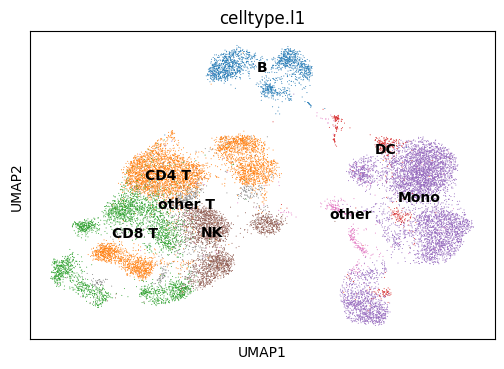

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


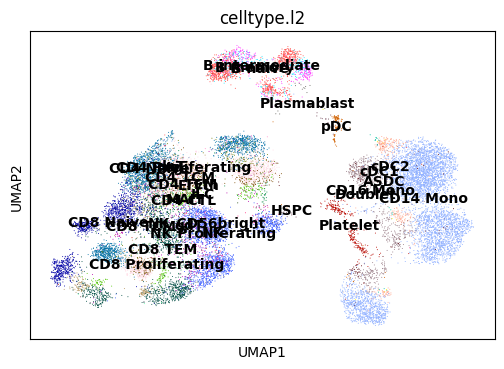

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


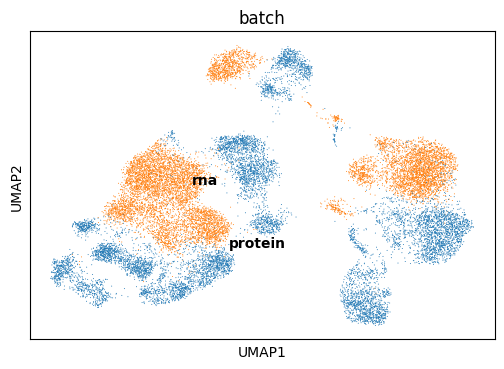

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.743,
lv2 matching acc: 0.542.
For All matchings: FOSCTTM score: 0.25045259, 
Knn Alignment score: [0.0012 0.002  0.003  0.0044 0.0055 0.0067 0.008  0.0091 0.0106 0.0118
 0.0129 0.0139 0.0144 0.0153 0.0163 0.0176 0.0182 0.0187 0.0196 0.0201
 0.0208 0.0216 0.0221 0.0233 0.0243]
For All matchings: Silhouette F1 score for lv1: 0.49905614253481434, 
Silhouette F1 score for lv2: 0.4877503435335161



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  4.82140588760376
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.821,
lv2 matching acc: 0.636.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.774,
lv2 matching acc: 0.559.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


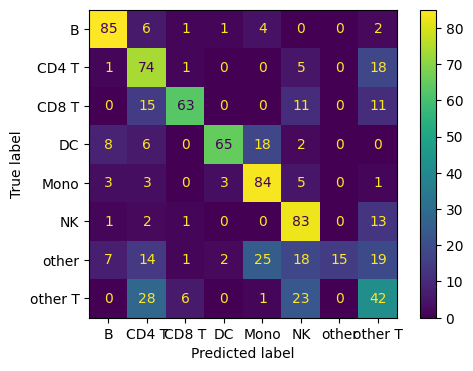

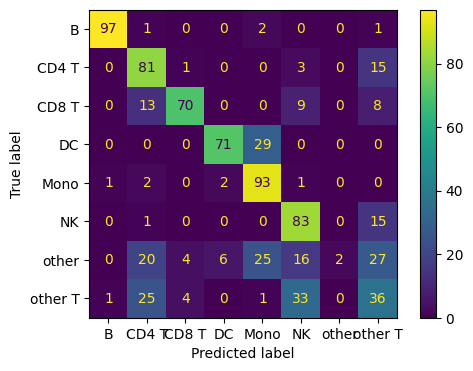

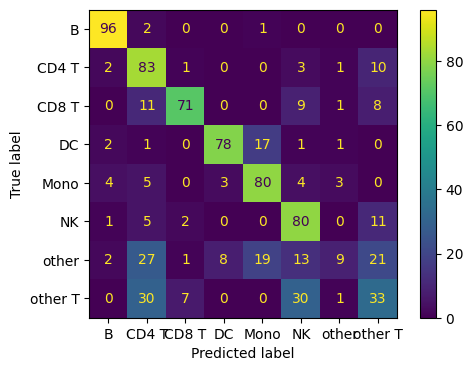

Epoch: 400: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 400: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2586, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4556, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.9047, Protein KL Div Z: 0.5854, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5771, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8043


Epoch: 401: 40it [00:08,  4.91it/s]


RNA Recon Loss: 2.2804, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4569, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.9040, Protein KL Div Z: 0.5847, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5760, Shared Recon Loss Gene: 0.2645, Shared Recon Loss Protein: 1.8055


Epoch: 402: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.2808, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4567, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.9032, Protein KL Div Z: 0.5847, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5761, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8084


Epoch: 403: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.2621, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4564, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.9025, Protein KL Div Z: 0.5852, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5764, Shared Recon Loss Gene: 0.2632, Shared Recon Loss Protein: 1.8080


Epoch: 404: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.3223, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4579, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.9013, Protein KL Div Z: 0.5841, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5762, Shared Recon Loss Gene: 0.2658, Shared Recon Loss Protein: 1.8083


Epoch: 405: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.2798, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4576, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.9068, Protein KL Div Z: 0.5854, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5734, Shared Recon Loss Gene: 0.2636, Shared Recon Loss Protein: 1.8088


Epoch: 406: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.2685, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4576, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.9033, Protein KL Div Z: 0.5843, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5739, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8051


Epoch: 407: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.2415, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4587, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.9006, Protein KL Div Z: 0.5835, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5743, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8056


Epoch: 408: 40it [00:08,  4.86it/s]


RNA Recon Loss: 2.2444, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4574, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8997, Protein KL Div Z: 0.5839, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5718, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8077


Epoch: 409: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2427, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4571, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8980, Protein KL Div Z: 0.5825, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5722, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8063


Epoch: 410: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2797, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4571, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8989, Protein KL Div Z: 0.5831, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5727, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8226


Epoch: 411: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.3079, RNA KL Div L: 0.0156, RNA KL Div Z: 0.4566, Protein Recon Loss: 0.4933, Protein KL Div Back Pro: 0.9015, Protein KL Div Z: 0.5839, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5794, Shared Recon Loss Gene: 0.2686, Shared Recon Loss Protein: 1.8387


Epoch: 412: 40it [00:07,  5.28it/s]


RNA Recon Loss: 2.2562, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4576, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8981, Protein KL Div Z: 0.5831, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5753, Shared Recon Loss Gene: 0.2647, Shared Recon Loss Protein: 1.8085


Epoch: 413: 40it [00:08,  4.94it/s]


RNA Recon Loss: 2.2512, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4570, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8970, Protein KL Div Z: 0.5820, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5750, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8100


Epoch: 414: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.2458, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4579, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8987, Protein KL Div Z: 0.5831, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5755, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8103


Epoch: 415: 40it [00:07,  5.03it/s]


RNA Recon Loss: 2.2770, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4578, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8996, Protein KL Div Z: 0.5837, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5748, Shared Recon Loss Gene: 0.2640, Shared Recon Loss Protein: 1.8096


Epoch: 416: 40it [00:07,  5.03it/s]


RNA Recon Loss: 2.2597, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4574, Protein Recon Loss: 0.4891, Protein KL Div Back Pro: 0.8973, Protein KL Div Z: 0.5829, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5756, Shared Recon Loss Gene: 0.2635, Shared Recon Loss Protein: 1.8079


Epoch: 417: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.2456, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4576, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8967, Protein KL Div Z: 0.5834, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5736, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8051


Epoch: 418: 40it [00:07,  5.30it/s]


RNA Recon Loss: 2.2399, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4575, Protein Recon Loss: 0.4881, Protein KL Div Back Pro: 0.8973, Protein KL Div Z: 0.5828, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5745, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8060


Epoch: 419: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2423, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4571, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8969, Protein KL Div Z: 0.5818, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5732, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8060


Epoch: 420: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2417, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4586, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8975, Protein KL Div Z: 0.5822, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5728, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8120


Epoch: 421: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.2579, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4583, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8945, Protein KL Div Z: 0.5818, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5721, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8096


Epoch: 422: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2532, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4588, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8955, Protein KL Div Z: 0.5813, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5714, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8068


Epoch: 423: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.2343, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8968, Protein KL Div Z: 0.5818, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5719, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8078


Epoch: 424: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.2433, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4584, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8953, Protein KL Div Z: 0.5809, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5713, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8060


Epoch: 425: 40it [00:08,  4.91it/s]


RNA Recon Loss: 2.2410, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8969, Protein KL Div Z: 0.5807, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5698, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8049


Epoch: 426: 40it [00:09,  4.05it/s]


RNA Recon Loss: 2.2383, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8954, Protein KL Div Z: 0.5796, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5697, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8038


Epoch: 427: 40it [00:08,  4.83it/s]


RNA Recon Loss: 2.2347, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4594, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8963, Protein KL Div Z: 0.5804, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5704, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8076


Epoch: 428: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.2327, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4591, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8960, Protein KL Div Z: 0.5805, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5695, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8052


Epoch: 429: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.2473, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8934, Protein KL Div Z: 0.5798, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5695, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8057


Epoch: 430: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.2397, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8938, Protein KL Div Z: 0.5796, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5689, Shared Recon Loss Gene: 0.2630, Shared Recon Loss Protein: 1.8098


Epoch: 431: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.2425, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4590, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8953, Protein KL Div Z: 0.5786, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5680, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8043


Epoch: 432: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.2404, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8957, Protein KL Div Z: 0.5793, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5685, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8048


Epoch: 433: 40it [00:09,  4.26it/s]


RNA Recon Loss: 2.2255, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4588, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8982, Protein KL Div Z: 0.5791, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5684, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8074


Epoch: 434: 40it [00:08,  4.46it/s]


RNA Recon Loss: 2.2555, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4593, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8961, Protein KL Div Z: 0.5779, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5678, Shared Recon Loss Gene: 0.2637, Shared Recon Loss Protein: 1.8100


Epoch: 435: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.2405, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4596, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8987, Protein KL Div Z: 0.5784, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5667, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8056


Epoch: 436: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.2414, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8978, Protein KL Div Z: 0.5776, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5678, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8032


Epoch: 437: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.2353, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4589, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.9008, Protein KL Div Z: 0.5777, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5668, Shared Recon Loss Gene: 0.2620, Shared Recon Loss Protein: 1.8040


Epoch: 438: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.2336, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4597, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8972, Protein KL Div Z: 0.5780, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5669, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8050


Epoch: 439: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.2354, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8938, Protein KL Div Z: 0.5768, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5660, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8089


Epoch: 440: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2273, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4599, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8953, Protein KL Div Z: 0.5769, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5644, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8081


Epoch: 441: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2251, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4604, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8975, Protein KL Div Z: 0.5774, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5659, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8045


Epoch: 442: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.2411, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4599, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8943, Protein KL Div Z: 0.5755, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5658, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8101


Epoch: 443: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2274, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4604, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8949, Protein KL Div Z: 0.5764, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5647, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8101


Epoch: 444: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2414, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4607, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8937, Protein KL Div Z: 0.5767, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5644, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8053


Epoch: 445: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.2442, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4607, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8957, Protein KL Div Z: 0.5770, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5641, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8051


Epoch: 446: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.2392, RNA KL Div L: 0.0155, RNA KL Div Z: 0.4609, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8952, Protein KL Div Z: 0.5753, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5640, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8051


Epoch: 447: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2777, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4609, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8968, Protein KL Div Z: 0.5772, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5626, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8100


Epoch: 448: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.2410, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4607, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8940, Protein KL Div Z: 0.5748, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5631, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8050


Epoch: 449: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2177, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4601, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8945, Protein KL Div Z: 0.5769, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5632, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8058


Epoch: 450: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2257, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4603, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8956, Protein KL Div Z: 0.5758, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5637, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8082


Epoch: 451: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.2221, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4613, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8952, Protein KL Div Z: 0.5757, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5623, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8079


Epoch: 452: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2401, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4618, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8958, Protein KL Div Z: 0.5761, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5629, Shared Recon Loss Gene: 0.2633, Shared Recon Loss Protein: 1.8097


Epoch: 453: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.2287, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4612, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8934, Protein KL Div Z: 0.5751, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5623, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8059


Epoch: 454: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2313, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4615, Protein Recon Loss: 0.4896, Protein KL Div Back Pro: 0.8961, Protein KL Div Z: 0.5755, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5612, Shared Recon Loss Gene: 0.2629, Shared Recon Loss Protein: 1.8103


Epoch: 455: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2366, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4605, Protein Recon Loss: 0.5058, Protein KL Div Back Pro: 0.9636, Protein KL Div Z: 0.6001, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5613, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8140


Epoch: 456: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.2493, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4598, Protein Recon Loss: 0.4968, Protein KL Div Back Pro: 0.9985, Protein KL Div Z: 0.6220, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5608, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8066


Epoch: 457: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.2398, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4631, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.9615, Protein KL Div Z: 0.6188, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5602, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8040


Epoch: 458: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2200, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4649, Protein Recon Loss: 0.4906, Protein KL Div Back Pro: 0.9356, Protein KL Div Z: 0.6155, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5599, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8042


Epoch: 459: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.2257, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4647, Protein Recon Loss: 0.4918, Protein KL Div Back Pro: 0.9210, Protein KL Div Z: 0.6128, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5612, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8060


Epoch: 460: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2191, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4643, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.9107, Protein KL Div Z: 0.6128, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5599, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8056


Epoch: 461: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2410, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4644, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.9046, Protein KL Div Z: 0.6108, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5601, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8025


Epoch: 462: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.2513, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4638, Protein Recon Loss: 0.4907, Protein KL Div Back Pro: 0.9031, Protein KL Div Z: 0.6100, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5595, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8080


Epoch: 463: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2352, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4666, Protein Recon Loss: 0.4921, Protein KL Div Back Pro: 0.9009, Protein KL Div Z: 0.6099, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5612, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8115


Epoch: 464: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.2149, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4685, Protein Recon Loss: 0.4911, Protein KL Div Back Pro: 0.9005, Protein KL Div Z: 0.6074, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5603, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8082


Epoch: 465: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2194, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4679, Protein Recon Loss: 0.4931, Protein KL Div Back Pro: 0.8991, Protein KL Div Z: 0.6075, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5595, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8098


Epoch: 466: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2326, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4672, Protein Recon Loss: 0.4916, Protein KL Div Back Pro: 0.8977, Protein KL Div Z: 0.6063, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5588, Shared Recon Loss Gene: 0.2623, Shared Recon Loss Protein: 1.8047


Epoch: 467: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.2103, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4678, Protein Recon Loss: 0.4927, Protein KL Div Back Pro: 0.8934, Protein KL Div Z: 0.6035, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5586, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8050


Epoch: 468: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.2205, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4946, Protein KL Div Back Pro: 0.9007, Protein KL Div Z: 0.6096, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5587, Shared Recon Loss Gene: 0.2627, Shared Recon Loss Protein: 1.8061


Epoch: 469: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2129, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4688, Protein Recon Loss: 0.4899, Protein KL Div Back Pro: 0.8966, Protein KL Div Z: 0.6074, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5575, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8064


Epoch: 470: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.2128, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4686, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8922, Protein KL Div Z: 0.6051, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5583, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8077


Epoch: 471: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.2149, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4686, Protein Recon Loss: 0.4893, Protein KL Div Back Pro: 0.8891, Protein KL Div Z: 0.6050, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5575, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8054


Epoch: 472: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2104, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4685, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8910, Protein KL Div Z: 0.6035, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5569, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8052


Epoch: 473: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2249, RNA KL Div L: 0.0154, RNA KL Div Z: 0.4676, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8922, Protein KL Div Z: 0.6029, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5562, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8056


Epoch: 474: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2218, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4673, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8943, Protein KL Div Z: 0.6026, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5565, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8054


Epoch: 475: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2132, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4682, Protein Recon Loss: 0.4900, Protein KL Div Back Pro: 0.8936, Protein KL Div Z: 0.6015, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5561, Shared Recon Loss Gene: 0.2624, Shared Recon Loss Protein: 1.8098


Epoch: 476: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2061, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4683, Protein Recon Loss: 0.4889, Protein KL Div Back Pro: 0.8961, Protein KL Div Z: 0.6014, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5555, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8072


Epoch: 477: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2166, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4680, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8930, Protein KL Div Z: 0.6009, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5553, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8029


Epoch: 478: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2056, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4689, Protein Recon Loss: 0.4890, Protein KL Div Back Pro: 0.8888, Protein KL Div Z: 0.5988, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5559, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8018


Epoch: 479: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.2202, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4901, Protein KL Div Back Pro: 0.8871, Protein KL Div Z: 0.5986, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5557, Shared Recon Loss Gene: 0.2631, Shared Recon Loss Protein: 1.8051


Epoch: 480: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2100, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4677, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8883, Protein KL Div Z: 0.5989, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5539, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8068


Epoch: 481: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.2169, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4678, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8884, Protein KL Div Z: 0.5987, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5556, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8034


Epoch: 482: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.2122, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4677, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8872, Protein KL Div Z: 0.5998, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5549, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8052


Epoch: 483: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2000, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4683, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8869, Protein KL Div Z: 0.5982, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5543, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8044


Epoch: 484: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2065, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4885, Protein KL Div Back Pro: 0.8844, Protein KL Div Z: 0.5969, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5534, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8027


Epoch: 485: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2007, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4686, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8869, Protein KL Div Z: 0.5957, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5544, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8006


Epoch: 486: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.2040, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4680, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8906, Protein KL Div Z: 0.5970, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5538, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8048


Epoch: 487: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.2145, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4679, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8899, Protein KL Div Z: 0.5953, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5539, Shared Recon Loss Gene: 0.2619, Shared Recon Loss Protein: 1.8015


Epoch: 488: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.2232, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8921, Protein KL Div Z: 0.5943, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5532, Shared Recon Loss Gene: 0.2626, Shared Recon Loss Protein: 1.8024


Epoch: 489: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2128, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4670, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8957, Protein KL Div Z: 0.5952, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5518, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8034


Epoch: 490: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.2161, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4682, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8963, Protein KL Div Z: 0.5941, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5515, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8040


Epoch: 491: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.2056, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4683, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8949, Protein KL Div Z: 0.5944, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5502, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8042


Epoch: 492: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.1953, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8919, Protein KL Div Z: 0.5934, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5523, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8048


Epoch: 493: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.2148, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8923, Protein KL Div Z: 0.5937, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5500, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8071


Epoch: 494: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2209, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4670, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8909, Protein KL Div Z: 0.5926, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5511, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8047


Epoch: 495: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.2070, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4667, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8887, Protein KL Div Z: 0.5926, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5518, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8048


Epoch: 496: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2092, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4672, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8889, Protein KL Div Z: 0.5923, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5508, Shared Recon Loss Gene: 0.2614, Shared Recon Loss Protein: 1.8045


Epoch: 497: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2076, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4671, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8881, Protein KL Div Z: 0.5917, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5496, Shared Recon Loss Gene: 0.2615, Shared Recon Loss Protein: 1.8047


Epoch: 498: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.2015, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4666, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8879, Protein KL Div Z: 0.5910, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5500, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8065


Epoch: 499: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.2140, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4684, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8872, Protein KL Div Z: 0.5900, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5505, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8048


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


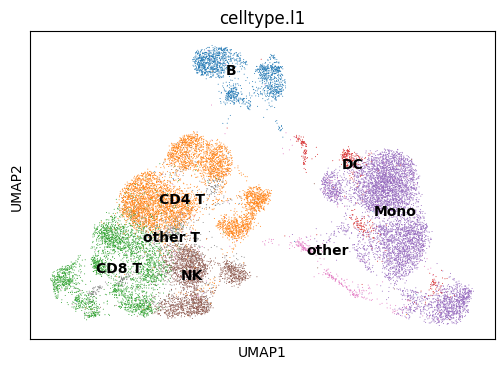

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


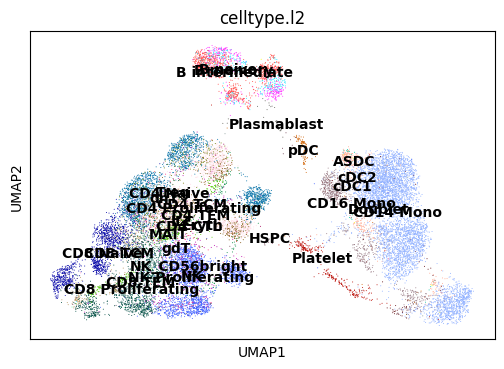

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


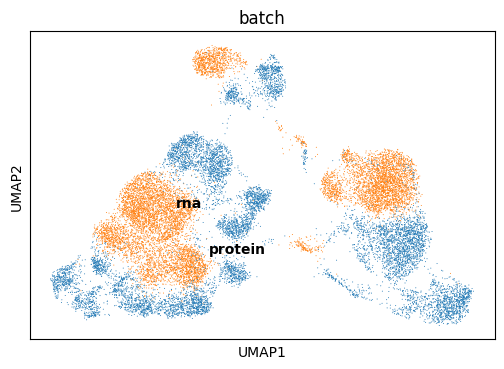

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.738,
lv2 matching acc: 0.542.
For All matchings: FOSCTTM score: 0.24666967000000004, 
Knn Alignment score: [0.0011 0.0023 0.0033 0.0044 0.0059 0.007  0.0079 0.0091 0.0099 0.0111
 0.0121 0.0127 0.0135 0.015  0.0158 0.0168 0.0176 0.0185 0.0195 0.0207
 0.0217 0.0223 0.0229 0.0239 0.0251]
For All matchings: Silhouette F1 score for lv1: 0.5034124956762221, 
Silhouette F1 score for lv2: 0.49181686133458674



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  4.546610355377197
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.810,
lv2 matching acc: 0.634.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.798,
lv2 matching acc: 0.567.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


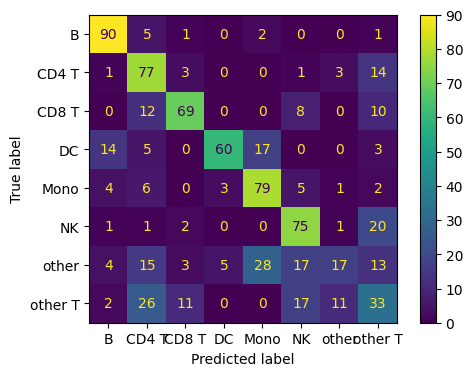

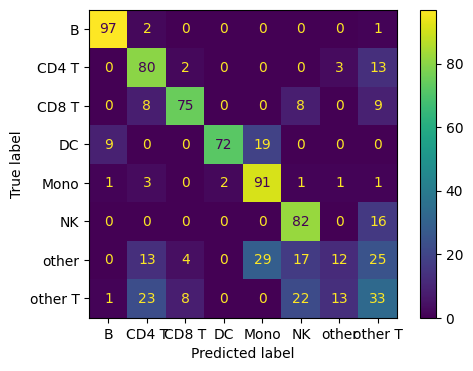

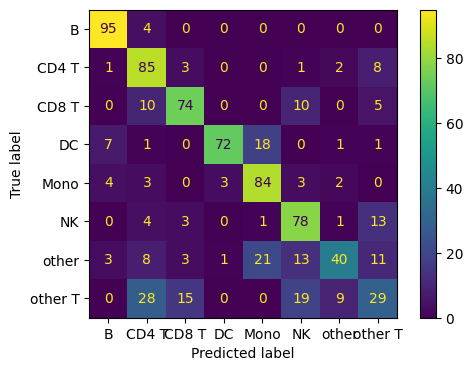

Epoch: 500: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 500: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.2031, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4677, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8866, Protein KL Div Z: 0.5894, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5503, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8052


Epoch: 501: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.1931, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4682, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8877, Protein KL Div Z: 0.5888, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5503, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8045


Epoch: 502: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.1995, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8895, Protein KL Div Z: 0.5895, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5487, Shared Recon Loss Gene: 0.2616, Shared Recon Loss Protein: 1.8060


Epoch: 503: 40it [00:08,  4.76it/s]


RNA Recon Loss: 2.2043, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4688, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8870, Protein KL Div Z: 0.5880, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5498, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8035


Epoch: 504: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.2045, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4687, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8853, Protein KL Div Z: 0.5869, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5492, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8015


Epoch: 505: 40it [00:08,  4.85it/s]


RNA Recon Loss: 2.1862, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4684, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8873, Protein KL Div Z: 0.5872, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5493, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8048


Epoch: 506: 40it [00:08,  4.83it/s]


RNA Recon Loss: 2.1993, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4685, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8847, Protein KL Div Z: 0.5864, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5484, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8038


Epoch: 507: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.2036, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4892, Protein KL Div Back Pro: 0.8877, Protein KL Div Z: 0.5869, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5493, Shared Recon Loss Gene: 0.2622, Shared Recon Loss Protein: 1.8085


Epoch: 508: 40it [00:08,  4.76it/s]


RNA Recon Loss: 2.2117, RNA KL Div L: 0.0153, RNA KL Div Z: 0.4683, Protein Recon Loss: 0.4902, Protein KL Div Back Pro: 0.8866, Protein KL Div Z: 0.5875, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5479, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8104


Epoch: 509: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.2121, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4686, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8893, Protein KL Div Z: 0.5867, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5487, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8080


Epoch: 510: 40it [00:08,  4.72it/s]


RNA Recon Loss: 2.1954, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4682, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8848, Protein KL Div Z: 0.5858, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5479, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8009


Epoch: 511: 40it [00:08,  4.76it/s]


RNA Recon Loss: 2.2223, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4678, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8848, Protein KL Div Z: 0.5855, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5474, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8037


Epoch: 512: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1993, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4677, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8855, Protein KL Div Z: 0.5843, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5472, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8015


Epoch: 513: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1906, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4676, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8843, Protein KL Div Z: 0.5836, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5474, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8077


Epoch: 514: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1984, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4675, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8867, Protein KL Div Z: 0.5836, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5480, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8015


Epoch: 515: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1882, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4680, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8883, Protein KL Div Z: 0.5851, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5473, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8023


Epoch: 516: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1910, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4682, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8833, Protein KL Div Z: 0.5818, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5459, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8073


Epoch: 517: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1987, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4683, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8860, Protein KL Div Z: 0.5815, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5458, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8064


Epoch: 518: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.2029, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4698, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8867, Protein KL Div Z: 0.5825, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5465, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8042


Epoch: 519: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1993, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4695, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8876, Protein KL Div Z: 0.5821, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5450, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8031


Epoch: 520: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.2036, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4681, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8841, Protein KL Div Z: 0.5804, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5444, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8038


Epoch: 521: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1941, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4692, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8879, Protein KL Div Z: 0.5812, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5452, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8101


Epoch: 522: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.1907, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4695, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8905, Protein KL Div Z: 0.5829, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5449, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8080


Epoch: 523: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.2134, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4689, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8864, Protein KL Div Z: 0.5809, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5448, Shared Recon Loss Gene: 0.2617, Shared Recon Loss Protein: 1.8023


Epoch: 524: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.2014, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4703, Protein Recon Loss: 0.4895, Protein KL Div Back Pro: 0.8886, Protein KL Div Z: 0.5813, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5448, Shared Recon Loss Gene: 0.2621, Shared Recon Loss Protein: 1.8037


Epoch: 525: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1873, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4697, Protein Recon Loss: 0.4886, Protein KL Div Back Pro: 0.8917, Protein KL Div Z: 0.5804, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5448, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8063


Epoch: 526: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1897, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4680, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8903, Protein KL Div Z: 0.5797, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5442, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8011


Epoch: 527: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1940, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4712, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8872, Protein KL Div Z: 0.5795, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5442, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8017


Epoch: 528: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1916, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4713, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8871, Protein KL Div Z: 0.5797, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5438, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8006


Epoch: 529: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.1930, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4710, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8881, Protein KL Div Z: 0.5795, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5428, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8036


Epoch: 530: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1912, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4715, Protein Recon Loss: 0.4912, Protein KL Div Back Pro: 0.8928, Protein KL Div Z: 0.5812, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5436, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8034


Epoch: 531: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1893, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4714, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8872, Protein KL Div Z: 0.5794, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5424, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8017


Epoch: 532: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.1945, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4715, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8875, Protein KL Div Z: 0.5805, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5440, Shared Recon Loss Gene: 0.2612, Shared Recon Loss Protein: 1.8026


Epoch: 533: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.1840, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4720, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8875, Protein KL Div Z: 0.5793, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5434, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.7997


Epoch: 534: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1799, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4712, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8874, Protein KL Div Z: 0.5797, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5424, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8013


Epoch: 535: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1769, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4709, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8826, Protein KL Div Z: 0.5774, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5425, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8012


Epoch: 536: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.1850, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4705, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8838, Protein KL Div Z: 0.5780, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5439, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8030


Epoch: 537: 40it [00:08,  4.60it/s]


RNA Recon Loss: 2.1867, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4707, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8845, Protein KL Div Z: 0.5780, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5418, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8061


Epoch: 538: 40it [00:08,  4.59it/s]


RNA Recon Loss: 2.1859, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4702, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8833, Protein KL Div Z: 0.5781, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5420, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8028


Epoch: 539: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1908, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4723, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8834, Protein KL Div Z: 0.5781, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5419, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8024


Epoch: 540: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.1843, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4719, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8809, Protein KL Div Z: 0.5769, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5413, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8054


Epoch: 541: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1881, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4709, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8793, Protein KL Div Z: 0.5765, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5424, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8014


Epoch: 542: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1834, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4716, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8823, Protein KL Div Z: 0.5768, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5412, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8029


Epoch: 543: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.1797, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4719, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8811, Protein KL Div Z: 0.5760, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5418, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8006


Epoch: 544: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1866, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4722, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8797, Protein KL Div Z: 0.5756, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5408, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8013


Epoch: 545: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1838, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8783, Protein KL Div Z: 0.5756, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5401, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8019


Epoch: 546: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1811, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4717, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8790, Protein KL Div Z: 0.5764, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5398, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8027


Epoch: 547: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1965, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4720, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8795, Protein KL Div Z: 0.5762, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5405, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8045


Epoch: 548: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1879, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4719, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8778, Protein KL Div Z: 0.5748, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5407, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8029


Epoch: 549: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1753, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4733, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8801, Protein KL Div Z: 0.5761, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5403, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8025


Epoch: 550: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1894, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4727, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8803, Protein KL Div Z: 0.5752, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5392, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8020


Epoch: 551: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1780, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4732, Protein Recon Loss: 0.4880, Protein KL Div Back Pro: 0.8783, Protein KL Div Z: 0.5738, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5387, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8028


Epoch: 552: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1778, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4728, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8767, Protein KL Div Z: 0.5734, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5384, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8009


Epoch: 553: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1777, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4727, Protein Recon Loss: 0.4878, Protein KL Div Back Pro: 0.8780, Protein KL Div Z: 0.5735, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5382, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8026


Epoch: 554: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1787, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4728, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8800, Protein KL Div Z: 0.5738, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5380, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8012


Epoch: 555: 40it [00:08,  4.53it/s]


RNA Recon Loss: 2.1826, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4729, Protein Recon Loss: 0.4884, Protein KL Div Back Pro: 0.8791, Protein KL Div Z: 0.5735, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5371, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8056


Epoch: 556: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1810, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4731, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8812, Protein KL Div Z: 0.5745, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5377, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8032


Epoch: 557: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.1884, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4734, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8768, Protein KL Div Z: 0.5724, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5371, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8067


Epoch: 558: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1846, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4739, Protein Recon Loss: 0.4883, Protein KL Div Back Pro: 0.8810, Protein KL Div Z: 0.5733, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5374, Shared Recon Loss Gene: 0.2625, Shared Recon Loss Protein: 1.8153


Epoch: 559: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1858, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4735, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8787, Protein KL Div Z: 0.5732, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5398, Shared Recon Loss Gene: 0.2628, Shared Recon Loss Protein: 1.8091


Epoch: 560: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1735, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4747, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8800, Protein KL Div Z: 0.5721, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5377, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8039


Epoch: 561: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1714, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4744, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8808, Protein KL Div Z: 0.5738, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5390, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8052


Epoch: 562: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1886, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4735, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8797, Protein KL Div Z: 0.5718, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5362, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8064


Epoch: 563: 40it [00:08,  4.63it/s]


RNA Recon Loss: 2.1756, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4748, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8776, Protein KL Div Z: 0.5712, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5366, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8013


Epoch: 564: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1656, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4747, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8776, Protein KL Div Z: 0.5713, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5362, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8016


Epoch: 565: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1878, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4751, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8765, Protein KL Div Z: 0.5721, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5367, Shared Recon Loss Gene: 0.2613, Shared Recon Loss Protein: 1.8014


Epoch: 566: 40it [00:08,  4.66it/s]


RNA Recon Loss: 2.1755, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4746, Protein Recon Loss: 0.4897, Protein KL Div Back Pro: 0.8739, Protein KL Div Z: 0.5690, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5371, Shared Recon Loss Gene: 0.2611, Shared Recon Loss Protein: 1.8022


Epoch: 567: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1735, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4744, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8778, Protein KL Div Z: 0.5696, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5361, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8014


Epoch: 568: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.1815, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4749, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8835, Protein KL Div Z: 0.5707, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5357, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8002


Epoch: 569: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1789, RNA KL Div L: 0.0152, RNA KL Div Z: 0.4746, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8833, Protein KL Div Z: 0.5703, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5354, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8010


Epoch: 570: 40it [00:08,  4.68it/s]


RNA Recon Loss: 2.1826, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4746, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8812, Protein KL Div Z: 0.5705, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5353, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8010


Epoch: 571: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.1781, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4750, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8826, Protein KL Div Z: 0.5689, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5344, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8019


Epoch: 572: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1693, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4735, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8860, Protein KL Div Z: 0.5700, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5340, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7985


Epoch: 573: 40it [00:08,  4.51it/s]


RNA Recon Loss: 2.1731, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4733, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8828, Protein KL Div Z: 0.5695, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5355, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8012


Epoch: 574: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1715, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4739, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8825, Protein KL Div Z: 0.5694, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5343, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8016


Epoch: 575: 40it [00:08,  4.70it/s]


RNA Recon Loss: 2.1817, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4744, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8810, Protein KL Div Z: 0.5686, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5334, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8004


Epoch: 576: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1765, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4747, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8817, Protein KL Div Z: 0.5693, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5321, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8010


Epoch: 577: 40it [00:08,  4.99it/s]


RNA Recon Loss: 2.1712, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4741, Protein Recon Loss: 0.4898, Protein KL Div Back Pro: 0.8782, Protein KL Div Z: 0.5674, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5329, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7992


Epoch: 578: 40it [00:08,  4.69it/s]


RNA Recon Loss: 2.1680, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4750, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8835, Protein KL Div Z: 0.5690, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5318, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7981


Epoch: 579: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1721, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4754, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8817, Protein KL Div Z: 0.5690, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5310, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8003


Epoch: 580: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1742, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4743, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8819, Protein KL Div Z: 0.5694, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5323, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.7992


Epoch: 581: 40it [00:08,  4.72it/s]


RNA Recon Loss: 2.1852, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4751, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8777, Protein KL Div Z: 0.5682, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5293, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8041


Epoch: 582: 40it [00:08,  4.73it/s]


RNA Recon Loss: 2.1708, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4762, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8802, Protein KL Div Z: 0.5682, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5302, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8035


Epoch: 583: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1690, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4756, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8793, Protein KL Div Z: 0.5685, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5305, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8016


Epoch: 584: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.1807, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4761, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8774, Protein KL Div Z: 0.5683, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5315, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8002


Epoch: 585: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.1767, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4762, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8765, Protein KL Div Z: 0.5695, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5305, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8021


Epoch: 586: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.1780, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4765, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8725, Protein KL Div Z: 0.5685, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5300, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8011


Epoch: 587: 40it [00:08,  4.71it/s]


RNA Recon Loss: 2.1724, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4759, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8740, Protein KL Div Z: 0.5687, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5293, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7979


Epoch: 588: 40it [00:08,  4.64it/s]


RNA Recon Loss: 2.1707, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4771, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8738, Protein KL Div Z: 0.5680, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5301, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7988


Epoch: 589: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.1674, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4763, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8730, Protein KL Div Z: 0.5683, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5291, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8050


Epoch: 590: 40it [00:08,  4.74it/s]


RNA Recon Loss: 2.1605, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4765, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8745, Protein KL Div Z: 0.5683, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5320, Shared Recon Loss Gene: 0.2610, Shared Recon Loss Protein: 1.8150


Epoch: 591: 40it [00:08,  4.78it/s]


RNA Recon Loss: 2.1647, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4769, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8742, Protein KL Div Z: 0.5688, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5295, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8005


Epoch: 592: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.1755, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4756, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8727, Protein KL Div Z: 0.5674, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5288, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8018


Epoch: 593: 40it [00:08,  4.72it/s]


RNA Recon Loss: 2.1672, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4769, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8720, Protein KL Div Z: 0.5682, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5303, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8017


Epoch: 594: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.1848, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4773, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8712, Protein KL Div Z: 0.5673, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5290, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8038


Epoch: 595: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.1882, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4763, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8739, Protein KL Div Z: 0.5679, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5278, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8034


Epoch: 596: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.1717, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4779, Protein Recon Loss: 0.4854, Protein KL Div Back Pro: 0.8700, Protein KL Div Z: 0.5658, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5288, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8016


Epoch: 597: 40it [00:08,  4.80it/s]


RNA Recon Loss: 2.1682, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4782, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8696, Protein KL Div Z: 0.5665, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5285, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8029


Epoch: 598: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.1691, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4790, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8726, Protein KL Div Z: 0.5653, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5282, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8006


Epoch: 599: 40it [00:08,  4.81it/s]


RNA Recon Loss: 2.1761, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4785, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8745, Protein KL Div Z: 0.5658, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5277, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8011


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


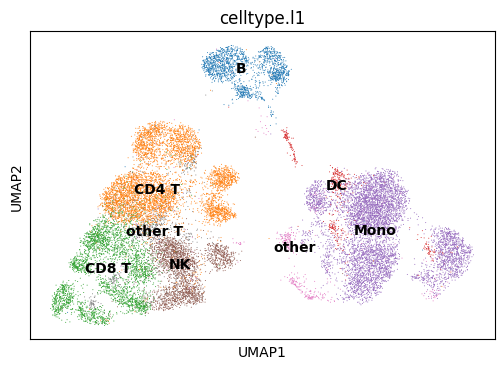

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


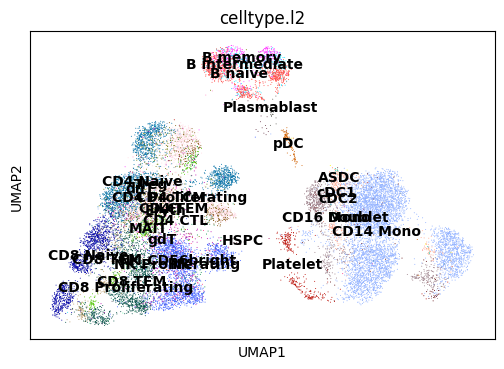

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


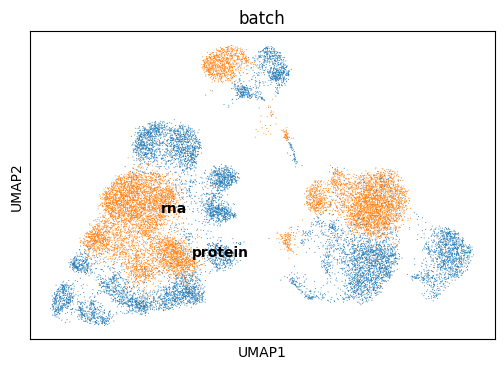

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.750,
lv2 matching acc: 0.561.
For All matchings: FOSCTTM score: 0.23803953000000003, 
Knn Alignment score: [0.0019 0.0028 0.0039 0.0052 0.0062 0.0067 0.0075 0.0082 0.009  0.0096
 0.0107 0.0119 0.0131 0.0142 0.0145 0.0156 0.0169 0.0179 0.0188 0.0197
 0.0209 0.0214 0.022  0.0228 0.0242]
For All matchings: Silhouette F1 score for lv1: 0.5067534000074787, 
Silhouette F1 score for lv2: 0.49460210937948756



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  4.222539186477661
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.832,
lv2 matching acc: 0.669.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.784,
lv2 matching acc: 0.561.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


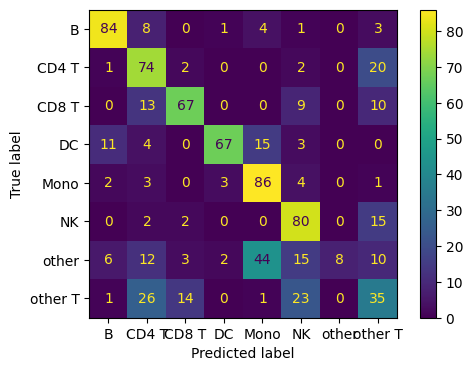

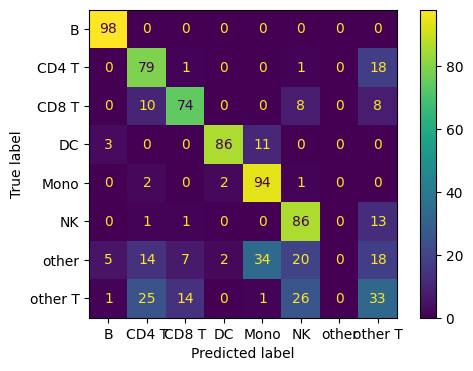

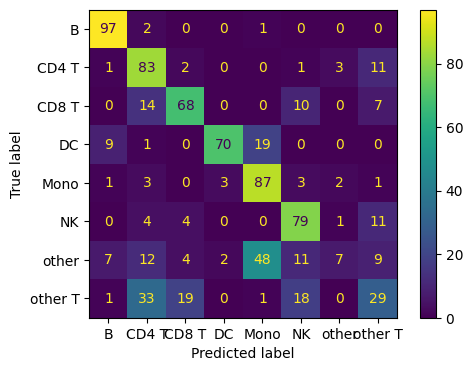

Epoch: 600: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 600: 40it [00:08,  4.73it/s]


RNA Recon Loss: 2.1689, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4786, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8770, Protein KL Div Z: 0.5678, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5279, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7984


Epoch: 601: 40it [00:08,  4.77it/s]


RNA Recon Loss: 2.1695, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4789, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8747, Protein KL Div Z: 0.5661, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5275, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8018


Epoch: 602: 40it [00:08,  4.81it/s]


RNA Recon Loss: 2.1659, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4781, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8738, Protein KL Div Z: 0.5657, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5274, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7994


Epoch: 603: 40it [00:08,  4.70it/s]


RNA Recon Loss: 2.1656, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4785, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8699, Protein KL Div Z: 0.5661, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5269, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8021


Epoch: 604: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.1690, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4785, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8704, Protein KL Div Z: 0.5655, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5259, Shared Recon Loss Gene: 0.2606, Shared Recon Loss Protein: 1.8003


Epoch: 605: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1671, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8734, Protein KL Div Z: 0.5643, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5258, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8006


Epoch: 606: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1710, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4784, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8761, Protein KL Div Z: 0.5663, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5261, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.7999


Epoch: 607: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.1711, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4789, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8740, Protein KL Div Z: 0.5653, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5266, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8012


Epoch: 608: 40it [00:08,  4.79it/s]


RNA Recon Loss: 2.1614, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4780, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8730, Protein KL Div Z: 0.5651, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5251, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7996


Epoch: 609: 40it [00:07,  5.03it/s]


RNA Recon Loss: 2.1694, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4798, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8726, Protein KL Div Z: 0.5643, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5260, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.8015


Epoch: 610: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1541, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4790, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8751, Protein KL Div Z: 0.5646, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5253, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7983


Epoch: 611: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1623, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4785, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8751, Protein KL Div Z: 0.5637, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5256, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7999


Epoch: 612: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1797, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4787, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8790, Protein KL Div Z: 0.5652, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5258, Shared Recon Loss Gene: 0.2604, Shared Recon Loss Protein: 1.7992


Epoch: 613: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.1832, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4782, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8781, Protein KL Div Z: 0.5654, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5239, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8026


Epoch: 614: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1631, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4791, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8739, Protein KL Div Z: 0.5639, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5249, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8013


Epoch: 615: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1640, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4802, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8776, Protein KL Div Z: 0.5652, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5230, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8002


Epoch: 616: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1570, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4804, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8743, Protein KL Div Z: 0.5636, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5229, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7995


Epoch: 617: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1621, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8724, Protein KL Div Z: 0.5633, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5231, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7986


Epoch: 618: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1630, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4797, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8691, Protein KL Div Z: 0.5630, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5232, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8044


Epoch: 619: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.1610, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8722, Protein KL Div Z: 0.5634, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5241, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8023


Epoch: 620: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1667, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4799, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8719, Protein KL Div Z: 0.5627, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5229, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7980


Epoch: 621: 40it [00:07,  5.36it/s]


RNA Recon Loss: 2.1632, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8727, Protein KL Div Z: 0.5634, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5219, Shared Recon Loss Gene: 0.2605, Shared Recon Loss Protein: 1.8041


Epoch: 622: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.1620, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8719, Protein KL Div Z: 0.5634, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5228, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8066


Epoch: 623: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1581, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4797, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8688, Protein KL Div Z: 0.5618, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5220, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8004


Epoch: 624: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1623, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4795, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8692, Protein KL Div Z: 0.5621, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5220, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7987


Epoch: 625: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1586, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4798, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8698, Protein KL Div Z: 0.5619, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5210, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.8015


Epoch: 626: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1540, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8726, Protein KL Div Z: 0.5631, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5219, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7975


Epoch: 627: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1565, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4795, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8709, Protein KL Div Z: 0.5620, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5212, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8042


Epoch: 628: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1782, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4808, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8724, Protein KL Div Z: 0.5632, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5212, Shared Recon Loss Gene: 0.2618, Shared Recon Loss Protein: 1.8037


Epoch: 629: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.1779, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4813, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8731, Protein KL Div Z: 0.5626, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5215, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8027


Epoch: 630: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1547, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4798, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8727, Protein KL Div Z: 0.5617, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5205, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8018


Epoch: 631: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1579, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4797, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8712, Protein KL Div Z: 0.5612, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5206, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7998


Epoch: 632: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1744, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4792, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8717, Protein KL Div Z: 0.5615, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5210, Shared Recon Loss Gene: 0.2609, Shared Recon Loss Protein: 1.8024


Epoch: 633: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.1615, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8666, Protein KL Div Z: 0.5609, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5200, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8007


Epoch: 634: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.1595, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4796, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8701, Protein KL Div Z: 0.5616, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5208, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8005


Epoch: 635: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.1631, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4795, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8698, Protein KL Div Z: 0.5617, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5199, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7996


Epoch: 636: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.1569, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4794, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8713, Protein KL Div Z: 0.5612, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5205, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8011


Epoch: 637: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.1571, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4795, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8684, Protein KL Div Z: 0.5597, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5193, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8001


Epoch: 638: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1553, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4804, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8711, Protein KL Div Z: 0.5611, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5199, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8004


Epoch: 639: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1554, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4806, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8705, Protein KL Div Z: 0.5592, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5199, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8004


Epoch: 640: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1583, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4802, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8731, Protein KL Div Z: 0.5601, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5195, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.7999


Epoch: 641: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1635, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4803, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8733, Protein KL Div Z: 0.5596, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5185, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7993


Epoch: 642: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1565, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4799, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8692, Protein KL Div Z: 0.5591, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5178, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.8045


Epoch: 643: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1535, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4811, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8703, Protein KL Div Z: 0.5604, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5188, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.8026


Epoch: 644: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1634, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4807, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8717, Protein KL Div Z: 0.5611, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5178, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8007


Epoch: 645: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1693, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4807, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8691, Protein KL Div Z: 0.5598, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5167, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8010


Epoch: 646: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1545, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4802, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8678, Protein KL Div Z: 0.5584, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5170, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7965


Epoch: 647: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1550, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4812, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8735, Protein KL Div Z: 0.5610, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5167, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7997


Epoch: 648: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1544, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4805, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8707, Protein KL Div Z: 0.5592, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5177, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8002


Epoch: 649: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1453, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4808, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8700, Protein KL Div Z: 0.5597, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5180, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8020


Epoch: 650: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1544, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4813, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8693, Protein KL Div Z: 0.5592, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5178, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8013


Epoch: 651: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1471, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4812, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8676, Protein KL Div Z: 0.5585, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5176, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.8018


Epoch: 652: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1578, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4807, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8692, Protein KL Div Z: 0.5581, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5174, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8007


Epoch: 653: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1521, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4818, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8713, Protein KL Div Z: 0.5582, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5166, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7974


Epoch: 654: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1568, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4817, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8704, Protein KL Div Z: 0.5589, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5163, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7977


Epoch: 655: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1480, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4816, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8679, Protein KL Div Z: 0.5588, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5161, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7990


Epoch: 656: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.1588, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4821, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8651, Protein KL Div Z: 0.5584, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5154, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8051


Epoch: 657: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1573, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4818, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8665, Protein KL Div Z: 0.5587, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5170, Shared Recon Loss Gene: 0.2607, Shared Recon Loss Protein: 1.8119


Epoch: 658: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1498, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4811, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8638, Protein KL Div Z: 0.5581, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5136, Shared Recon Loss Gene: 0.2600, Shared Recon Loss Protein: 1.8045


Epoch: 659: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.1528, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4821, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8627, Protein KL Div Z: 0.5576, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5155, Shared Recon Loss Gene: 0.2608, Shared Recon Loss Protein: 1.8075


Epoch: 660: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1558, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4814, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8653, Protein KL Div Z: 0.5579, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5174, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8023


Epoch: 661: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1526, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4824, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8625, Protein KL Div Z: 0.5579, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5165, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8004


Epoch: 662: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1495, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4815, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8651, Protein KL Div Z: 0.5570, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5157, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7995


Epoch: 663: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1538, RNA KL Div L: 0.0151, RNA KL Div Z: 0.4818, Protein Recon Loss: 0.4887, Protein KL Div Back Pro: 0.8667, Protein KL Div Z: 0.5570, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5161, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8009


Epoch: 664: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1576, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4814, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8628, Protein KL Div Z: 0.5563, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5156, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7990


Epoch: 665: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1505, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4827, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8647, Protein KL Div Z: 0.5565, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5149, Shared Recon Loss Gene: 0.2603, Shared Recon Loss Protein: 1.8024


Epoch: 666: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1862, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4822, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8632, Protein KL Div Z: 0.5552, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5150, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7977


Epoch: 667: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1826, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4838, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8654, Protein KL Div Z: 0.5551, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5146, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.7987


Epoch: 668: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1577, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4831, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8628, Protein KL Div Z: 0.5545, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5136, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7987


Epoch: 669: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1476, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4833, Protein Recon Loss: 0.4871, Protein KL Div Back Pro: 0.8642, Protein KL Div Z: 0.5558, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5137, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7984


Epoch: 670: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1578, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4837, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.8626, Protein KL Div Z: 0.5556, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5154, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8000


Epoch: 671: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1510, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4844, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8630, Protein KL Div Z: 0.5549, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5136, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.8003


Epoch: 672: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1510, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4844, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8646, Protein KL Div Z: 0.5556, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5119, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.8016


Epoch: 673: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1508, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4843, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8622, Protein KL Div Z: 0.5557, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5125, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7998


Epoch: 674: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1518, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4846, Protein Recon Loss: 0.4873, Protein KL Div Back Pro: 0.8659, Protein KL Div Z: 0.5556, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5139, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7980


Epoch: 675: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.1472, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4847, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8674, Protein KL Div Z: 0.5561, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5128, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7980


Epoch: 676: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1418, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4846, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8636, Protein KL Div Z: 0.5537, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5131, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.8002


Epoch: 677: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1591, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4854, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8645, Protein KL Div Z: 0.5547, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5125, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.8010


Epoch: 678: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1540, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4863, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8665, Protein KL Div Z: 0.5542, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5112, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7991


Epoch: 679: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1554, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4845, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8638, Protein KL Div Z: 0.5542, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5121, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7998


Epoch: 680: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1462, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4862, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8644, Protein KL Div Z: 0.5541, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5121, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7984


Epoch: 681: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1478, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4864, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8655, Protein KL Div Z: 0.5534, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5110, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.8017


Epoch: 682: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1435, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4873, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8627, Protein KL Div Z: 0.5539, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5125, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7996


Epoch: 683: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1444, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4862, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8624, Protein KL Div Z: 0.5528, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5108, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.8008


Epoch: 684: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1393, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4859, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8659, Protein KL Div Z: 0.5529, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5106, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7997


Epoch: 685: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.1453, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4864, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8666, Protein KL Div Z: 0.5522, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5110, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7971


Epoch: 686: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1516, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4860, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8635, Protein KL Div Z: 0.5517, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5113, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7999


Epoch: 687: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1438, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4859, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8647, Protein KL Div Z: 0.5518, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5105, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.8032


Epoch: 688: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1481, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4867, Protein Recon Loss: 0.4872, Protein KL Div Back Pro: 0.8668, Protein KL Div Z: 0.5523, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5104, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.8015


Epoch: 689: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1443, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4869, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8670, Protein KL Div Z: 0.5525, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5101, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7999


Epoch: 690: 40it [00:07,  5.47it/s]


RNA Recon Loss: 2.1522, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4862, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8653, Protein KL Div Z: 0.5520, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5115, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8031


Epoch: 691: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.1432, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4870, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8659, Protein KL Div Z: 0.5512, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5106, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7980


Epoch: 692: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1440, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8669, Protein KL Div Z: 0.5513, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5105, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8010


Epoch: 693: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1446, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4875, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8675, Protein KL Div Z: 0.5512, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5093, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7987


Epoch: 694: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.1432, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4865, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8648, Protein KL Div Z: 0.5507, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5077, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7984


Epoch: 695: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1550, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4873, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8666, Protein KL Div Z: 0.5516, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5088, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.7981


Epoch: 696: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1484, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4873, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8648, Protein KL Div Z: 0.5498, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5088, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.8004


Epoch: 697: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.1455, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4875, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8653, Protein KL Div Z: 0.5507, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5090, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8009


Epoch: 698: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.1453, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4871, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8655, Protein KL Div Z: 0.5507, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5084, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7983


Epoch: 699: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.1510, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4881, Protein Recon Loss: 0.4876, Protein KL Div Back Pro: 0.8601, Protein KL Div Z: 0.5482, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5076, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7968


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


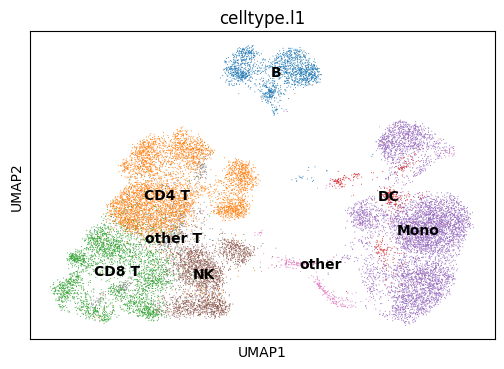

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


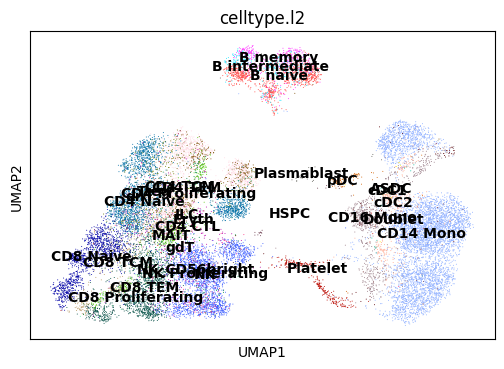

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


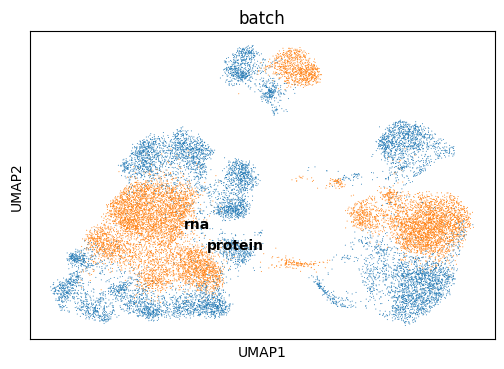

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.760,
lv2 matching acc: 0.569.
For All matchings: FOSCTTM score: 0.239644, 
Knn Alignment score: [0.0012 0.0025 0.0033 0.0041 0.005  0.0062 0.0074 0.0078 0.0085 0.0095
 0.0101 0.0111 0.0117 0.0129 0.0147 0.0155 0.016  0.017  0.0179 0.0187
 0.0197 0.0208 0.022  0.0227 0.0238]
For All matchings: Silhouette F1 score for lv1: 0.5093640471341282, 
Silhouette F1 score for lv2: 0.4972326800996135



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.958404541015625
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.842,
lv2 matching acc: 0.655.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.790,
lv2 matching acc: 0.573.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


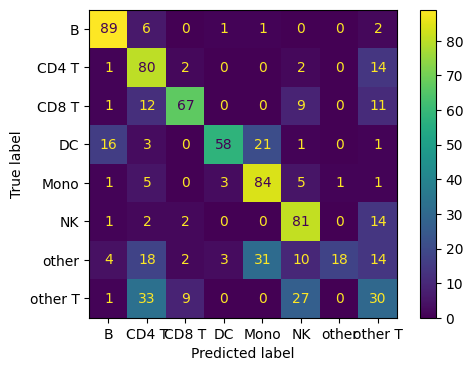

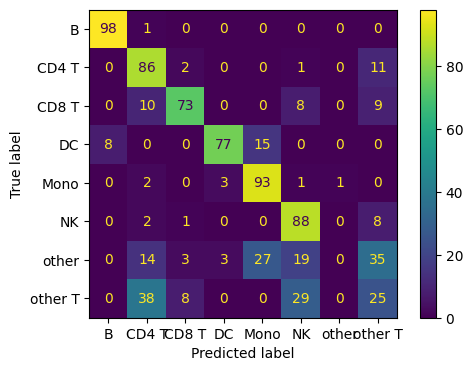

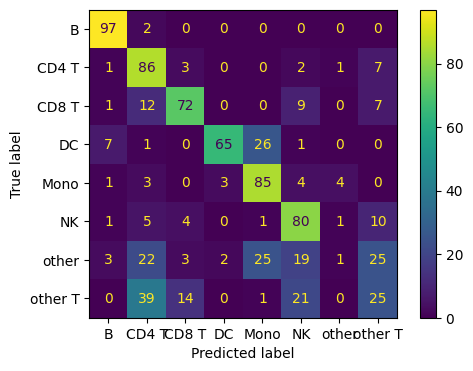

Epoch: 700: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 700: 40it [00:07,  5.63it/s]


RNA Recon Loss: 2.1408, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4881, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8631, Protein KL Div Z: 0.5499, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5083, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8043


Epoch: 701: 40it [00:07,  5.61it/s]


RNA Recon Loss: 2.1449, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4879, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8628, Protein KL Div Z: 0.5500, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5086, Shared Recon Loss Gene: 0.2598, Shared Recon Loss Protein: 1.8031


Epoch: 702: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1476, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4883, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8626, Protein KL Div Z: 0.5502, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5088, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7997


Epoch: 703: 40it [00:07,  5.56it/s]


RNA Recon Loss: 2.1555, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4885, Protein Recon Loss: 0.4854, Protein KL Div Back Pro: 0.8615, Protein KL Div Z: 0.5504, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5078, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.8000


Epoch: 704: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1445, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8595, Protein KL Div Z: 0.5501, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5087, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7972


Epoch: 705: 40it [00:07,  5.56it/s]


RNA Recon Loss: 2.1563, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4874, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8616, Protein KL Div Z: 0.5500, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5079, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7974


Epoch: 706: 40it [00:07,  5.55it/s]


RNA Recon Loss: 2.1414, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4879, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8607, Protein KL Div Z: 0.5499, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5082, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7983


Epoch: 707: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1452, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4878, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8621, Protein KL Div Z: 0.5499, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5088, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.8011


Epoch: 708: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1599, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4880, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8614, Protein KL Div Z: 0.5496, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5081, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8020


Epoch: 709: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1459, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4889, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8582, Protein KL Div Z: 0.5481, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5087, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8015


Epoch: 710: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1388, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4883, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8576, Protein KL Div Z: 0.5476, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5072, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7991


Epoch: 711: 40it [00:07,  5.51it/s]


RNA Recon Loss: 2.1407, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4876, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8608, Protein KL Div Z: 0.5481, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5069, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8001


Epoch: 712: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.1413, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4886, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8609, Protein KL Div Z: 0.5491, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5074, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7972


Epoch: 713: 40it [00:07,  5.51it/s]


RNA Recon Loss: 2.1421, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4883, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8603, Protein KL Div Z: 0.5477, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5071, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7980


Epoch: 714: 40it [00:07,  5.51it/s]


RNA Recon Loss: 2.1346, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4888, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8620, Protein KL Div Z: 0.5489, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5057, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7994


Epoch: 715: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1489, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4886, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8593, Protein KL Div Z: 0.5476, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5056, Shared Recon Loss Gene: 0.2595, Shared Recon Loss Protein: 1.7959


Epoch: 716: 40it [00:09,  4.20it/s]


RNA Recon Loss: 2.1416, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4884, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8602, Protein KL Div Z: 0.5481, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5055, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7970


Epoch: 717: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1405, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4889, Protein Recon Loss: 0.4860, Protein KL Div Back Pro: 0.8627, Protein KL Div Z: 0.5478, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5062, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7966


Epoch: 718: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1542, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4880, Protein Recon Loss: 0.4875, Protein KL Div Back Pro: 0.8653, Protein KL Div Z: 0.5473, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5057, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8052


Epoch: 719: 40it [00:07,  5.52it/s]


RNA Recon Loss: 2.1491, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4896, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8651, Protein KL Div Z: 0.5471, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5041, Shared Recon Loss Gene: 0.2599, Shared Recon Loss Protein: 1.8034


Epoch: 720: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1491, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4901, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8604, Protein KL Div Z: 0.5466, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5049, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7988


Epoch: 721: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1369, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4914, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8592, Protein KL Div Z: 0.5472, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5046, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7969


Epoch: 722: 40it [00:08,  4.65it/s]


RNA Recon Loss: 2.1417, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4903, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8577, Protein KL Div Z: 0.5471, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5049, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.8015


Epoch: 723: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.1383, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4903, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8582, Protein KL Div Z: 0.5469, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5046, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8000


Epoch: 724: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1321, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4899, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8608, Protein KL Div Z: 0.5479, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5042, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7982


Epoch: 725: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1472, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4900, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8587, Protein KL Div Z: 0.5465, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5040, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7966


Epoch: 726: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1471, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4899, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8578, Protein KL Div Z: 0.5459, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5040, Shared Recon Loss Gene: 0.2596, Shared Recon Loss Protein: 1.7972


Epoch: 727: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1418, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4904, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8597, Protein KL Div Z: 0.5468, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5038, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7956


Epoch: 728: 40it [00:08,  4.90it/s]


RNA Recon Loss: 2.1370, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4897, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8590, Protein KL Div Z: 0.5469, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5043, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7969


Epoch: 729: 40it [00:08,  4.85it/s]


RNA Recon Loss: 2.1362, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4897, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8563, Protein KL Div Z: 0.5454, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5042, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7979


Epoch: 730: 40it [00:07,  5.00it/s]


RNA Recon Loss: 2.1380, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4902, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8567, Protein KL Div Z: 0.5462, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5034, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.8013


Epoch: 731: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1385, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4901, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8594, Protein KL Div Z: 0.5467, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5027, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7977


Epoch: 732: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1449, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4892, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8597, Protein KL Div Z: 0.5457, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5032, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8023


Epoch: 733: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1419, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4910, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8593, Protein KL Div Z: 0.5453, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5027, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.8018


Epoch: 734: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1414, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4910, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8612, Protein KL Div Z: 0.5457, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5024, Shared Recon Loss Gene: 0.2601, Shared Recon Loss Protein: 1.7994


Epoch: 735: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1349, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4913, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8609, Protein KL Div Z: 0.5458, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5028, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7963


Epoch: 736: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1528, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4913, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8610, Protein KL Div Z: 0.5459, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5023, Shared Recon Loss Gene: 0.2588, Shared Recon Loss Protein: 1.7977


Epoch: 737: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1438, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4917, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8584, Protein KL Div Z: 0.5446, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5020, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.8023


Epoch: 738: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1390, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4924, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8613, Protein KL Div Z: 0.5457, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5013, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7974


Epoch: 739: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1521, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4926, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8629, Protein KL Div Z: 0.5461, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5015, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7964


Epoch: 740: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1464, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4900, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8578, Protein KL Div Z: 0.5450, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5018, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7979


Epoch: 741: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1342, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4923, Protein Recon Loss: 0.4863, Protein KL Div Back Pro: 0.8593, Protein KL Div Z: 0.5446, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5004, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7992


Epoch: 742: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1432, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4923, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8574, Protein KL Div Z: 0.5432, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5018, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.8005


Epoch: 743: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1402, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4931, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8595, Protein KL Div Z: 0.5448, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5016, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7972


Epoch: 744: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1371, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4924, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8572, Protein KL Div Z: 0.5428, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5007, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7973


Epoch: 745: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1383, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4942, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8588, Protein KL Div Z: 0.5438, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5010, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7948


Epoch: 746: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1391, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4939, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8619, Protein KL Div Z: 0.5439, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5000, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7966


Epoch: 747: 40it [00:08,  5.00it/s]


RNA Recon Loss: 2.1379, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4924, Protein Recon Loss: 0.4861, Protein KL Div Back Pro: 0.8622, Protein KL Div Z: 0.5439, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5009, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7979


Epoch: 748: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1322, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4931, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8608, Protein KL Div Z: 0.5432, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5003, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.7972


Epoch: 749: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1305, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4928, Protein Recon Loss: 0.4877, Protein KL Div Back Pro: 0.8606, Protein KL Div Z: 0.5427, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4983, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.8048


Epoch: 750: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1349, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4930, Protein Recon Loss: 0.4874, Protein KL Div Back Pro: 0.8631, Protein KL Div Z: 0.5444, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5031, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.8042


Epoch: 751: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1380, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4928, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8616, Protein KL Div Z: 0.5442, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5017, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7988


Epoch: 752: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1331, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4924, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8605, Protein KL Div Z: 0.5434, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5008, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7973


Epoch: 753: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1353, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4932, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8572, Protein KL Div Z: 0.5422, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5006, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7967


Epoch: 754: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.1484, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4931, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8581, Protein KL Div Z: 0.5437, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4998, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8014


Epoch: 755: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.1497, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4932, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8581, Protein KL Div Z: 0.5428, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4996, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7967


Epoch: 756: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1315, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4933, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8595, Protein KL Div Z: 0.5432, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4997, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7959


Epoch: 757: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.1399, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4928, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8596, Protein KL Div Z: 0.5432, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.5001, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7952


Epoch: 758: 40it [00:07,  5.00it/s]


RNA Recon Loss: 2.1315, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4931, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8566, Protein KL Div Z: 0.5429, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4993, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7977


Epoch: 759: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1367, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4934, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8574, Protein KL Div Z: 0.5431, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4986, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7978


Epoch: 760: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.1403, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4926, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8532, Protein KL Div Z: 0.5417, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4989, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7964


Epoch: 761: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1331, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4930, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8596, Protein KL Div Z: 0.5431, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4992, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7967


Epoch: 762: 40it [00:07,  5.03it/s]


RNA Recon Loss: 2.1302, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4925, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8576, Protein KL Div Z: 0.5416, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4983, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7987


Epoch: 763: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1357, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4930, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8624, Protein KL Div Z: 0.5423, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4990, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7971


Epoch: 764: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1380, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4941, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8599, Protein KL Div Z: 0.5421, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4989, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7981


Epoch: 765: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1428, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4933, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8584, Protein KL Div Z: 0.5421, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4991, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7960


Epoch: 766: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4937, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8591, Protein KL Div Z: 0.5416, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4979, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7960


Epoch: 767: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1343, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4942, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8588, Protein KL Div Z: 0.5414, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4985, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7965


Epoch: 768: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1298, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4945, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8565, Protein KL Div Z: 0.5417, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4978, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7957


Epoch: 769: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1334, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4942, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8559, Protein KL Div Z: 0.5416, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4972, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7985


Epoch: 770: 40it [00:07,  5.02it/s]


RNA Recon Loss: 2.1351, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4945, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8576, Protein KL Div Z: 0.5411, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4970, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7974


Epoch: 771: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.1363, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4948, Protein Recon Loss: 0.4857, Protein KL Div Back Pro: 0.8543, Protein KL Div Z: 0.5405, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4961, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7957


Epoch: 772: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1335, RNA KL Div L: 0.0150, RNA KL Div Z: 0.4950, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8547, Protein KL Div Z: 0.5398, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4964, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7971


Epoch: 773: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1501, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4947, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8542, Protein KL Div Z: 0.5398, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4958, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7982


Epoch: 774: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1407, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4947, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8562, Protein KL Div Z: 0.5397, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4962, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7983


Epoch: 775: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1352, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4959, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8567, Protein KL Div Z: 0.5398, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4958, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7970


Epoch: 776: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1367, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4965, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8550, Protein KL Div Z: 0.5392, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4959, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7941


Epoch: 777: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.1334, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4957, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8563, Protein KL Div Z: 0.5398, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4963, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7975


Epoch: 778: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1370, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4956, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8571, Protein KL Div Z: 0.5384, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4947, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7971


Epoch: 779: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1461, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4955, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8597, Protein KL Div Z: 0.5390, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4951, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7961


Epoch: 780: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1310, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4960, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8572, Protein KL Div Z: 0.5392, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4958, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7992


Epoch: 781: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1263, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4978, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8599, Protein KL Div Z: 0.5390, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4950, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7989


Epoch: 782: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1294, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4975, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8558, Protein KL Div Z: 0.5383, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4945, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7984


Epoch: 783: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.1296, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4978, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8587, Protein KL Div Z: 0.5400, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4953, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7976


Epoch: 784: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1300, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8561, Protein KL Div Z: 0.5378, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4937, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7971


Epoch: 785: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.1237, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8574, Protein KL Div Z: 0.5395, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4954, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7978


Epoch: 786: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1339, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4971, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8550, Protein KL Div Z: 0.5381, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4947, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7970


Epoch: 787: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1270, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8546, Protein KL Div Z: 0.5377, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4938, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7983


Epoch: 788: 40it [00:08,  4.50it/s]


RNA Recon Loss: 2.1264, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4973, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8539, Protein KL Div Z: 0.5377, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4944, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7974


Epoch: 789: 40it [00:09,  4.28it/s]


RNA Recon Loss: 2.1297, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4972, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8536, Protein KL Div Z: 0.5379, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4944, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7966


Epoch: 790: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.1318, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4972, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8521, Protein KL Div Z: 0.5374, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4935, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7982


Epoch: 791: 40it [00:08,  4.56it/s]


RNA Recon Loss: 2.1345, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4975, Protein Recon Loss: 0.4870, Protein KL Div Back Pro: 0.8557, Protein KL Div Z: 0.5380, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4927, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.7995


Epoch: 792: 40it [00:09,  4.25it/s]


RNA Recon Loss: 2.1293, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4975, Protein Recon Loss: 0.4882, Protein KL Div Back Pro: 0.8590, Protein KL Div Z: 0.5385, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4931, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8019


Epoch: 793: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1265, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4970, Protein Recon Loss: 0.4894, Protein KL Div Back Pro: 0.8619, Protein KL Div Z: 0.5387, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4934, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.8072


Epoch: 794: 40it [00:08,  4.52it/s]


RNA Recon Loss: 2.1281, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4971, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8598, Protein KL Div Z: 0.5376, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4947, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.8141


Epoch: 795: 40it [00:08,  4.62it/s]


RNA Recon Loss: 2.1435, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8589, Protein KL Div Z: 0.5368, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4930, Shared Recon Loss Gene: 0.2591, Shared Recon Loss Protein: 1.8005


Epoch: 796: 40it [00:08,  4.75it/s]


RNA Recon Loss: 2.1403, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4978, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8614, Protein KL Div Z: 0.5375, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4925, Shared Recon Loss Gene: 0.2594, Shared Recon Loss Protein: 1.7994


Epoch: 797: 40it [00:09,  4.38it/s]


RNA Recon Loss: 2.1367, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4977, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8558, Protein KL Div Z: 0.5371, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4924, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7976


Epoch: 798: 40it [00:09,  4.35it/s]


RNA Recon Loss: 2.1273, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4974, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8544, Protein KL Div Z: 0.5358, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4909, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7983


Epoch: 799: 40it [00:08,  4.67it/s]


RNA Recon Loss: 2.1398, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4986, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8544, Protein KL Div Z: 0.5363, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4922, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7956


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


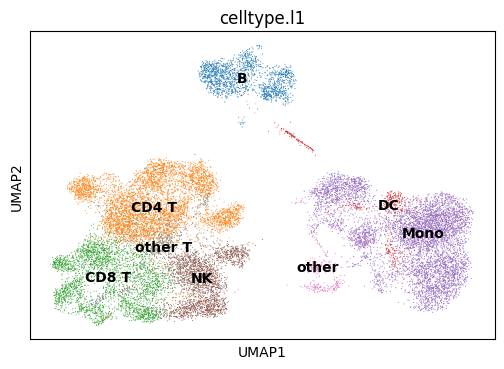

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


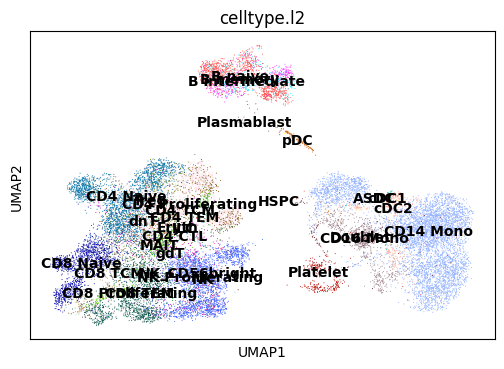

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


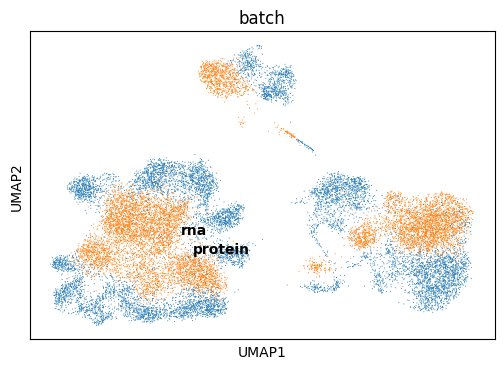

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.771,
lv2 matching acc: 0.579.
For All matchings: FOSCTTM score: 0.22436873000000002, 
Knn Alignment score: [0.001  0.0023 0.0035 0.0048 0.006  0.0068 0.0087 0.0095 0.0101 0.0107
 0.012  0.0129 0.0141 0.0153 0.016  0.017  0.0182 0.0191 0.02   0.0208
 0.0228 0.0236 0.0246 0.0256 0.0262]
For All matchings: Silhouette F1 score for lv1: 0.5141474238944116, 
Silhouette F1 score for lv2: 0.5006600408644882



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.7924420833587646
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.842,
lv2 matching acc: 0.658.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.793,
lv2 matching acc: 0.574.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


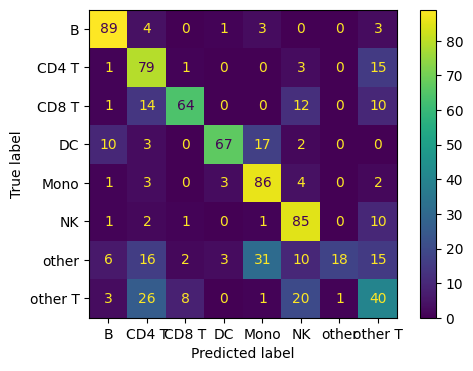

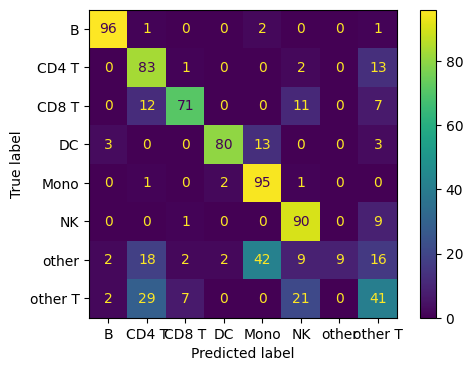

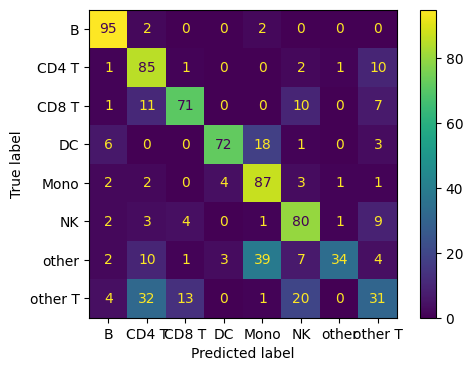

Epoch: 800: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 800: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.1397, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4982, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8566, Protein KL Div Z: 0.5371, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4921, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7961


Epoch: 801: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1354, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4986, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8546, Protein KL Div Z: 0.5374, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4918, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7971


Epoch: 802: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.1332, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4988, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8537, Protein KL Div Z: 0.5370, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4922, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7966


Epoch: 803: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1376, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4991, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8514, Protein KL Div Z: 0.5365, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4916, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7966


Epoch: 804: 40it [00:08,  4.99it/s]


RNA Recon Loss: 2.1398, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4977, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8517, Protein KL Div Z: 0.5362, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4915, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7982


Epoch: 805: 40it [00:07,  5.15it/s]


RNA Recon Loss: 2.1562, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4993, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8554, Protein KL Div Z: 0.5372, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4925, Shared Recon Loss Gene: 0.2590, Shared Recon Loss Protein: 1.8015


Epoch: 806: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.1395, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4989, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8530, Protein KL Div Z: 0.5355, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4903, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7943


Epoch: 807: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1195, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4991, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8516, Protein KL Div Z: 0.5365, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4911, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7955


Epoch: 808: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.1244, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4991, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8511, Protein KL Div Z: 0.5363, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4904, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7949


Epoch: 809: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1247, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4999, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8768, Protein KL Div Z: 0.5427, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4911, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7999


Epoch: 810: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1304, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5002, Protein Recon Loss: 0.4868, Protein KL Div Back Pro: 0.9020, Protein KL Div Z: 0.5504, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4906, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7968


Epoch: 811: 40it [00:07,  5.01it/s]


RNA Recon Loss: 2.1247, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4999, Protein Recon Loss: 0.4879, Protein KL Div Back Pro: 0.8823, Protein KL Div Z: 0.5470, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4902, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7987


Epoch: 812: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1324, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5004, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8731, Protein KL Div Z: 0.5463, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4901, Shared Recon Loss Gene: 0.2592, Shared Recon Loss Protein: 1.8029


Epoch: 813: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1425, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4994, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8661, Protein KL Div Z: 0.5452, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4894, Shared Recon Loss Gene: 0.2602, Shared Recon Loss Protein: 1.7984


Epoch: 814: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1314, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4992, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8611, Protein KL Div Z: 0.5438, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4883, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7984


Epoch: 815: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1223, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5002, Protein Recon Loss: 0.4867, Protein KL Div Back Pro: 0.8609, Protein KL Div Z: 0.5451, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4904, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7957


Epoch: 816: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1325, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4997, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8564, Protein KL Div Z: 0.5434, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4901, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7961


Epoch: 817: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1247, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5005, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8547, Protein KL Div Z: 0.5424, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4894, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7957


Epoch: 818: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.1255, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4996, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8529, Protein KL Div Z: 0.5417, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4896, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.8004


Epoch: 819: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.1287, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4992, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8531, Protein KL Div Z: 0.5421, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4884, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.8006


Epoch: 820: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1234, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5002, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8530, Protein KL Div Z: 0.5417, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4885, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7968


Epoch: 821: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1248, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4997, Protein Recon Loss: 0.4888, Protein KL Div Back Pro: 0.8516, Protein KL Div Z: 0.5409, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4897, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.8026


Epoch: 822: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1271, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4993, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8550, Protein KL Div Z: 0.5402, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4886, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7968


Epoch: 823: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1296, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4995, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8568, Protein KL Div Z: 0.5402, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4890, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7997


Epoch: 824: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1211, RNA KL Div L: 0.0149, RNA KL Div Z: 0.4988, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8533, Protein KL Div Z: 0.5400, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4891, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.8004


Epoch: 825: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1367, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4998, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8546, Protein KL Div Z: 0.5403, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4885, Shared Recon Loss Gene: 0.2586, Shared Recon Loss Protein: 1.7990


Epoch: 826: 40it [00:08,  4.89it/s]


RNA Recon Loss: 2.1328, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5006, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8513, Protein KL Div Z: 0.5386, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4873, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7945


Epoch: 827: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1260, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5000, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8512, Protein KL Div Z: 0.5400, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4875, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7966


Epoch: 828: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1251, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5006, Protein Recon Loss: 0.4869, Protein KL Div Back Pro: 0.8518, Protein KL Div Z: 0.5380, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4868, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.8036


Epoch: 829: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.1410, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5001, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8518, Protein KL Div Z: 0.5383, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4865, Shared Recon Loss Gene: 0.2597, Shared Recon Loss Protein: 1.7971


Epoch: 830: 40it [00:08,  4.82it/s]


RNA Recon Loss: 2.1289, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5007, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8541, Protein KL Div Z: 0.5388, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4870, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7980


Epoch: 831: 40it [00:07,  5.15it/s]


RNA Recon Loss: 2.1428, RNA KL Div L: 0.0148, RNA KL Div Z: 0.4996, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8550, Protein KL Div Z: 0.5380, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4876, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7957


Epoch: 832: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.1361, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5022, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8557, Protein KL Div Z: 0.5381, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4874, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7957


Epoch: 833: 40it [00:07,  5.29it/s]


RNA Recon Loss: 2.1327, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5021, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8520, Protein KL Div Z: 0.5371, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4857, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7985


Epoch: 834: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1211, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5014, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8525, Protein KL Div Z: 0.5370, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4874, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7973


Epoch: 835: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.1252, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5007, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8539, Protein KL Div Z: 0.5366, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4870, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7947


Epoch: 836: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1486, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5018, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8546, Protein KL Div Z: 0.5372, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4865, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.8009


Epoch: 837: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1317, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5020, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8508, Protein KL Div Z: 0.5366, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4860, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7992


Epoch: 838: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1278, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5030, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8528, Protein KL Div Z: 0.5369, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4857, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7973


Epoch: 839: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.1204, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5023, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8495, Protein KL Div Z: 0.5357, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4863, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7968


Epoch: 840: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1186, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5025, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8498, Protein KL Div Z: 0.5357, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4864, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7961


Epoch: 841: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1187, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5032, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8524, Protein KL Div Z: 0.5375, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4855, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7962


Epoch: 842: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1246, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5030, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8495, Protein KL Div Z: 0.5361, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4850, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7956


Epoch: 843: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1361, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5032, Protein Recon Loss: 0.4854, Protein KL Div Back Pro: 0.8493, Protein KL Div Z: 0.5352, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4846, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7953


Epoch: 844: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1362, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8462, Protein KL Div Z: 0.5344, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4846, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7970


Epoch: 845: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1292, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8503, Protein KL Div Z: 0.5351, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4841, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7965


Epoch: 846: 40it [00:07,  5.42it/s]


RNA Recon Loss: 2.1379, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5037, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8512, Protein KL Div Z: 0.5343, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4841, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7950


Epoch: 847: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1237, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5033, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8549, Protein KL Div Z: 0.5348, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4839, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7967


Epoch: 848: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1315, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5029, Protein Recon Loss: 0.4859, Protein KL Div Back Pro: 0.8534, Protein KL Div Z: 0.5342, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4831, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7978


Epoch: 849: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1232, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5035, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8560, Protein KL Div Z: 0.5354, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4836, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.8002


Epoch: 850: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.1251, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5031, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8548, Protein KL Div Z: 0.5349, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4837, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7958


Epoch: 851: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1249, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8521, Protein KL Div Z: 0.5345, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4841, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7972


Epoch: 852: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1160, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5026, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8513, Protein KL Div Z: 0.5336, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4835, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7966


Epoch: 853: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1177, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5034, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8511, Protein KL Div Z: 0.5340, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4838, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7973


Epoch: 854: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1228, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5033, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8552, Protein KL Div Z: 0.5345, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4829, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7973


Epoch: 855: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1282, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5023, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8537, Protein KL Div Z: 0.5327, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4828, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7943


Epoch: 856: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1221, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5029, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8559, Protein KL Div Z: 0.5334, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4826, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7965


Epoch: 857: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1166, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5029, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8571, Protein KL Div Z: 0.5338, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4830, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7994


Epoch: 858: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.1158, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5026, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8554, Protein KL Div Z: 0.5322, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4819, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7962


Epoch: 859: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1229, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5021, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8512, Protein KL Div Z: 0.5323, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4833, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7962


Epoch: 860: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1220, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5024, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8497, Protein KL Div Z: 0.5321, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4819, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7936


Epoch: 861: 40it [00:08,  4.73it/s]


RNA Recon Loss: 2.1176, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5023, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8505, Protein KL Div Z: 0.5321, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4819, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7956


Epoch: 862: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1153, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5030, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8516, Protein KL Div Z: 0.5322, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4823, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7985


Epoch: 863: 40it [00:08,  4.87it/s]


RNA Recon Loss: 2.1108, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5033, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8527, Protein KL Div Z: 0.5324, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4814, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.8024


Epoch: 864: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1215, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5030, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8510, Protein KL Div Z: 0.5315, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4812, Shared Recon Loss Gene: 0.2593, Shared Recon Loss Protein: 1.8051


Epoch: 865: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1132, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5038, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8496, Protein KL Div Z: 0.5309, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4796, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7964


Epoch: 866: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1312, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5044, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8519, Protein KL Div Z: 0.5309, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4812, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7970


Epoch: 867: 40it [00:07,  5.27it/s]


RNA Recon Loss: 2.1253, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5044, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8545, Protein KL Div Z: 0.5313, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4809, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7967


Epoch: 868: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.1147, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8521, Protein KL Div Z: 0.5309, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4814, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7961


Epoch: 869: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1221, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5036, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8480, Protein KL Div Z: 0.5288, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4814, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7914


Epoch: 870: 40it [00:08,  4.99it/s]


RNA Recon Loss: 2.1134, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5048, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8499, Protein KL Div Z: 0.5302, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4808, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7969


Epoch: 871: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.1148, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5040, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8508, Protein KL Div Z: 0.5300, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4815, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7969


Epoch: 872: 40it [00:08,  4.97it/s]


RNA Recon Loss: 2.1127, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5049, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8477, Protein KL Div Z: 0.5293, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4808, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.8008


Epoch: 873: 40it [00:08,  4.96it/s]


RNA Recon Loss: 2.1181, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8515, Protein KL Div Z: 0.5294, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4793, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.8010


Epoch: 874: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1201, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5041, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8503, Protein KL Div Z: 0.5287, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4801, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7966


Epoch: 875: 40it [00:07,  5.10it/s]


RNA Recon Loss: 2.1172, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5045, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8489, Protein KL Div Z: 0.5280, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4806, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7962


Epoch: 876: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.1207, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4865, Protein KL Div Back Pro: 0.8478, Protein KL Div Z: 0.5281, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4807, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7985


Epoch: 877: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.1193, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5042, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8487, Protein KL Div Z: 0.5289, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4802, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7941


Epoch: 878: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.1185, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5056, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8448, Protein KL Div Z: 0.5280, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4793, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7947


Epoch: 879: 40it [00:07,  5.28it/s]


RNA Recon Loss: 2.1226, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5043, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8444, Protein KL Div Z: 0.5279, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4801, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7950


Epoch: 880: 40it [00:07,  5.25it/s]


RNA Recon Loss: 2.1286, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5064, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8449, Protein KL Div Z: 0.5280, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4802, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7948


Epoch: 881: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1164, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5063, Protein Recon Loss: 0.4864, Protein KL Div Back Pro: 0.8432, Protein KL Div Z: 0.5277, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4783, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7947


Epoch: 882: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1153, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5040, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8451, Protein KL Div Z: 0.5267, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4784, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7947


Epoch: 883: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1129, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5054, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8461, Protein KL Div Z: 0.5261, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4792, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7937


Epoch: 884: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5047, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8467, Protein KL Div Z: 0.5265, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4777, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7998


Epoch: 885: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.1112, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5063, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8511, Protein KL Div Z: 0.5277, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4798, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7975


Epoch: 886: 40it [00:07,  5.34it/s]


RNA Recon Loss: 2.1120, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5057, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8501, Protein KL Div Z: 0.5268, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4783, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7933


Epoch: 887: 40it [00:07,  5.26it/s]


RNA Recon Loss: 2.1139, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5049, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8485, Protein KL Div Z: 0.5257, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4791, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7949


Epoch: 888: 40it [00:07,  5.31it/s]


RNA Recon Loss: 2.1124, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5066, Protein Recon Loss: 0.4829, Protein KL Div Back Pro: 0.8518, Protein KL Div Z: 0.5265, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4784, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7910


Epoch: 889: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.1179, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5065, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8494, Protein KL Div Z: 0.5262, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4782, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7963


Epoch: 890: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.1289, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5060, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8487, Protein KL Div Z: 0.5263, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4776, Shared Recon Loss Gene: 0.2585, Shared Recon Loss Protein: 1.7939


Epoch: 891: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.1142, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5059, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8505, Protein KL Div Z: 0.5269, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4769, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7940


Epoch: 892: 40it [00:07,  5.35it/s]


RNA Recon Loss: 2.1143, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5055, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8489, Protein KL Div Z: 0.5267, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4766, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7988


Epoch: 893: 40it [00:07,  5.33it/s]


RNA Recon Loss: 2.1226, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5061, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8490, Protein KL Div Z: 0.5256, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4764, Shared Recon Loss Gene: 0.2582, Shared Recon Loss Protein: 1.7954


Epoch: 894: 40it [00:07,  5.15it/s]


RNA Recon Loss: 2.1162, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5059, Protein Recon Loss: 0.4866, Protein KL Div Back Pro: 0.8488, Protein KL Div Z: 0.5255, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4767, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7953


Epoch: 895: 40it [00:07,  5.53it/s]


RNA Recon Loss: 2.1228, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5065, Protein Recon Loss: 0.4858, Protein KL Div Back Pro: 0.8528, Protein KL Div Z: 0.5267, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4775, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7939


Epoch: 896: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1185, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4835, Protein KL Div Back Pro: 0.8509, Protein KL Div Z: 0.5266, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4770, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7952


Epoch: 897: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1227, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5073, Protein Recon Loss: 0.4830, Protein KL Div Back Pro: 0.8479, Protein KL Div Z: 0.5258, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4771, Shared Recon Loss Gene: 0.2584, Shared Recon Loss Protein: 1.7954


Epoch: 898: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1208, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5075, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8440, Protein KL Div Z: 0.5257, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4764, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7967


Epoch: 899: 40it [00:07,  5.05it/s]


RNA Recon Loss: 2.1182, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5066, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8456, Protein KL Div Z: 0.5257, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4770, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7970


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


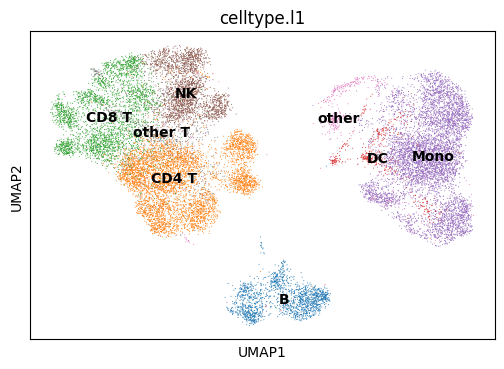

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


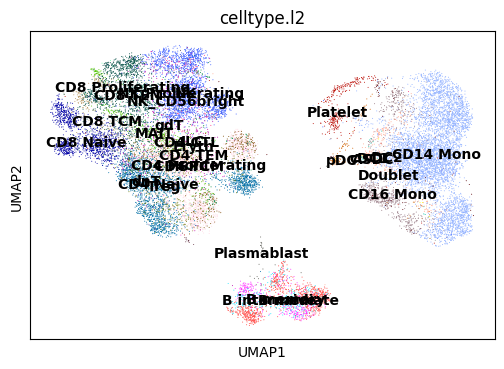

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


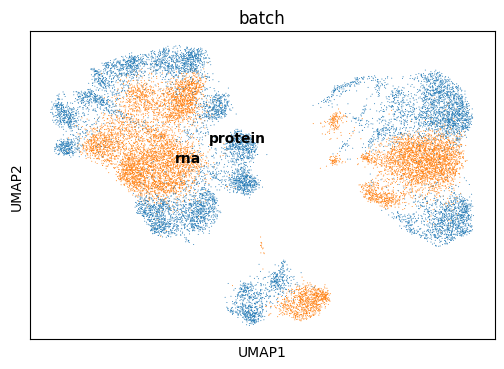

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.740,
lv2 matching acc: 0.563.
For All matchings: FOSCTTM score: 0.22213739000000002, 
Knn Alignment score: [0.0015 0.0026 0.0037 0.0048 0.0063 0.008  0.0089 0.0099 0.0108 0.0114
 0.0126 0.0139 0.0147 0.0158 0.0169 0.018  0.0192 0.02   0.0204 0.0214
 0.0224 0.0235 0.0242 0.0253 0.0265]
For All matchings: Silhouette F1 score for lv1: 0.515232057401403, 
Silhouette F1 score for lv2: 0.5022258727149411



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.65535044670105
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.802,
lv2 matching acc: 0.634.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.798,
lv2 matching acc: 0.580.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


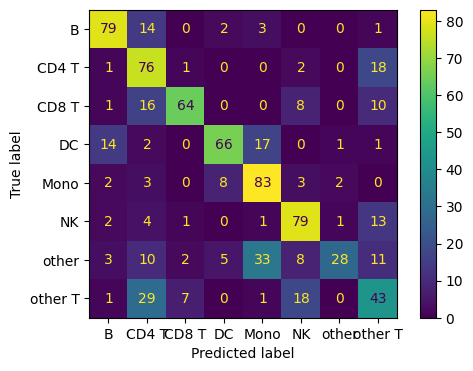

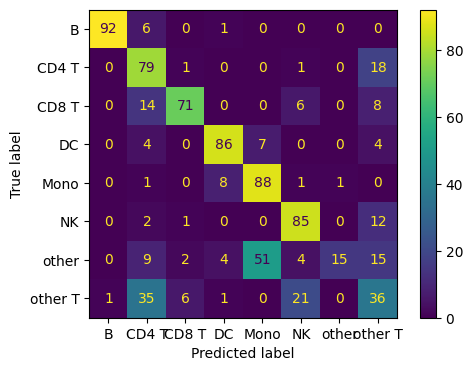

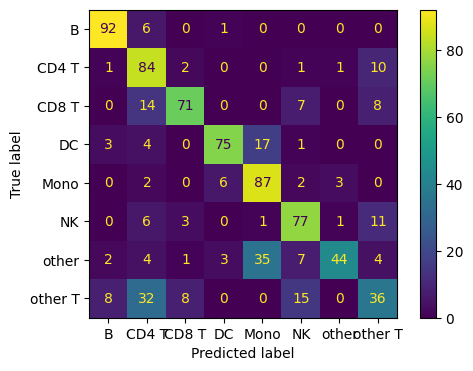

Epoch: 900: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 900: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1295, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5073, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8463, Protein KL Div Z: 0.5254, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4763, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7945


Epoch: 901: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.1113, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5070, Protein Recon Loss: 0.4856, Protein KL Div Back Pro: 0.8494, Protein KL Div Z: 0.5259, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4760, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7980


Epoch: 902: 40it [00:08,  4.95it/s]


RNA Recon Loss: 2.1232, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5077, Protein Recon Loss: 0.4830, Protein KL Div Back Pro: 0.8480, Protein KL Div Z: 0.5242, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4780, Shared Recon Loss Gene: 0.2583, Shared Recon Loss Protein: 1.7932


Epoch: 903: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1163, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5073, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8496, Protein KL Div Z: 0.5250, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4763, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7938


Epoch: 904: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1099, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8527, Protein KL Div Z: 0.5254, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4763, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7978


Epoch: 905: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1212, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5064, Protein Recon Loss: 0.4835, Protein KL Div Back Pro: 0.8508, Protein KL Div Z: 0.5251, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4777, Shared Recon Loss Gene: 0.2576, Shared Recon Loss Protein: 1.7957


Epoch: 906: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1110, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5059, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8504, Protein KL Div Z: 0.5251, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4762, Shared Recon Loss Gene: 0.2563, Shared Recon Loss Protein: 1.7952


Epoch: 907: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1081, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5073, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8487, Protein KL Div Z: 0.5248, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4759, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7964


Epoch: 908: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1141, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5065, Protein Recon Loss: 0.4852, Protein KL Div Back Pro: 0.8485, Protein KL Div Z: 0.5250, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4763, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7950


Epoch: 909: 40it [00:07,  5.30it/s]


RNA Recon Loss: 2.1117, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5059, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8484, Protein KL Div Z: 0.5244, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4760, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7969


Epoch: 910: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1117, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5058, Protein Recon Loss: 0.4833, Protein KL Div Back Pro: 0.8502, Protein KL Div Z: 0.5247, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4761, Shared Recon Loss Gene: 0.2565, Shared Recon Loss Protein: 1.7941


Epoch: 911: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1140, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5065, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8467, Protein KL Div Z: 0.5231, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4750, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7942


Epoch: 912: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1136, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5063, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8473, Protein KL Div Z: 0.5238, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4756, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7942


Epoch: 913: 40it [00:07,  5.41it/s]


RNA Recon Loss: 2.1224, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5071, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8479, Protein KL Div Z: 0.5230, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4747, Shared Recon Loss Gene: 0.2587, Shared Recon Loss Protein: 1.7947


Epoch: 914: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1193, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5075, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8522, Protein KL Div Z: 0.5235, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4754, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7938


Epoch: 915: 40it [00:09,  4.19it/s]


RNA Recon Loss: 2.1076, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8504, Protein KL Div Z: 0.5224, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4746, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7953


Epoch: 916: 40it [00:08,  4.98it/s]


RNA Recon Loss: 2.1083, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5073, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8514, Protein KL Div Z: 0.5231, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4755, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7967


Epoch: 917: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.1103, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5069, Protein Recon Loss: 0.4833, Protein KL Div Back Pro: 0.8533, Protein KL Div Z: 0.5235, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4750, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7942


Epoch: 918: 40it [00:08,  4.57it/s]


RNA Recon Loss: 2.1077, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5081, Protein Recon Loss: 0.4826, Protein KL Div Back Pro: 0.8497, Protein KL Div Z: 0.5231, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4756, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7929


Epoch: 919: 40it [00:08,  4.92it/s]


RNA Recon Loss: 2.1094, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4835, Protein KL Div Back Pro: 0.8488, Protein KL Div Z: 0.5216, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4742, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7940


Epoch: 920: 40it [00:08,  4.61it/s]


RNA Recon Loss: 2.1122, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5077, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8502, Protein KL Div Z: 0.5228, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4741, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7991


Epoch: 921: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1090, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8475, Protein KL Div Z: 0.5224, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4737, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7960


Epoch: 922: 40it [00:07,  5.11it/s]


RNA Recon Loss: 2.1184, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5084, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8464, Protein KL Div Z: 0.5222, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4726, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7952


Epoch: 923: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.1053, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5082, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8476, Protein KL Div Z: 0.5220, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4734, Shared Recon Loss Gene: 0.2563, Shared Recon Loss Protein: 1.7926


Epoch: 924: 40it [00:07,  5.28it/s]


RNA Recon Loss: 2.1134, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5072, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8471, Protein KL Div Z: 0.5219, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4732, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7976


Epoch: 925: 40it [00:07,  5.04it/s]


RNA Recon Loss: 2.1112, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5079, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8457, Protein KL Div Z: 0.5207, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4732, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7981


Epoch: 926: 40it [00:07,  5.39it/s]


RNA Recon Loss: 2.1096, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5080, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8500, Protein KL Div Z: 0.5212, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4729, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.8015


Epoch: 927: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1147, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5070, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8496, Protein KL Div Z: 0.5210, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4744, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7965


Epoch: 928: 40it [00:07,  5.46it/s]


RNA Recon Loss: 2.1126, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5079, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8502, Protein KL Div Z: 0.5217, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4731, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.8007


Epoch: 929: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1145, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5074, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8513, Protein KL Div Z: 0.5217, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4751, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.8007


Epoch: 930: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1067, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5092, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8477, Protein KL Div Z: 0.5218, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4737, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7970


Epoch: 931: 40it [00:07,  5.50it/s]


RNA Recon Loss: 2.1110, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5089, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8459, Protein KL Div Z: 0.5208, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4735, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7961


Epoch: 932: 40it [00:07,  5.49it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0149, RNA KL Div Z: 0.5085, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8463, Protein KL Div Z: 0.5207, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4725, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7924


Epoch: 933: 40it [00:07,  5.48it/s]


RNA Recon Loss: 2.1093, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5095, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8437, Protein KL Div Z: 0.5195, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4718, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7946


Epoch: 934: 40it [00:07,  5.51it/s]


RNA Recon Loss: 2.1151, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5106, Protein Recon Loss: 0.4851, Protein KL Div Back Pro: 0.8424, Protein KL Div Z: 0.5189, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4718, Shared Recon Loss Gene: 0.2578, Shared Recon Loss Protein: 1.7982


Epoch: 935: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1139, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5104, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8468, Protein KL Div Z: 0.5207, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4727, Shared Recon Loss Gene: 0.2565, Shared Recon Loss Protein: 1.7949


Epoch: 936: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1285, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5109, Protein Recon Loss: 0.4831, Protein KL Div Back Pro: 0.8450, Protein KL Div Z: 0.5198, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4716, Shared Recon Loss Gene: 0.2589, Shared Recon Loss Protein: 1.7984


Epoch: 937: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1238, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5118, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8457, Protein KL Div Z: 0.5200, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4711, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7976


Epoch: 938: 40it [00:07,  5.40it/s]


RNA Recon Loss: 2.1155, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5108, Protein Recon Loss: 0.4830, Protein KL Div Back Pro: 0.8425, Protein KL Div Z: 0.5188, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4715, Shared Recon Loss Gene: 0.2580, Shared Recon Loss Protein: 1.7982


Epoch: 939: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1088, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5111, Protein Recon Loss: 0.4832, Protein KL Div Back Pro: 0.8434, Protein KL Div Z: 0.5197, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4713, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7940


Epoch: 940: 40it [00:07,  5.38it/s]


RNA Recon Loss: 2.1196, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5114, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8453, Protein KL Div Z: 0.5190, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4710, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7954


Epoch: 941: 40it [00:07,  5.44it/s]


RNA Recon Loss: 2.1230, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5112, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8438, Protein KL Div Z: 0.5199, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4715, Shared Recon Loss Gene: 0.2581, Shared Recon Loss Protein: 1.7985


Epoch: 942: 40it [00:07,  5.32it/s]


RNA Recon Loss: 2.1104, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5132, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8424, Protein KL Div Z: 0.5185, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4718, Shared Recon Loss Gene: 0.2570, Shared Recon Loss Protein: 1.7918


Epoch: 943: 40it [00:07,  5.45it/s]


RNA Recon Loss: 2.1109, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5140, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8420, Protein KL Div Z: 0.5190, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4719, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7934


Epoch: 944: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1190, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5127, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8429, Protein KL Div Z: 0.5186, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4716, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7941


Epoch: 945: 40it [00:07,  5.43it/s]


RNA Recon Loss: 2.1110, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5126, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8429, Protein KL Div Z: 0.5187, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4713, Shared Recon Loss Gene: 0.2559, Shared Recon Loss Protein: 1.7938


Epoch: 946: 40it [00:07,  5.37it/s]


RNA Recon Loss: 2.1034, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5122, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8435, Protein KL Div Z: 0.5184, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4708, Shared Recon Loss Gene: 0.2560, Shared Recon Loss Protein: 1.7934


Epoch: 947: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.1081, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5132, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8452, Protein KL Div Z: 0.5194, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4710, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7949


Epoch: 948: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1125, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5127, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8441, Protein KL Div Z: 0.5194, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4716, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7933


Epoch: 949: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1037, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5127, Protein Recon Loss: 0.4862, Protein KL Div Back Pro: 0.8437, Protein KL Div Z: 0.5177, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4714, Shared Recon Loss Gene: 0.2563, Shared Recon Loss Protein: 1.7929


Epoch: 950: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1029, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5121, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8443, Protein KL Div Z: 0.5191, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4706, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7960


Epoch: 951: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1085, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5120, Protein Recon Loss: 0.4833, Protein KL Div Back Pro: 0.8415, Protein KL Div Z: 0.5182, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4707, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7940


Epoch: 952: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.1045, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5122, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8407, Protein KL Div Z: 0.5169, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4697, Shared Recon Loss Gene: 0.2563, Shared Recon Loss Protein: 1.7951


Epoch: 953: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1006, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5128, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8430, Protein KL Div Z: 0.5175, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4710, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7956


Epoch: 954: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.1066, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5116, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8429, Protein KL Div Z: 0.5175, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4701, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7949


Epoch: 955: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1058, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5119, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8458, Protein KL Div Z: 0.5183, Embedding Loss P1: 0.0219, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4706, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7957


Epoch: 956: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1066, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5122, Protein Recon Loss: 0.4829, Protein KL Div Back Pro: 0.8422, Protein KL Div Z: 0.5177, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4702, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7935


Epoch: 957: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1143, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5124, Protein Recon Loss: 0.4830, Protein KL Div Back Pro: 0.8435, Protein KL Div Z: 0.5173, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4703, Shared Recon Loss Gene: 0.2577, Shared Recon Loss Protein: 1.7949


Epoch: 958: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1242, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5131, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8416, Protein KL Div Z: 0.5174, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4693, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7958


Epoch: 959: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1331, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5129, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8418, Protein KL Div Z: 0.5166, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4695, Shared Recon Loss Gene: 0.2574, Shared Recon Loss Protein: 1.7922


Epoch: 960: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1208, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5117, Protein Recon Loss: 0.4855, Protein KL Div Back Pro: 0.8435, Protein KL Div Z: 0.5169, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4697, Shared Recon Loss Gene: 0.2572, Shared Recon Loss Protein: 1.7974


Epoch: 961: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1129, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5137, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8442, Protein KL Div Z: 0.5160, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4693, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7969


Epoch: 962: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1177, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5132, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8402, Protein KL Div Z: 0.5156, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4691, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7949


Epoch: 963: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1059, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5139, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8414, Protein KL Div Z: 0.5165, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4685, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7934


Epoch: 964: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.1095, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5139, Protein Recon Loss: 0.4846, Protein KL Div Back Pro: 0.8433, Protein KL Div Z: 0.5159, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4694, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7950


Epoch: 965: 40it [00:07,  5.07it/s]


RNA Recon Loss: 2.1104, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5140, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8430, Protein KL Div Z: 0.5163, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4687, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7941


Epoch: 966: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1027, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5136, Protein Recon Loss: 0.4848, Protein KL Div Back Pro: 0.8434, Protein KL Div Z: 0.5159, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4681, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7954


Epoch: 967: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.1077, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5139, Protein Recon Loss: 0.4842, Protein KL Div Back Pro: 0.8443, Protein KL Div Z: 0.5163, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4692, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7972


Epoch: 968: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1019, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5138, Protein Recon Loss: 0.4839, Protein KL Div Back Pro: 0.8448, Protein KL Div Z: 0.5152, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4677, Shared Recon Loss Gene: 0.2564, Shared Recon Loss Protein: 1.7968


Epoch: 969: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.1014, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5121, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8476, Protein KL Div Z: 0.5165, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4685, Shared Recon Loss Gene: 0.2557, Shared Recon Loss Protein: 1.7927


Epoch: 970: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1107, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5141, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8447, Protein KL Div Z: 0.5161, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4675, Shared Recon Loss Gene: 0.2579, Shared Recon Loss Protein: 1.7940


Epoch: 971: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.1055, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5139, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8449, Protein KL Div Z: 0.5157, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4681, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7967


Epoch: 972: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1064, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5135, Protein Recon Loss: 0.4833, Protein KL Div Back Pro: 0.8437, Protein KL Div Z: 0.5153, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4678, Shared Recon Loss Gene: 0.2560, Shared Recon Loss Protein: 1.7917


Epoch: 973: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.0987, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5139, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8412, Protein KL Div Z: 0.5143, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4678, Shared Recon Loss Gene: 0.2567, Shared Recon Loss Protein: 1.7951


Epoch: 974: 40it [00:08,  4.93it/s]


RNA Recon Loss: 2.1037, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5133, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8407, Protein KL Div Z: 0.5152, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4675, Shared Recon Loss Gene: 0.2559, Shared Recon Loss Protein: 1.7960


Epoch: 975: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1096, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5130, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8435, Protein KL Div Z: 0.5149, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4676, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7952


Epoch: 976: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.1054, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5146, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8419, Protein KL Div Z: 0.5135, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4667, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7947


Epoch: 977: 40it [00:07,  5.08it/s]


RNA Recon Loss: 2.1152, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5144, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8420, Protein KL Div Z: 0.5144, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4677, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7966


Epoch: 978: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.1220, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5146, Protein Recon Loss: 0.4841, Protein KL Div Back Pro: 0.8431, Protein KL Div Z: 0.5146, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4677, Shared Recon Loss Gene: 0.2568, Shared Recon Loss Protein: 1.7938


Epoch: 979: 40it [00:07,  5.20it/s]


RNA Recon Loss: 2.1080, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5150, Protein Recon Loss: 0.4829, Protein KL Div Back Pro: 0.8415, Protein KL Div Z: 0.5133, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4673, Shared Recon Loss Gene: 0.2558, Shared Recon Loss Protein: 1.7915


Epoch: 980: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1116, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5138, Protein Recon Loss: 0.4826, Protein KL Div Back Pro: 0.8416, Protein KL Div Z: 0.5139, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4670, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7967


Epoch: 981: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1135, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5137, Protein Recon Loss: 0.4824, Protein KL Div Back Pro: 0.8429, Protein KL Div Z: 0.5139, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4666, Shared Recon Loss Gene: 0.2573, Shared Recon Loss Protein: 1.7924


Epoch: 982: 40it [00:07,  5.09it/s]


RNA Recon Loss: 2.1112, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5145, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8396, Protein KL Div Z: 0.5128, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4669, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7963


Epoch: 983: 40it [00:07,  5.12it/s]


RNA Recon Loss: 2.1107, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5145, Protein Recon Loss: 0.4838, Protein KL Div Back Pro: 0.8383, Protein KL Div Z: 0.5128, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4661, Shared Recon Loss Gene: 0.2575, Shared Recon Loss Protein: 1.7987


Epoch: 984: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1047, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5158, Protein Recon Loss: 0.4853, Protein KL Div Back Pro: 0.8365, Protein KL Div Z: 0.5120, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4673, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7967


Epoch: 985: 40it [00:07,  5.14it/s]


RNA Recon Loss: 2.1094, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5156, Protein Recon Loss: 0.4835, Protein KL Div Back Pro: 0.8385, Protein KL Div Z: 0.5129, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4661, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7932


Epoch: 986: 40it [00:07,  5.06it/s]


RNA Recon Loss: 2.1082, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5142, Protein Recon Loss: 0.4843, Protein KL Div Back Pro: 0.8392, Protein KL Div Z: 0.5131, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4660, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7969


Epoch: 987: 40it [00:07,  5.16it/s]


RNA Recon Loss: 2.1044, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5140, Protein Recon Loss: 0.4836, Protein KL Div Back Pro: 0.8411, Protein KL Div Z: 0.5126, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4650, Shared Recon Loss Gene: 0.2566, Shared Recon Loss Protein: 1.7954


Epoch: 988: 40it [00:07,  5.18it/s]


RNA Recon Loss: 2.1032, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5150, Protein Recon Loss: 0.4829, Protein KL Div Back Pro: 0.8417, Protein KL Div Z: 0.5123, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4662, Shared Recon Loss Gene: 0.2560, Shared Recon Loss Protein: 1.7947


Epoch: 989: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.1057, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5140, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8414, Protein KL Div Z: 0.5123, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4652, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7940


Epoch: 990: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1102, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5148, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8435, Protein KL Div Z: 0.5131, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4648, Shared Recon Loss Gene: 0.2571, Shared Recon Loss Protein: 1.7969


Epoch: 991: 40it [00:08,  4.58it/s]


RNA Recon Loss: 2.1172, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5152, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8412, Protein KL Div Z: 0.5120, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4645, Shared Recon Loss Gene: 0.2565, Shared Recon Loss Protein: 1.7948


Epoch: 992: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1262, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5164, Protein Recon Loss: 0.4844, Protein KL Div Back Pro: 0.8409, Protein KL Div Z: 0.5118, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4646, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7929


Epoch: 993: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1078, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5172, Protein Recon Loss: 0.4849, Protein KL Div Back Pro: 0.8411, Protein KL Div Z: 0.5131, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4639, Shared Recon Loss Gene: 0.2562, Shared Recon Loss Protein: 1.7983


Epoch: 994: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.1115, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5175, Protein Recon Loss: 0.4847, Protein KL Div Back Pro: 0.8413, Protein KL Div Z: 0.5124, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4653, Shared Recon Loss Gene: 0.2569, Shared Recon Loss Protein: 1.7962


Epoch: 995: 40it [00:07,  5.22it/s]


RNA Recon Loss: 2.1007, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5172, Protein Recon Loss: 0.4845, Protein KL Div Back Pro: 0.8389, Protein KL Div Z: 0.5116, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4651, Shared Recon Loss Gene: 0.2558, Shared Recon Loss Protein: 1.7950


Epoch: 996: 40it [00:07,  5.17it/s]


RNA Recon Loss: 2.1046, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5165, Protein Recon Loss: 0.4831, Protein KL Div Back Pro: 0.8377, Protein KL Div Z: 0.5106, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4649, Shared Recon Loss Gene: 0.2558, Shared Recon Loss Protein: 1.7958


Epoch: 997: 40it [00:07,  5.23it/s]


RNA Recon Loss: 2.1003, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5184, Protein Recon Loss: 0.4837, Protein KL Div Back Pro: 0.8394, Protein KL Div Z: 0.5117, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4640, Shared Recon Loss Gene: 0.2565, Shared Recon Loss Protein: 1.7943


Epoch: 998: 40it [00:07,  5.13it/s]


RNA Recon Loss: 2.0998, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5172, Protein Recon Loss: 0.4834, Protein KL Div Back Pro: 0.8391, Protein KL Div Z: 0.5110, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4647, Shared Recon Loss Gene: 0.2562, Shared Recon Loss Protein: 1.7956


Epoch: 999: 40it [00:07,  5.21it/s]


RNA Recon Loss: 2.1037, RNA KL Div L: 0.0148, RNA KL Div Z: 0.5171, Protein Recon Loss: 0.4850, Protein KL Div Back Pro: 0.8418, Protein KL Div Z: 0.5124, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4636, Shared Recon Loss Gene: 0.2561, Shared Recon Loss Protein: 1.7965


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


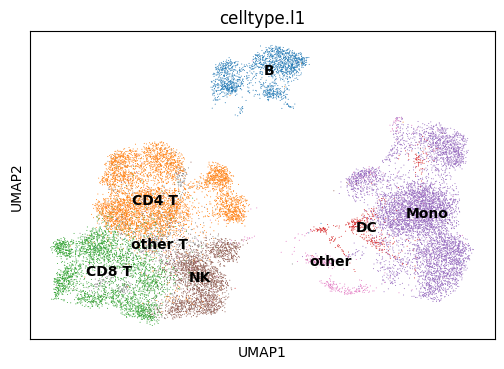

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


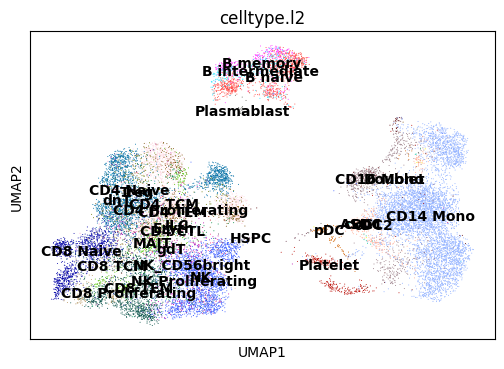

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


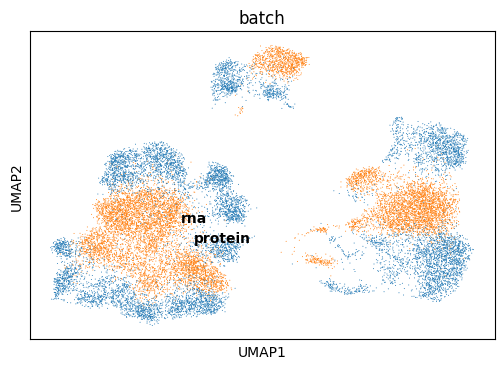

euclidean metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.761,
lv2 matching acc: 0.575.
For All matchings: FOSCTTM score: 0.22687485999999998, 
Knn Alignment score: [0.0016 0.0036 0.0047 0.0055 0.0067 0.0072 0.0083 0.0094 0.011  0.013
 0.0143 0.0158 0.0172 0.018  0.0184 0.0193 0.0203 0.0212 0.0222 0.0232
 0.0241 0.0248 0.0256 0.0273 0.0284]
For All matchings: Silhouette F1 score for lv1: 0.514238225878796, 
Silhouette F1 score for lv2: 0.5021238988195004



Matches are being filtered...
Matchings before filtering:  10000
Threshold distance for filtering the matchings:  3.5336098670959473
Matchings are reduced to 5000 after filtering...


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:423: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[matchings[0]], labels_l1[matchings[1]])
C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For only filtered matchings: lv1 matching acc: 0.837,
lv2 matching acc: 0.666.



Matches are being propagated....


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:460: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[filtered_matchings[0]], labels_l1[filtered_matchings[1]])
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For all matchings after propagation: lv1 matching acc: 0.797,
lv2 matching acc: 0.567.


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:495: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cm = confusion_matrix(labels_l1[propagated_matchings[0]], labels_l1[propagated_matchings[1]])


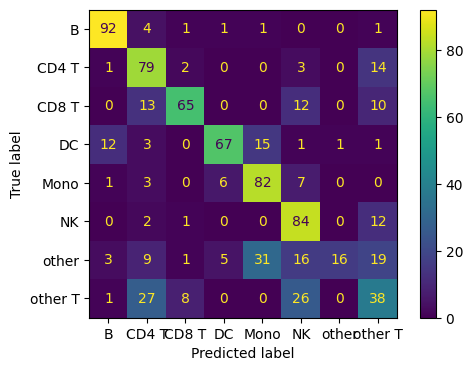

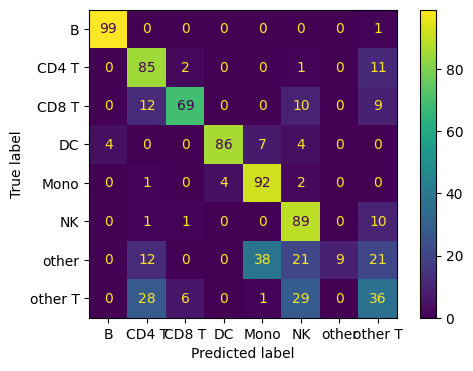

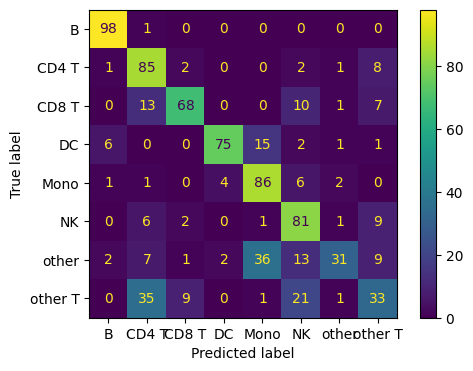

Epoch: 1000: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 1000: 40it [00:07,  5.19it/s]


RNA Recon Loss: 2.1042, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5176, Protein Recon Loss: 0.4840, Protein KL Div Back Pro: 0.8412, Protein KL Div Z: 0.5108, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4642, Shared Recon Loss Gene: 0.2565, Shared Recon Loss Protein: 1.7933


In [16]:
kl_weight = 0.0
metrics = {
    'original': {
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'filtered':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    },
    'propagated':{
        'lv1_acc': [],
        'lv2_acc': [],
        'foscttm_score': []
    }
}
for epoch in range(1001):
    loss = 0.0
    rna_recon_loss_piter = 0.0
    rna_kl_div_l_piter = 0.0
    rna_kl_div_z_piter = 0.0
    pro_recon_loss_piter = 0.0
    pro_kl_div_back_pro_piter = 0.0
    pro_kl_div_z_piter = 0.0
    shared_recon_loss1_piter = 0.0
    shared_recon_loss2_piter = 0.0
    shared_kl_div_z_piter = 0.0
    loss_emb_r1_piter = 0.0
    loss_emb_r2_piter = 0.0
    loss_emb_p1_piter = 0.0
    loss_emb_p2_piter = 0.0
    for batchr, batchp in tqdm(zip(rna_dataloader, protein_dataloader), desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
        
        y_shared = batchp["y_shared"].to(device)
        x_shared = batchr["x_shared"].to(device)
        y_unshared = batchp["y_unshared"].to(device)
        x_unshared = batchr["x_unshared"].to(device)
        x_batch = batchr["batch"].to(device)
        y_batch = batchp["batch"].to(device)
        # local_mean = rna_dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        # local_var = rna_dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_mean = batchr["mean"].to(device)
        local_var = batchr["var"].to(device)
        
        gene_size = x_shared.size(0)
        ## forward pass of unshared network of proteins and rna
        pro_recon_loss, pro_kl_div_z, pro_kl_div_back_pro, z_pro, _ = podel(y_unshared,cross_inf = False)
        rna_recon_loss, rna_kl_div_l, rna_kl_div_z, z_rna, _ = rodel(x_unshared, local_mean, local_var, cross_inf = False)
        unshared_protein_loss = torch.mean(pro_recon_loss) + 0.001*torch.mean(pro_kl_div_z) + 0.001*torch.mean(pro_kl_div_back_pro)
        unshared_rna_loss = torch.mean(rna_recon_loss) + 0.001*torch.mean(rna_kl_div_l) + 0.001*torch.mean(rna_kl_div_z)
        with torch.no_grad():
            _, _, _, _, _, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss_pro = unshared_protein_loss + loss_embedd_p
        loss_rna = unshared_rna_loss + loss_embedd_r
        loss_rna.backward()
        optimizer_r.step()
        loss_pro.backward()
        optimizer_p.step()
        
        # update losses: 
        rna_recon_loss_piter += torch.mean(rna_recon_loss).item()
        rna_kl_div_l_piter += torch.mean(rna_kl_div_l).item()
        rna_kl_div_z_piter += torch.mean(rna_kl_div_z).item()
        pro_recon_loss_piter += torch.mean(pro_recon_loss).item()
        pro_kl_div_back_pro_piter += torch.mean(pro_kl_div_back_pro).item()
        pro_kl_div_z_piter += torch.mean(pro_kl_div_z).item()
        loss_emb_p1_piter += torch.mean(loss_embedd_p).item()
        loss_emb_r1_piter += torch.mean(loss_embedd_r).item()
    
        # forward pass of shared_network
        reconst_loss_gene, reconst_loss_protein, kl_div_z, kl_div_l_gene, kl_div_back_pro, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf=False)
        shared_loss = torch.mean(reconst_loss_gene) + torch.mean(reconst_loss_protein) + 0.001*torch.mean(kl_div_z) + 0.001*torch.mean(kl_div_l_gene) + 0.001*torch.mean(kl_div_back_pro)
        with torch.no_grad():
            _, _, _, z_pro, _ = podel(y_unshared, cross_inf=False)
            _, _, _, z_rna, _ = rodel(x_unshared,local_mean,local_var, cross_inf=False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss = shared_loss + loss_embedd_p + loss_embedd_r
        loss.backward()
        optimizer_pr.step()
        shared_kl_div_z_piter += torch.mean(kl_div_z).item()
        shared_recon_loss1_piter += torch.mean(reconst_loss_gene).item()
        shared_recon_loss2_piter += torch.mean(reconst_loss_protein).item()
        
        # if epoch>10:
        #     optimizer_p.zero_grad()
        #     optimizer_r.zero_grad()
            # optimizer_pr.zero_grad()
            #cross network training
            # with torch.no_grad():
            # _, _, _, _, _, z_gene, z_protein, para_out_prodel = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
            # pro_recon_loss, _, _, _, _ = podel(y_unshared,cross_inf = True, para = get_paras_for_podel(para_out_prodel, gene_size))
            # rna_recon_loss, _, _, _, _ = rodel(x_unshared, local_mean, local_var, cross_inf = True, para = get_paras_for_rodel(para_out_prodel, gene_size))
            # cross_loss_podel = torch.mean(pro_recon_loss)
            # cross_loss_rodel = torch.mean(rna_recon_loss)
            # cross_loss_rodel.backward(retain_graph=True)
            # optimizer_r.step()
            # cross_loss_podel.backward(retain_graph=True)
            # optimizer_p.step()

            # with torch.no_grad():
            #     _, _, _, z_pro, para_out_podel = podel(y_unshared, cross_inf=False)
            #     _, _, _, z_rna, para_out_rodel = rodel(x_unshared,local_mean,local_var, cross_inf=False)
            # recon_loss_prodel, _, _, _, _, _, _, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = True, para = get_paras_for_prodel(para_out_rodel, para_out_podel, gene_size))
            # cross_loss_prodel = torch.mean(recon_loss_prodel)
            # cross_loss_prodel.backward()
            # optimizer_pr.step()
         
    kl_weight = min(1.0,(epoch+1)/1000)  
    print(f"RNA Recon Loss: {rna_recon_loss_piter / 10000:.4f}, "
      f"RNA KL Div L: {rna_kl_div_l_piter / 10000:.4f}, "
      f"RNA KL Div Z: {rna_kl_div_z_piter / 10000:.4f}, "
      f"Protein Recon Loss: {pro_recon_loss_piter / 10000:.4f}, "
      f"Protein KL Div Back Pro: {pro_kl_div_back_pro_piter / 10000:.4f}, "
      f"Protein KL Div Z: {pro_kl_div_z_piter / 10000:.4f}, "
      f"Embedding Loss P1: {loss_emb_p1_piter / 10000:.4f}, "
      f"Embedding Loss R1: {loss_emb_r1_piter / 10000:.4f}, "
      f"Shared KL Div Z: {shared_kl_div_z_piter / 10000:.4f}, "
      f"Shared Recon Loss Gene: {shared_recon_loss1_piter / 10000:.4f}, "
      f"Shared Recon Loss Protein: {shared_recon_loss2_piter / 10000:.4f}")
    if (epoch+1) % 100 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            shared_rna_data = torch.Tensor(rna_dataset.shared_data)
            shared_pro_data = torch.Tensor(protein_dataset.shared_data)
            labelsl1 = rna_dataset.labels_l1
            labelsl2 = rna_dataset.labels_l2
            shared_tensor_mean = torch.Tensor(rna_dataset.local_mean).to(device)
            shared_tensor_var = torch.Tensor(rna_dataset.local_var).to(device)
            x_batch = torch.Tensor(rna_dataset.batch).to(device)
            y_batch = torch.Tensor(protein_dataset.batch).to(device)
            _, _, _, _, _, z_gene, z_pro, _ = prodel(shared_rna_data, shared_pro_data, shared_tensor_mean, shared_tensor_var, x_batch, y_batch, cross_inf=False)
            adata_plot = ad.AnnData(X= np.concatenate([z_gene.numpy(), z_pro.numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2)            
            met = mu.get_all_metrics(z_gene, z_pro, labelsl1, labelsl2, dim_use = 20, k_max=25, metric='euclidean', assignment_type='mindist', filter_prop=0.5, verbose=True)
            metrics['original']['lv1_acc'].append(met['original']['lv1_acc'])
            metrics['original']['lv2_acc'].append(met['original']['lv2_acc'])
            metrics['original']['foscttm_score'].append(met['original']['foscttm_score'])
            metrics['filtered']['lv1_acc'].append(met['filtered']['lv1_acc'])
            metrics['filtered']['lv2_acc'].append(met['filtered']['lv2_acc'])
            metrics['filtered']['foscttm_score'].append(met['filtered']['foscttm_score'])
            metrics['propagated']['lv1_acc'].append(met['propagated']['lv1_acc'])
            metrics['propagated']['lv2_acc'].append(met['propagated']['lv2_acc'])
            metrics['propagated']['foscttm_score'].append(met['propagated']['foscttm_score'])

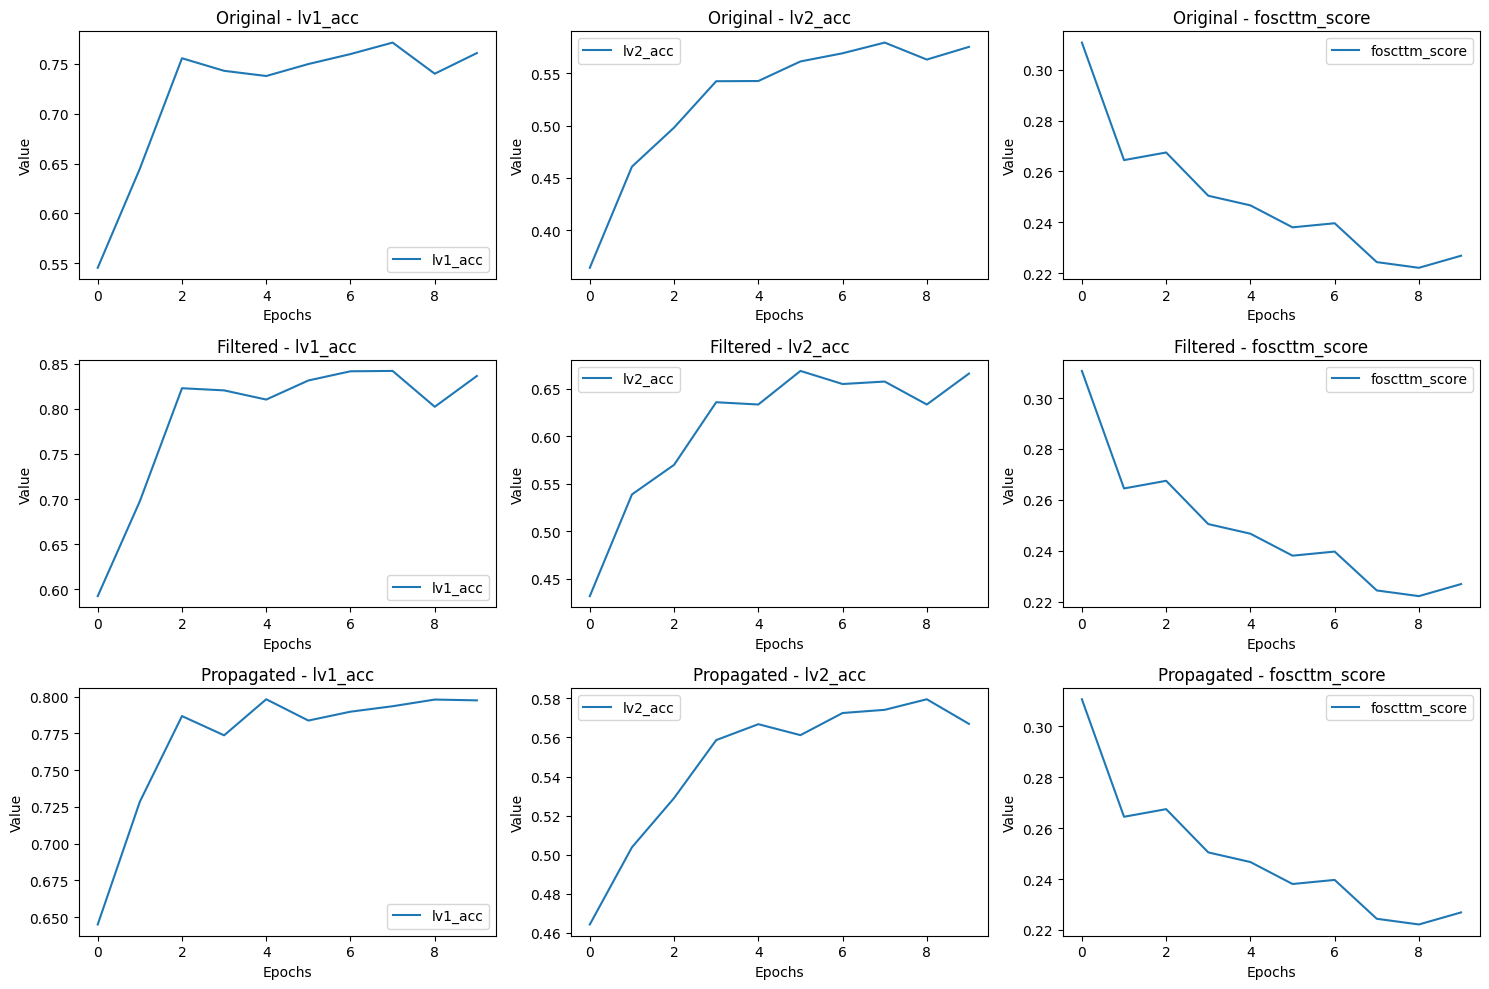

In [17]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot each metric on a separate subfigure
for i, (category, submetrics) in enumerate(metrics.items()):
    for j, (metric_name, values) in enumerate(submetrics.items()):
        ax = axs[i, j]
        ax.plot(values, label=metric_name)
        ax.set_title(f'{category.capitalize()} - {metric_name}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Value')
        ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Epoch: 0: 0it [00:00, ?it/s]C:\Users\vinee\AppData\Local\Temp\ipykernel_6728\3129631169.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return {"x_unshared":self.unshared_data[idx], "x_shared":self.shared_data[idx], "l1":self.labels_l1[idx], "l2":self.labels_l2[idx], "mean": self.local_mean[idx], "var": self.local_var[idx], "batch": self.batch[idx]}
Epoch: 0: 40it [00:07,  5.24it/s]


RNA Recon Loss: 2.0990, RNA KL Div L: 0.0147, RNA KL Div Z: 0.5156, Protein Recon Loss: 0.4833, Protein KL Div Back Pro: 0.8440, Protein KL Div Z: 0.5117, Embedding Loss P1: 0.0220, Embedding Loss R1: 0.0219, Shared KL Div Z: 0.4646, Shared Recon Loss Gene: 0.2561, Shared Recon Loss Protein: 1.7944


C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


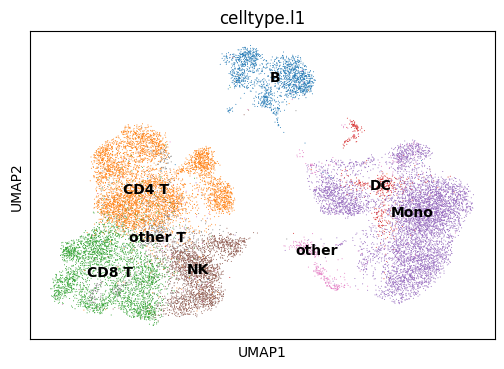

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


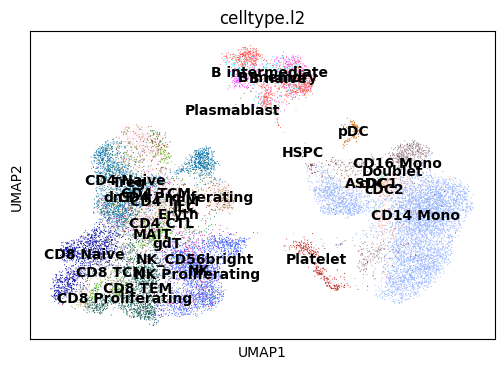

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


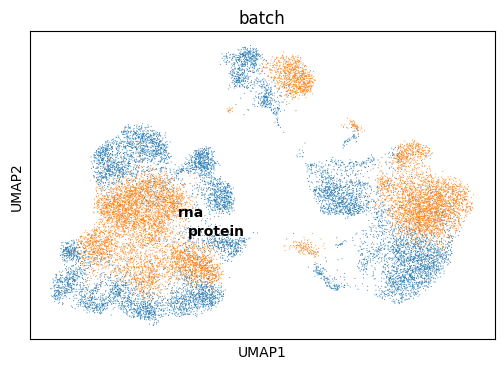

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


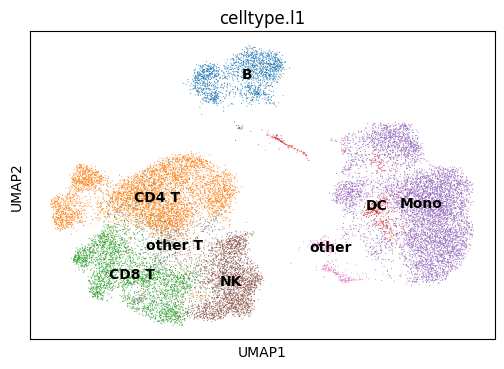

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


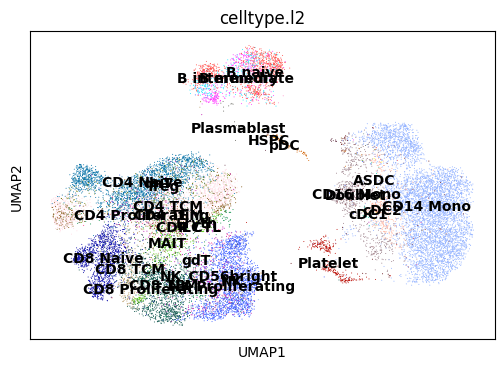

C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\vinee\miniconda3\envs\scvi\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


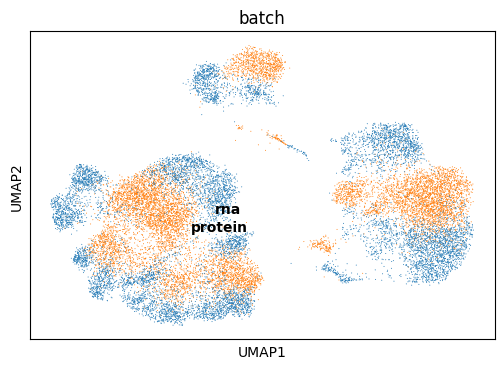

cosine metric will be used for calculating the distance!
Start the matching process...
Computing the distance matrix...
Getting matchings by Minimum Distance...
Linear assignment completed!


C:\Users\vinee\Desktop\cs690\vineet_ugp\scVI\metrics\match_utils.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.mean([labels1[i] == labels2[j] for i, j in zip(matching[0], matching[1])])


For All matchings: lv1 matching acc: 0.795,
lv2 matching acc: 0.609.


ValueError: Negative values in data passed to `pairwise_distances`. Precomputed distance  need to have non-negative values.

In [19]:
for epoch in range(1001):
    loss = 0.0
    rna_recon_loss_piter = 0.0
    rna_kl_div_l_piter = 0.0
    rna_kl_div_z_piter = 0.0
    pro_recon_loss_piter = 0.0
    pro_kl_div_back_pro_piter = 0.0
    pro_kl_div_z_piter = 0.0
    shared_recon_loss1_piter = 0.0
    shared_recon_loss2_piter = 0.0
    shared_kl_div_z_piter = 0.0
    loss_emb_r1_piter = 0.0
    loss_emb_r2_piter = 0.0
    loss_emb_p1_piter = 0.0
    loss_emb_p2_piter = 0.0
    for batchr, batchp in tqdm(zip(rna_dataloader, protein_dataloader), desc="Epoch: {}".format(epoch)):
        optimizer_p.zero_grad()
        optimizer_r.zero_grad()
        optimizer_pr.zero_grad()
        
        y_shared = batchp["y_shared"].to(device)
        x_shared = batchr["x_shared"].to(device)
        y_unshared = batchp["y_unshared"].to(device)
        x_unshared = batchr["x_unshared"].to(device)
        x_batch = batchr["batch"].to(device)
        y_batch = batchp["batch"].to(device)
        # local_mean = rna_dataset.local_mean.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        # local_var = rna_dataset.local_var.reshape(-1,1).expand(x_shared.shape[0], 1).to(device)
        local_mean = batchr["mean"].to(device)
        local_var = batchr["var"].to(device)
        
        gene_size = x_shared.size(0)
        ## forward pass of unshared network of proteins and rna
        pro_recon_loss, pro_kl_div_z, pro_kl_div_back_pro, z_pro, _ = podel(y_unshared,cross_inf = False)
        rna_recon_loss, rna_kl_div_l, rna_kl_div_z, z_rna, _ = rodel(x_unshared, local_mean, local_var, cross_inf = False)
        unshared_protein_loss = torch.mean(pro_recon_loss) + 0.001*torch.mean(pro_kl_div_z) + 0.001*torch.mean(pro_kl_div_back_pro)
        unshared_rna_loss = torch.mean(rna_recon_loss) + 0.001*torch.mean(rna_kl_div_l) + 0.001*torch.mean(rna_kl_div_z)
        with torch.no_grad():
            _, _, _, _, _, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss_pro = unshared_protein_loss + loss_embedd_p
        loss_rna = unshared_rna_loss + loss_embedd_r
        loss_rna.backward()
        optimizer_r.step()
        loss_pro.backward()
        optimizer_p.step()
        
        # update losses: 
        rna_recon_loss_piter += torch.mean(rna_recon_loss).item()
        rna_kl_div_l_piter += torch.mean(rna_kl_div_l).item()
        rna_kl_div_z_piter += torch.mean(rna_kl_div_z).item()
        pro_recon_loss_piter += torch.mean(pro_recon_loss).item()
        pro_kl_div_back_pro_piter += torch.mean(pro_kl_div_back_pro).item()
        pro_kl_div_z_piter += torch.mean(pro_kl_div_z).item()
        loss_emb_p1_piter += torch.mean(loss_embedd_p).item()
        loss_emb_r1_piter += torch.mean(loss_embedd_r).item()
    
        # forward pass of shared_network
        reconst_loss_gene, reconst_loss_protein, kl_div_z, kl_div_l_gene, kl_div_back_pro, z_gene, z_protein, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf=False)
        shared_loss = torch.mean(reconst_loss_gene) + torch.mean(reconst_loss_protein) + 0.001*torch.mean(kl_div_z) + 0.001*torch.mean(kl_div_l_gene) + 0.001*torch.mean(kl_div_back_pro)
        with torch.no_grad():
            _, _, _, z_pro, _ = podel(y_unshared, cross_inf=False)
            _, _, _, z_rna, _ = rodel(x_unshared,local_mean,local_var, cross_inf=False)
        loss_embedd_p = CLIP_loss(z_protein, z_pro)
        loss_embedd_r = CLIP_loss(z_gene, z_rna)
        loss = shared_loss + loss_embedd_p + loss_embedd_r
        loss.backward()
        optimizer_pr.step()
        shared_kl_div_z_piter += torch.mean(kl_div_z).item()
        shared_recon_loss1_piter += torch.mean(reconst_loss_gene).item()
        shared_recon_loss2_piter += torch.mean(reconst_loss_protein).item()
        
        # if epoch>10:
        #     optimizer_p.zero_grad()
        #     optimizer_r.zero_grad()
            # optimizer_pr.zero_grad()
            #cross network training
            # with torch.no_grad():
            # _, _, _, _, _, z_gene, z_protein, para_out_prodel = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = False)
            # pro_recon_loss, _, _, _, _ = podel(y_unshared,cross_inf = True, para = get_paras_for_podel(para_out_prodel, gene_size))
            # rna_recon_loss, _, _, _, _ = rodel(x_unshared, local_mean, local_var, cross_inf = True, para = get_paras_for_rodel(para_out_prodel, gene_size))
            # cross_loss_podel = torch.mean(pro_recon_loss)
            # cross_loss_rodel = torch.mean(rna_recon_loss)
            # cross_loss_rodel.backward(retain_graph=True)
            # optimizer_r.step()
            # cross_loss_podel.backward(retain_graph=True)
            # optimizer_p.step()

            # with torch.no_grad():
            #     _, _, _, z_pro, para_out_podel = podel(y_unshared, cross_inf=False)
            #     _, _, _, z_rna, para_out_rodel = rodel(x_unshared,local_mean,local_var, cross_inf=False)
            # recon_loss_prodel, _, _, _, _, _, _, _ = prodel(x_shared,y_shared,local_mean,local_var,x_batch,y_batch, cross_inf = True, para = get_paras_for_prodel(para_out_rodel, para_out_podel, gene_size))
            # cross_loss_prodel = torch.mean(recon_loss_prodel)
            # cross_loss_prodel.backward()
            # optimizer_pr.step()
         
    kl_weight = min(1.0,(epoch+1)/1000)  
    print(f"RNA Recon Loss: {rna_recon_loss_piter / 10000:.4f}, "
      f"RNA KL Div L: {rna_kl_div_l_piter / 10000:.4f}, "
      f"RNA KL Div Z: {rna_kl_div_z_piter / 10000:.4f}, "
      f"Protein Recon Loss: {pro_recon_loss_piter / 10000:.4f}, "
      f"Protein KL Div Back Pro: {pro_kl_div_back_pro_piter / 10000:.4f}, "
      f"Protein KL Div Z: {pro_kl_div_z_piter / 10000:.4f}, "
      f"Embedding Loss P1: {loss_emb_p1_piter / 10000:.4f}, "
      f"Embedding Loss R1: {loss_emb_r1_piter / 10000:.4f}, "
      f"Shared KL Div Z: {shared_kl_div_z_piter / 10000:.4f}, "
      f"Shared Recon Loss Gene: {shared_recon_loss1_piter / 10000:.4f}, "
      f"Shared Recon Loss Protein: {shared_recon_loss2_piter / 10000:.4f}")
    if (epoch) % 50 == 0:
        """Testing loop and visualisation saving"""
        with torch.no_grad():
            shared_rna_data = torch.Tensor(rna_dataset.shared_data)
            shared_pro_data = torch.Tensor(protein_dataset.shared_data)
            labelsl1 = rna_dataset.labels_l1
            labelsl2 = rna_dataset.labels_l2
            shared_tensor_mean = torch.Tensor(rna_dataset.local_mean).to(device)
            shared_tensor_var = torch.Tensor(rna_dataset.local_var).to(device)
            x_batch = torch.Tensor(rna_dataset.batch).to(device)
            y_batch = torch.Tensor(protein_dataset.batch).to(device)
            _, _, _, _, _, z_gene, z_pro, _ = prodel(shared_rna_data, shared_pro_data, shared_tensor_mean, shared_tensor_var, x_batch, y_batch, cross_inf=False)
            adata_plot = ad.AnnData(X= np.concatenate([z_gene.numpy(), z_pro.numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2) 
            
            adata_plot = ad.AnnData(X= np.concatenate([l2_normalize_batch_pytorch(z_gene).numpy(), l2_normalize_batch_pytorch(z_pro).numpy()], axis=0))
            adata_plot.obs['celltype.l1'] = np.concatenate([labelsl1,labels_l1], axis=0)
            adata_plot.obs['celltype.l2'] = np.concatenate([labelsl2,labels_l2], axis=0)
            adata_plot.obs['batch'] = np.concatenate([["rna"]*z_gene.shape[0], ["protein"]*z_pro.shape[0]], axis=0)
            sc.pp.neighbors(adata_plot)
            sc.tl.umap(adata_plot)
            sc.pl.umap(adata_plot, color='celltype.l1', legend_loc='on data', s=2)            
            sc.pl.umap(adata_plot, color='celltype.l2', legend_loc='on data', s=2)
            sc.pl.umap(adata_plot, color='batch', legend_loc='on data', s=2) 
            met = mu.get_all_metrics(z_gene, z_pro, labelsl1, labelsl2, dim_use = 20, k_max=25, metric='cosine', assignment_type='mindist', filter_prop=0.5, verbose=True)
            metrics['original']['lv1_acc'].append(met['original']['lv1_acc'])
            metrics['original']['lv2_acc'].append(met['original']['lv2_acc'])
            metrics['original']['foscttm_score'].append(met['original']['foscttm_score'])
            metrics['filtered']['lv1_acc'].append(met['filtered']['lv1_acc'])
            metrics['filtered']['lv2_acc'].append(met['filtered']['lv2_acc'])
            metrics['filtered']['foscttm_score'].append(met['filtered']['foscttm_score'])
            metrics['propagated']['lv1_acc'].append(met['propagated']['lv1_acc'])
            metrics['propagated']['lv2_acc'].append(met['propagated']['lv2_acc'])
            metrics['propagated']['foscttm_score'].append(met['propagated']['foscttm_score'])